# Contemporaneous and lagged causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results.

This tutorial explains the function ``PCMCI.run_pcmciplus``. In contrast to standard ``PCMCI.run_pcmci``, PCMCIplus allows to identify the full, lagged and contemporaneous, causal graph (up to the Markov equivalence class for contemporaneous links) under the standard assumptions of Causal Sufficiency, Faithfulness and the Markov condition. 

PCMCIplus is described here:
J. Runge (2020), Discovering contemporaneous and lagged causal relations in autocorrelated nonlinear time series datasets
http://www.auai.org/uai2020/proceedings/579_main_paper.pdf

Last, the following Nature Communications Perspective paper provides an overview of causal inference methods in general, identifies promising applications, and discusses methodological challenges (exemplified in Earth system sciences): 
https://www.nature.com/articles/s41467-019-10105-3

In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.pairwise_CI_jakob import PairwiseMultCI
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb

## 1. Structural causal processes with contemporaneous and lagged dependencies

We are interested in reconstructing *time series graphs* that can be used to represent the temporal dependency structure underlying complex dynamical systems. Consider an underlying time-dependent system $\mathbf{X}_t=(X^1_t,\ldots,X^N_t)$ with 

\begin{align} \label{eq:causal_model}
X^j_t &= f_j\left(\mathcal{P}(X^j_t),\,\eta^j_t\right)
\end{align}

where $f_j$ is some arbitrary measurable function with non-trivial dependencies on its arguments and $\eta^j_t$ represents mutually ($i\neq j$) and serially ($t'\neq t$) independent dynamical noise. The nodes in a time series graph represent the variables $X^j_t$ at different lag-times and the set of variables that $X^j_t$ depends on defines the causal parents $\mathcal{P}(X^j_t)\subset \mathbf{X}^-_{t+1}=(\mathbf{X}_{t}, \mathbf{X}_{t-1},\ldots){\setminus} \{ X^j_t\}$. A causal link $X^i_{t-\tau} \to X^j_t$ exists if $X^i_{t-\tau}\in \mathcal{P}(X^j_t)$. For $\tau>0$ we call them lagged links and for $\tau=0$ we call $X^i_{t} \to X^j_t$ a contemporaneous link. Then the variables $X^j_t \in \mathbf{X}_t$  together with their parents $\mathcal{P}(X^j_t)$ represent the time series graph $\mathcal{G}$.

In Tigramite a variant of this process (generalized additive model) can be generated with the function ``toys.structural_causal_process``. Note that, in contrast to ``toys.var_process``, here links have the format ``((i, -tau), coeff, func)`` where ``func`` can be an arbitrary (nonlinear) function provided as a python callable with one argument and coeff is the multiplication factor. That is, ``toys.structural_causal_process`` generates processes of the form

\begin{align}
X^j_t &= \eta^j_t + \sum_{X^i_{t-\tau}\in \mathcal{P}(X^j_t)} c^i_{\tau} f\left(X^i_{t-\tau}\right)
\end{align}

The noise distributions of $\eta^j$ can be specified in ``toys.structural_causal_process``.
Importantly, for $\tau=0$ we can generate contemporaneous, also called instantaneous, causal dependencies. Note that these need to be acyclic, otherwise an Error will be raised. Consider the following example taken from the PCMCIplus description paper:

In [2]:
seed = 7
auto_coeff = 0.95
coeff = 0.4
T = 500
def lin(x): return x

links ={0: [((0, -1), auto_coeff, lin),
            ((1, -1), coeff, lin)
            ],
        1: [((1, -1), auto_coeff, lin), 
            ],
        2: [((2, -1), auto_coeff, lin), 
            ((3, 0), -coeff, lin), 
            ],
        3: [((3, -1), auto_coeff, lin), 
            ((1, -2), coeff, lin), 
            ],
        4: [((4, -1), auto_coeff, lin), 
            ((3, 0), coeff, lin), 
            ],   
        5: [((5, -1), 0.5*auto_coeff, lin), 
            ((6, 0), coeff, lin), 
            ],  
        6: [((6, -1), 0.5*auto_coeff, lin), 
            ((5, -1), -coeff, lin), 
            ],  
        7: [((7, -1), auto_coeff, lin), 
            ((8, 0), -coeff, lin), 
            ],  
        8: [],                                     
        }

# Specify dynamical noise term distributions, here unit variance Gaussians
random_state = np.random.RandomState(seed)
noises = noises = [random_state.randn for j in links.keys()]
    
data, nonstationarity_indicator = toys.structural_causal_process(
    links=links, T=T, noises=noises, seed=seed)
T, N = data.shape

# Initialize dataframe object, specify variable names
var_names = [r'$X^{%d}$' % j for j in range(N) ]
dataframe = pp.DataFrame(data, var_names=var_names)

The true graph $\mathcal{G}$ here has shape ``(N, N, 2+1)`` since the maximum true time lag is ``tau_max=2``. An entry ``true_graph[i,j,tau]="-->"`` for  $\tau\geq 0$ indicates a causal link $X^i_{t-\tau} \to X^j_t$, ``true_graph[i,j,0]="<--"`` indicates a causal link $X^i_{t} \leftarrow X^j_t$ (only for $\tau=0$), and ``true_graph[i,j,tau]=""`` the absence of a causal link. 

In [3]:
true_graph = toys.links_to_graph(links=links)

## 2. PCMCI+: Causal discovery for contemporaneous and lagged dependencies

The goal of PCMCIplus is to reconstruct the graph $\mathcal{G}$. We will see that, even with infinite sample size and all assumptions being fulfilled, this is not always possible and graphs can only be reconstructed up to a Markov equivalence class. 

### General idea

The general idea behind PCMCIplus follows that of the PC algorithm: 

* **Skeleton discovery phase**: Starting from a completely connected graph first a skeleton of adjacencies $X^i_{t-\tau} - X^j_t$ is estimated by identifying which pairs of nodes are conditionally independent for certain subsets of the other nodes. See the paper for the particular way that conditions are chosen, which is different from the original PC algorithm. The adjacency between conditionally independent pairs is removed. The lagged adjacencies in that skeleton are then automatically oriented by time-order. For example, an undirected link $X^i_{t-2} - X^j_t$ can only be oriented as $X^i_{t-2} \to X^j_t$ since causal effects cannot go back in time. 

* **Collider orientation phase**: The contemporaneous adjacencies $X^i_{t} - X^j_t$ are then oriented based on the following collider rule. For an unshielded triple $X^k_{t-\tau} - X^i_t - X^j_t$ with $\tau\geq 0$ (for $\tau>0$ we always have $X^k_{t-\tau} \rightarrow X^i_t$) with no adjacency between $X^k_{t-\tau}$ and $X^j_t$: If $X^i_t$ is *not* part of the conditioning set that makes $X^k_{t-\tau}$ and $X^j_t$ independent, then orient  $X^k_{t-\tau} - X^i_t - X^j_t$ as  $X^k_{t-\tau} \rightarrow X^i_t \leftarrow X^j_t$. This rule is applied to all unshielded triples. There are three options (``contemp_collider_rule={'none', 'majority', 'conservative'}``) to decide whether a middle node $X^i_t$ is *not* part of the separating conditioning set: ``'none'``: In the original PC algorithm the conditions that lead to conditional independence in the skeleton discovery phase are stored (``sepset`` in Tigramite) and then used in the collider phase. Alternatively, all separating conditioning sets are *re-computed* based on the neighbors of $X^k_{t-\tau}$ and $X^j_t$ and collider motifs are oriented based on the ``'majority'`` or ``'conservative'`` rule as discussed in the paper.

* **Rule orientation phase**: Orient further adjacencies such that the graph does not contain cycles (rules R1-R3 in paper).

This algorithm results in a graph containing directed (lagged and contemporaneous) links  $X^i_{t-\tau} \to X^j_t$, but also contemporaneous links  $X^i_{t-\tau} - X^j_t$ that could not be oriented according to the phases above. For example, if the middle node $X^k_t$ in the fully contemporaneous triple $X^i_{t} - X^k_t - X^j_t$ *is* part of the conditioning set that makes $X^i_{t}$ and $X^j_t$ independent, then we cannot distinguish whether the true causal relations are $X^i_{t} \to X^k_t \to X^j_t$ or $X^i_{t} \leftarrow X^k_t \leftarrow X^j_t$ or $X^i_{t} \leftarrow X^k_t \to X^j_t$. These then form the *Markov equivalence class*. Note that triples involving a lagged $X^i_{t-\tau}$ for $\tau>0$ greatly help in orienting links since then only the first motif is possible.

**Order independence**: An important undesirable property of the original PC algorithm is that it depended on the order of the $N$ variables. This can be overcome by employing slightly modified version of the skeleton phase (implemented in Tigramite), the majority or conservative collider rule mentioned above, and by marking all links where orientation rules are conflicting with each other (``conflict_resolution=True``).

### PCMCIplus Algorithm

Compared to the standard PC algorithm adapted to time series, PCMCIplus is based on two central ideas: First, the skeleton phase is conducted separately for lagged and contemporaneous conditioning sets and the lagged phase uses much less tests leading to more power. Secondly, PCMCIplus modifies the conditioning sets for the individual conditional independence tests to make them well-calibrated under autocorrelation and increase detection power by utilizing the momentary conditional independence (MCI) approach. In summary, PCMCIplus estimates time-lagged and contemporaneous causal links by a four-phase algorithm (see detailed pseudo-code in the paper):

1.  **Skeleton discovery phase with lagged conditions** (same as for PCMCI): For each variable $X^j_t$, estimate a *superset* of lagged ($\tau>0$) parents $\widehat{\mathcal{B}}_t^-( X^j_t)$ with the iterative PC1 algorithm, implemented as ``run_pc_stable``.

2.   **Skeleton discovery phase with contemporaneous conditions and *momentary conditional independence* (MCI) tests**: Iterate through subsets $\mathcal{S}\subset \mathbf{X}_t$ of contemporaneous adjacencies and remove adjacencies for all (lagged and contemporaneous) ordered pairs $(X^i_{t-\tau}, X^j_t)$ with $X^j_{t} \in \mathbf{X}_t$ and $X^i_{t-\tau} \in \mathbf{X}_t \cup \widehat{\mathcal{B}}_t^-(X^j_t)$ if the MCI conditional independence holds ($\widehat{\mathcal{B}}_{t-\tau}^-(X^i_{t-{\tau}})$ are the parents of $X^i_{t-\tau}$):

\begin{align}
    X^i_{t-\tau} &~\perp~ X^j_{t} ~|~ \mathcal{S}, \widehat{\mathcal{B}}_t^-(X^j_t), \widehat{\mathcal{B}}_{t-\tau}^-(X^i_{t-{\tau}})
\end{align}

3.   **Collider orientation phase**: Orient contemporaneous links based on unshielded triples. Optionally apply conservative or majority rule (also based on MCI tests).

4.   **Rule orientation phase**: Orient remaining contemporaneous links based on rules R1-R3 in paper.

Phases 2-4 are implemented in ``run_pcalg`` with the parameter ``mode='contemp_conds'``.
The MCI test conditions on the lagged supersets of parents for *both* $X^i_{t-\tau}$ and $X^j_t$, which is the same idea as in PCMCI. The reasoning behind this is discussed in detail in the paper where also the consistency and order independence of PCMCIplus are proven.

In contrast to PCMCI, the relevant output of PCMCIplus is the array ``graph``. Its entries are interpreted as follows (under the standard assumptions of Causal Sufficiency, Faithfulness and the Markov condition):

 * ``graph[i,j,tau]='-->'`` for ``tau > 0`` denotes a directed, lagged causal link $X^i_{t-\tau} \to X^j_t$

 * ``graph[i,j,0]='-->'`` and ``graph[j,i,0]='<--'`` denotes a directed, contemporaneous causal link $X^i_{t} \to X^j_t$

 * ``graph[i,j,0]='o-o'`` and ``graph[j,i,0]='o-o'`` denotes an unoriented, contemporaneous adjacency $X^i_{t} - X^j_t$ indicating that the collider and orientation rules could not be applied (Markov equivalence)
 
 * ``graph[i,j,0]='x-x'`` and ``graph[j,i,0]='x-x'`` denotes a conflicting, contemporaneous adjacency between $X^i_{t}$ and $X^j_t$ indicating that the directionality is undecided due to conflicting orientation rules
 
An example of a conflict is when an adjacency  $X^i_{t} - X^j_t$ is part of two triples and the collider rules applied to one triple suggests  $X^i_{t} \to X^j_t$ while for the other triple it suggests  $X^i_{t} \leftarrow X^j_t$. This can happen due to finite sample effects or violations of the assumptions.

Importantly, ``p_matrix`` and ``val_matrix`` for PCMCIplus quantify the uncertainty and strength, respectively, only for the *adjacencies* in phase 2, but not for the *directionality* of contemporaneous links determined in phases 3 and 4. Note that lagged links are always oriented due to time order.

### Parameters

PCMCIplus can be flexibly combined with any kind of conditional independence test statistic adapted to the kind of data (continuous or discrete) and its assumed dependency types. These are available in ``tigramite.independence_tests``.

The main free parameters of PCMCIplus (in addition to free parameters of the conditional independence tests) are the maximum time delay $\tau_{\max}$ (``tau_max``) and the significance threshold $\alpha_{\rm PC}$ ( ``pc_alpha``). If a list or None is passed for ``pc_alpha``, the significance level is optimized for every graph across the given ``pc_alpha`` values using the score computed in ``cond_ind_test.get_model_selection_criterion()``. The maximum time delay depends on the application and should be chosen according to the maximum causal time lag expected in the complex system. We recommend a rather large choice that includes peaks in the ``run_bivci`` function. Another important parameter is ``contemp_collider_rule``. Only if set to ``majority`` (default) or ``conservative`` and together with ``conflict_resolution=True`` (default), PCMCIplus is fully *order independent* as discussed above, meaning that the order of the N variables in the dataframe does not matter. Last, the default option ``reset_lagged_links=False`` restricts the detection of lagged causal links in phase 2 to the significant adjacencies found in phase 1, given by $\widehat{\mathcal{B}}_t^-( X^j_t)$. For ``reset_lagged_links=True``, *all* lagged links are considered again, which improves detection power for lagged links, but also leads to larger runtimes. Further optional parameters are discussed in the paper or documentation.


## 3. Application example

To conduct a PCMCIplus analysis on the above example process, first we plot the time series. This can be done with the function ``tp.plot_timeseries``:

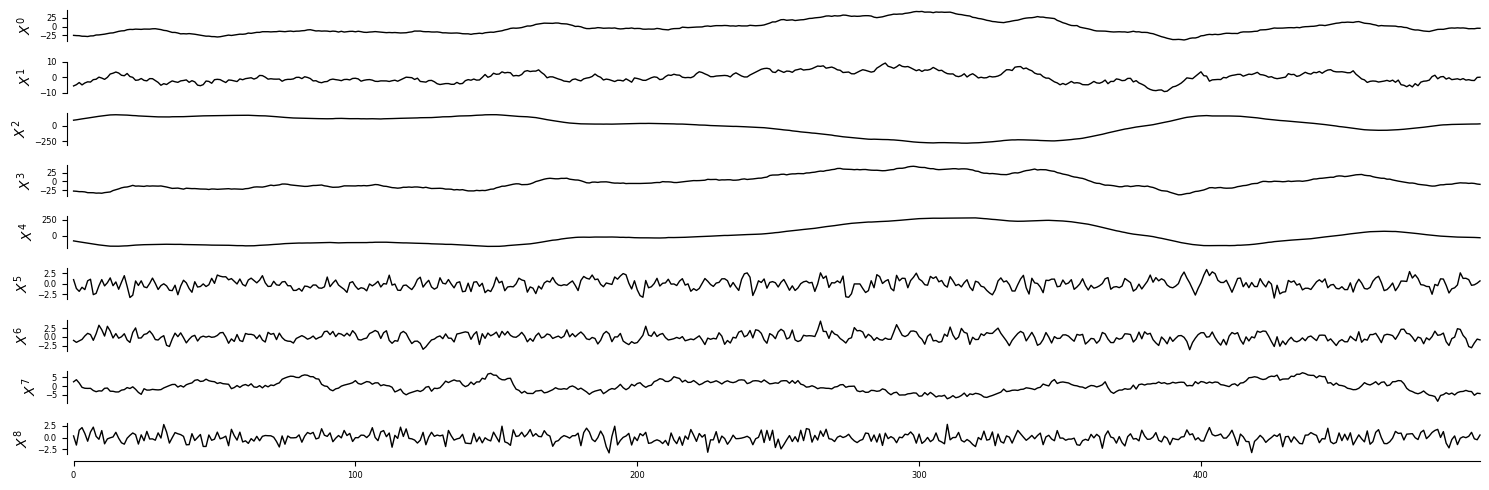

In [4]:
tp.plot_timeseries(dataframe, figsize=(15, 5)); plt.show()

Despite the high autocorrelation, it's stationary and doesn't contain missing values. Check the other tutorials for discussions of non-stationarity and missing values. 

Next, we choose a conditional independence test, here we assume linear dependencies with ``ParCorr`` implementing linear partial correlation. With ``significance='analytic'`` the null distribution is assumed to be Student's $t$. Then we initialize the ``PCMCI`` class that covers PCMCI as well as PCMCIplus with  ``dataframe`` and ``cond_ind_test``:

In [8]:
# parcorr = ParCorr(significance='analytic')
#pairwise = PairwiseMultCI(cond_ind_test = ParCorr())#PairwiseMultCI(cond_ind_test = ParCorr(significance='fixed_thres'))
# pairwise = PairwiseMultCI(cond_ind_test = ParCorr(significance='fixed_thres'), cond_ind_test_thres = 0.5, cond_ind_test_thres_pre = 1)
pairwise = PairwiseMultCI(alpha_pre = 0.5, sbo = 0.2, cond_ind_test = ParCorr(), significance = "fixed_thres")
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=pairwise,
    verbosity=1)

In [9]:
T = 100
x = np.random.normal(0, 1, T).reshape(T, 1)
y1 = np.random.normal(0, 1, T).reshape(T, 1)
y2 = 0 * x + y1 + 0.3 * np.random.normal(0, 1, T).reshape(T, 1)
z = np.random.normal(0, 1, T).reshape(T, 1)


test_result = pairwise.run_test_raw(x = x, y = np.hstack((y1,y2)), z = z)
print(test_result)

TypeError: bad operand type for abs(): 'NoneType'

In [41]:
paco = ParCorr(significance = "fixed_thres")
paco.run_test_raw(x, y2, z, alpha_or_thres = 0.2)

(0.4524551277146957, 0.0, True)

Before running PCMCIplus, it's a good idea to run and plot the function ``run_bivci``, which implements a bivariate, lagged conditional independence test (similar to bivariate Granger causality, but lag-specific). This can help to identify which maximal time lag ``tau_max`` to choose. Another option would be to plot ``get_lagged_dependencies``, but large autocorrelation will inflate lag peaks (see https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-13-00159.1) and ``run_bivci`` at least conditions out some part of the autocorrelation.


##
## Running Tigramite BivCI algorithm
##

Parameters:

independence test = pairwise_CI
tau_min = 0
tau_max = 10


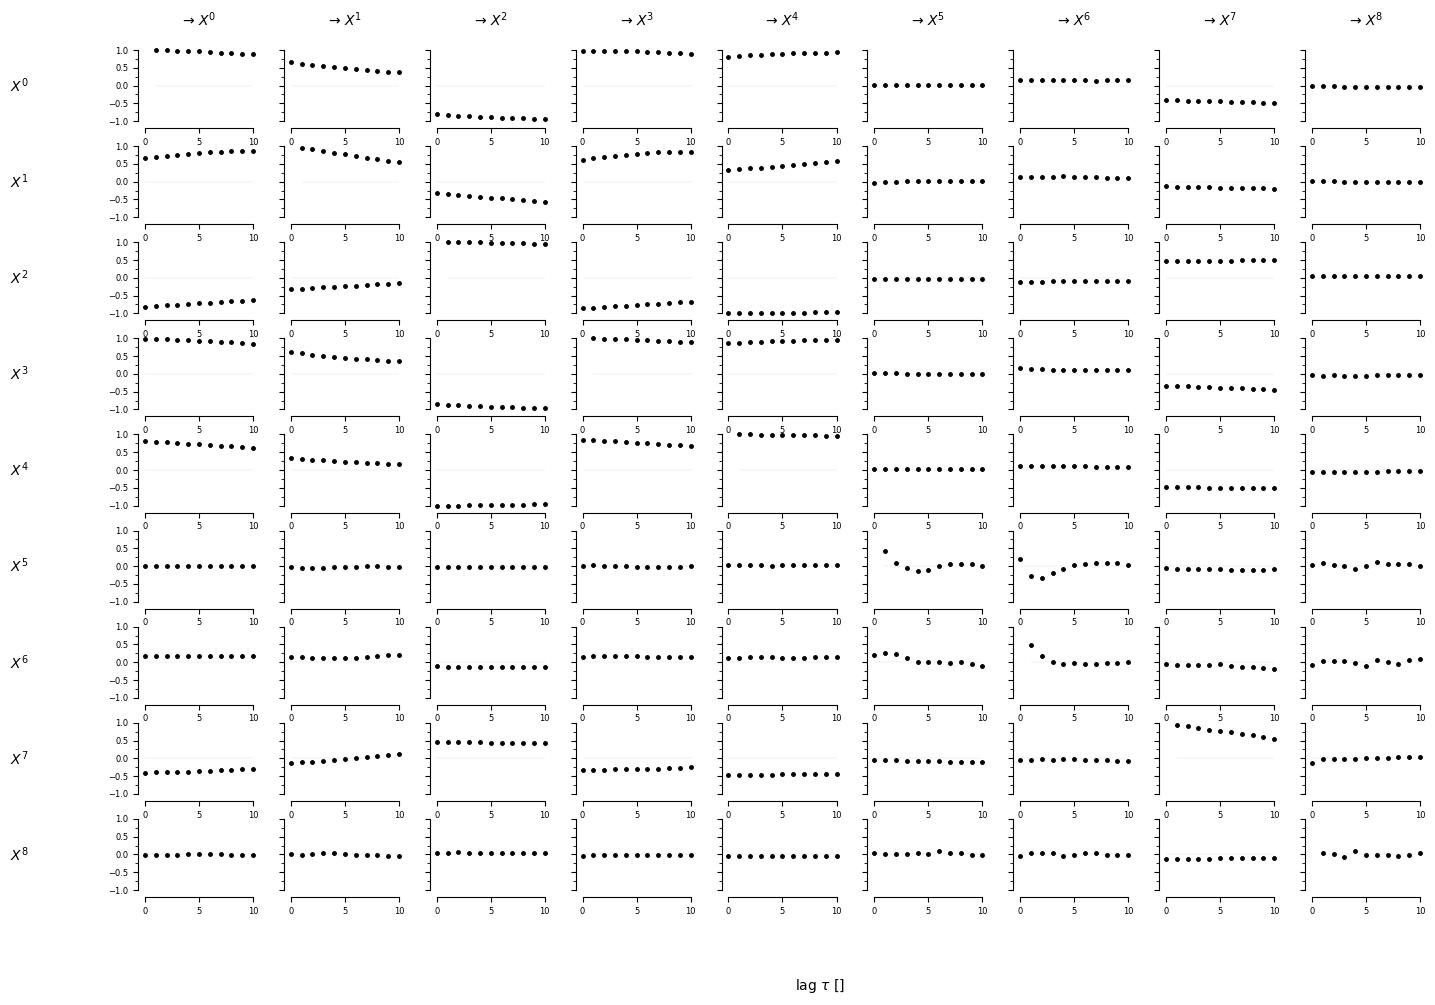

In [5]:
correlations = pcmci.run_bivci(tau_max=10, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, 
                                   setup_args={'var_names':var_names, 'figsize':(15, 10),
                                    'x_base':5, 'y_base':.5})

In [7]:
matrix_lags = np.argmax(np.abs(correlations), axis=2)
tp.plot_densityplots(dataframe=dataframe, setup_args={'figsize':(15, 10)}, add_densityplot_args={'matrix_lags':matrix_lags}); plt.show()

NameError: name 'correlations' is not defined

Since the dependencies peak maximally at a lag of around 3 in the lag function plot, we choose ``tau_max=3`` for PCMCIplus. This choice may, however, stronly depend on expert knowledge of the system. Obviously, for contemporaneous causal discovery, we leave the default ``tau_min=0``. The other main parameter is ``pc_alpha`` which sets the significance level for all tests in PCMCIplus. This is in contrast to PCMCI where ``pc_alpha`` only controls the significance tests in the condition-selection phase, not in the MCI tests. Also for PCMCIplus there is an automatic procedure (like for PCMCI) to choose the optimal value. If a list or None is passed for         ``pc_alpha``, the significance level is optimized for every graph across the given ``pc_alpha`` values using the score computed in ``cond_ind_test.get_model_selection_criterion()``. Since PCMCIplus outputs not a DAG, but an equivalence class of DAGs, first one member is of this class is computed and then the score is computed as the average over all models fits for each variable. The score is the same for all members of the class.

Here we set it to ``pc_alpha=0.01``. In applications a number of different values should be tested and results transparently discussed.

It is instructive to set ``verbosity=2`` and understand the output of PCMCIplus, after reading the paper and the pseudo-code. In the output contemporaneous adjacencies which are not oriented are marked by ``o--o`` and already oriented adjacencies by ``-->``.

In [10]:
tau_max = 3
pc_alpha = 0.01
pcmci.verbosity = 2

results = pcmci.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = pairwise_CI
tau_min = 1
tau_max = 3
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Variable $X^{0}$

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:

    Link ($X^{0}$ -1) -?> $X^{0}$ (1/27):
    Subset 0: () gives pval = 0.00000 / val =  0.997
    No conditions of dimension 0 left.

    Link ($X^{0}$ -2) -?> $X^{0}$ (2/27):
    Subset 0: () gives pval = 0.00000 / val =  0.991
    No conditions of dimension 0 left.

    Link ($X^{0}$ -3) -?> $X^{0}$ (3/27):
    Subset 0: () gives pval = 0.00000 / val =  0.983
    No conditions of dimension 0 left.

    Link ($X^{1}$ -1) -?> $X^{0}$ (4/27):
    Subset 0: () gives pval = 0.00000 / val =  0.699
    No conditions of dimension 0 left.

    Link ($X^{1}$ -2) -?> $X^{0}$ (5/27):
    Subset 0: () gives pval = 0.00000 / val =  0.736
    No conditions of dimension 0 left.

    Link ($X^

    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2)  gives pval = 0.00000 / val = -0.373
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link ($X^{7}$ -2) -?> $X^{0}$ (16/25):
    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2)  gives pval = 0.00000 / val = -0.376
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link ($X^{3}$ -1) -?> $X^{0}$ (17/25):
    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2)  gives pval = 0.00000 / val =  0.975
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link ($X^{7}$ -1) -?> $X^{0}$ (18/25):
    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2)  gives pval = 0.00000 / val = -0.379
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link ($X^{6}$ -3) -?> $X^{0}$ (19/25):
    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2)  gives pval = 0.00000 / val =  0.162
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link ($X^{8}$ -1) -?> $X^{0}$ (20/25):
    Subset 0: ($X^{0

    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2)  gives pval = 0.00000 / val =  0.765
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link ($X^{0}$ -3) -?> $X^{0}$ (5/23):
    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2)  gives pval = 0.00000 / val =  0.984
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link ($X^{0}$ -2) -?> $X^{0}$ (6/23):
    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{4}$ -3) ($X^{4}$ -2)  gives pval = 0.00000 / val =  0.991
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link ($X^{4}$ -3) -?> $X^{0}$ (7/23):
    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -2)  gives pval = 0.00000 / val =  0.773
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link ($X^{4}$ -2) -?> $X^{0}$ (8/23):
    Subset 0

    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3)  gives pval = 0.00000 / val =  0.974
    Still subsets of dimension 10 left, but q_max = 1 reached.

    Link ($X^{7}$ -1) -?> $X^{0}$ (18/23):
    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3)  gives pval = 0.00000 / val = -0.390
    Still subsets of dimension 10 left, but q_max = 1 reached.

    Link ($X^{6}$ -3) -?> $X^{0}$ (19/23):
    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3)  gives pval = 0.00000 / val =  0.168
    Still subsets of dimension 10 left, but q_max = 1 reached.

    Link ($X^{6}$ -2) -?> $X^{0}$ (20/23):
    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{

    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3)  gives pval = 0.00000 / val =  0.738
    Still subsets of dimension 14 left, but q_max = 1 reached.

    Link ($X^{1}$ -3) -?> $X^{0}$ (4/22):
    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3)  gives pval = 0.00000 / val =  0.766
    Still subsets of dimension 14 left, but q_max = 1 reached.

    Link ($X^{0}$ -3) -?> $X^{0}$ (5/22):
    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3)  gives pval = 0.00000 / val =  0.984
    Still subsets of dimension 14 left, but q_max = 1 reached.

    Link ($X^{0}$ -2) -?>

    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1)  gives pval = 0.00000 / val =  0.983
    Still subsets of dimension 17 left, but q_max = 1 reached.

    Link ($X^{0}$ -2) -?> $X^{0}$ (6/22):
    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1)  gives pval = 0.00000 / val =  0.991
    Still subsets of dimension 17 left, but q_max = 1 reached.

    Link ($X^{4}$ -3) -?> $X^{0}$ (7/22):
    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1)  gives pv

    Subset 0: ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -2)  gives pval = 0.00000 / val =  0.997
    Still subsets of dimension 20 left, but q_max = 1 reached.

    Link ($X^{1}$ -1) -?> $X^{0}$ (2/22):
    Subset 0: ($X^{0}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -2)  gives pval = 0.00000 / val =  0.705
    Still subsets of dimension 20 left, but q_max = 1 reached.

    Link ($X^{1}$ -2) -?> $X^{0}$ (3/22):
    Subset 0: ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ 

    Subset 0: ($X^{1}$ -1)  gives pval = 0.00000 / val = -0.049
    No conditions of dimension 1 left.

    Link ($X^{3}$ -2) -?> $X^{1}$ (7/26):
    Subset 0: ($X^{1}$ -1)  gives pval = 0.00000 / val = -0.045
    No conditions of dimension 1 left.

    Link ($X^{0}$ -3) -?> $X^{1}$ (8/26):
    Subset 0: ($X^{1}$ -1)  gives pval = 0.00000 / val = -0.043
    No conditions of dimension 1 left.

    Link ($X^{3}$ -3) -?> $X^{1}$ (9/26):
    Subset 0: ($X^{1}$ -1)  gives pval = 0.00000 / val = -0.041
    No conditions of dimension 1 left.

    Link ($X^{4}$ -1) -?> $X^{1}$ (10/26):
    Subset 0: ($X^{1}$ -1)  gives pval = 0.00000 / val = -0.026
    No conditions of dimension 1 left.

    Link ($X^{2}$ -1) -?> $X^{1}$ (11/26):
    Subset 0: ($X^{1}$ -1)  gives pval = 0.00000 / val =  0.026
    No conditions of dimension 1 left.

    Link ($X^{4}$ -2) -?> $X^{1}$ (12/26):
    Subset 0: ($X^{1}$ -1)  gives pval = 0.00000 / val = -0.025
    No conditions of dimension 1 left.

    Link ($X^{2}$

    Subset 0: ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2)  gives pval = 0.00000 / val =  0.258
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link ($X^{2}$ -3) -?> $X^{1}$ (18/21):
    Subset 0: ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2)  gives pval = 0.00000 / val = -0.257
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link ($X^{8}$ -3) -?> $X^{1}$ (19/21):
    Subset 0: ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2)  gives pval = 0.00000 / val =  0.025
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link ($X^{7}$ -2) -?> $X^{1}$ (20/21):
    Subset 0: ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2)  gives pval = 0.00000 / val = -0.127
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link ($X^{7}$ -1) -?> $X^{1}$ (21/21):
    Subset 0: ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2)  gives pval = 0.00000 / val = -0.136
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Subset 0: ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1)  gives pval = 0.00000 / val = -0.116
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^{1}$ has 21 link(s):

Testing condition sets of dimension 8:

    Link ($X^{1}$ -1) -?> $X^{1}$ (1/21):
    Subset 0: ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3)  gives pval = 0.00000 / val =  0.958
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link ($X^{1}$ -3) -?> $X^{1}$ (2/21):
    Subset 0: ($X^{1}$ -1) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3)  gives pval = 0.00000 / val =  0.869
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link ($X^{0}$ -1) -?> $X^{1}$ (3/21):
    Subset 0: ($X^{1}$ -1) ($X^{

    Subset 0: ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2)  gives pval = 0.00000 / val =  0.306
    Still subsets of dimension 11 left, but q_max = 1 reached.

    Link ($X^{6}$ -3) -?> $X^{1}$ (15/20):
    Subset 0: ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2)  gives pval = 0.00000 / val =  0.097
    Still subsets of dimension 11 left, but q_max = 1 reached.

    Link ($X^{2}$ -2) -?> $X^{1}$ (16/20):
    Subset 0: ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2)  gives pval = 0.00000 / val = -0.304
    Still subsets of dimension 11 left, but q_max = 1 reached.

    Link ($X^{4}$ -3) -?> $X^{1}$ (17/20):
    Subset 0: ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{

    Subset 0: ($X^{1}$ -1) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{6}$ -3) ($X^{2}$ -2)  gives pval = 0.00000 / val =  0.874
    Still subsets of dimension 15 left, but q_max = 1 reached.

    Link ($X^{0}$ -1) -?> $X^{1}$ (3/20):
    Subset 0: ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{6}$ -3) ($X^{2}$ -2)  gives pval = 0.00000 / val =  0.629
    Still subsets of dimension 15 left, but q_max = 1 reached.

    Link ($X^{0}$ -2) -?> $X^{1}$ (4/20):
    Subset 0: ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{6}$ -3) ($X^{2}$ -2)  gives pval = 0.00000 / val =  0.591
    Still subsets of dimension 15 left, but q_max 

    Subset 0: ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{6}$ -3) ($X^{2}$ -2) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{7}$ -2)  gives pval = 0.00000 / val =  0.547
    Still subsets of dimension 18 left, but q_max = 1 reached.

    Link ($X^{3}$ -3) -?> $X^{1}$ (9/20):
    Subset 0: ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{6}$ -2) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{6}$ -3) ($X^{2}$ -2) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{7}$ -2)  gives pval = 0.00000 / val =  0.517
    Still subsets of dimension 18 left, but q_max = 1 reached.

    Link ($X^{6}$ -2) -?> $X^{1}$ (10/20):
    Subset 0: ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{6}$ -3) ($X^{2}$ -2) ($X^{4}$

    Subset 0: ($X^{2}$ -1)  gives pval = 0.00000 / val = -0.794
    No conditions of dimension 1 left.

    Link ($X^{1}$ -2) -?> $X^{2}$ (17/27):
    Subset 0: ($X^{2}$ -1)  gives pval = 0.00000 / val = -0.761
    No conditions of dimension 1 left.

    Link ($X^{1}$ -1) -?> $X^{2}$ (18/27):
    Subset 0: ($X^{2}$ -1)  gives pval = 0.00000 / val = -0.715
    No conditions of dimension 1 left.

    Link ($X^{6}$ -3) -?> $X^{2}$ (19/27):
    Subset 0: ($X^{2}$ -1)  gives pval = 0.00000 / val = -0.118
    No conditions of dimension 1 left.

    Link ($X^{6}$ -2) -?> $X^{2}$ (20/27):
    Subset 0: ($X^{2}$ -1)  gives pval = 0.00000 / val = -0.091
    No conditions of dimension 1 left.

    Link ($X^{6}$ -1) -?> $X^{2}$ (21/27):
    Subset 0: ($X^{2}$ -1)  gives pval = 0.00000 / val = -0.119
    No conditions of dimension 1 left.

    Link ($X^{8}$ -2) -?> $X^{2}$ (22/27):
    Subset 0: ($X^{2}$ -1)  gives pval = 1.00000 / val = -0.008
    Non-significance detected.

    Link ($X^{8}$ -3) 

    Subset 0: ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -1) ($X^{0}$ -3)  gives pval = 0.00000 / val = -0.886
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link ($X^{3}$ -1) -?> $X^{2}$ (5/21):
    Subset 0: ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{0}$ -3)  gives pval = 0.00000 / val = -0.871
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link ($X^{0}$ -3) -?> $X^{2}$ (6/21):
    Subset 0: ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1)  gives pval = 0.00000 / val = -0.861
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link ($X^{0}$ -2) -?> $X^{2}$ (7/21):
    Subset 0: ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1)  gives pval = 0.00000 / val = -0.846
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link ($X^{4}$ -3) -?> $X^{2}$ (8/21):
    Subset 0: ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1)  gives pval = 0.00000 / val = -0.995


    Subset 0: ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3)  gives pval = 0.00000 / val = -0.098
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link ($X^{4}$ -1) -?> $X^{2}$ (21/21):
    Subset 0: ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3)  gives pval = 0.00000 / val = -0.999
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^{2}$ has 21 link(s):

Testing condition sets of dimension 9:

    Link ($X^{2}$ -3) -?> $X^{2}$ (1/21):
    Subset 0: ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1)  gives pval = 0.00000 / val =  0.996
    Still subsets of dimension 9 left, but q_max = 1 reached.

    Link ($X^{2}$ -2) -?> $X^{2}$ (2/21):
    S

    Subset 0: ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3)  gives pval = 0.00000 / val = -0.395
    Still subsets of dimension 12 left, but q_max = 1 reached.

    Link ($X^{1}$ -1) -?> $X^{2}$ (14/21):
    Subset 0: ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3)  gives pval = 0.00000 / val = -0.368
    Still subsets of dimension 12 left, but q_max = 1 reached.

    Link ($X^{7}$ -3) -?> $X^{2}$ (15/21):
    Subset 0: ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3)  gives pval = 0.00000 / val =  0.454
    Still subsets of dimension 12 left, but q_max = 1 reached.

    Link ($X^{7}$ -2) -?> $X^{2}$ (16/21):
    Subset 0: ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{

    Subset 0: ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1)  gives pval = 0.00000 / val = -0.888
    Still subsets of dimension 16 left, but q_max = 1 reached.

    Link ($X^{3}$ -1) -?> $X^{2}$ (5/21):
    Subset 0: ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1)  gives pval = 0.00000 / val = -0.874
    Still subsets of dimension 16 left, but q_max = 1 reached.

    Link ($X^{0}$ -3) -?> $X^{2}$ (6/21):
    Subset 0: ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1)  gives pval = 0.00000 / val = -0.864
    Still s

    Subset 0: ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1)  gives pval = 0.00000 / val =  0.999
    Still subsets of dimension 19 left, but q_max = 1 reached.

    Link ($X^{4}$ -2) -?> $X^{2}$ (11/21):
    Subset 0: ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1)  gives pval = 0.00000 / val = -0.998
    Still subsets of dimension 19 left, but q_max = 1 reached.

    Link ($X^{1}$ -3) -?> $X^{2}$ (12/21):
    Subset 0: ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}

    Subset 0: ($X^{3}$ -1) ($X^{1}$ -3)  gives pval = 0.00000 / val =  0.698
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^{1}$ -3) -?> $X^{3}$ (3/25):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2)  gives pval = 0.00000 / val =  0.735
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^{1}$ -1) -?> $X^{3}$ (4/25):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2)  gives pval = 0.00000 / val =  0.662
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^{3}$ -3) -?> $X^{3}$ (5/25):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2)  gives pval = 0.00000 / val =  0.984
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^{3}$ -2) -?> $X^{3}$ (6/25):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2)  gives pval = 0.00000 / val =  0.992
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^{2}$ -2) -?> $X^{3}$ (7/25):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2)  gives pval = 0.00000 / val = -0.825
    Still sub

    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3)  gives pval = 0.00000 / val =  0.974
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link ($X^{0}$ -2) -?> $X^{3}$ (18/24):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3)  gives pval = 0.00000 / val =  0.978
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link ($X^{6}$ -1) -?> $X^{3}$ (19/24):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3)  gives pval = 0.00000 / val =  0.169
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link ($X^{6}$ -2) -?> $X^{3}$ (20/24):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3)  gives pval = 0.00000 / val =  0.166
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link ($X^{8}$ -2) -?> $X^{3}$ (21/24):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3)  gives pval = 0.00000 / val = -0.

    Subset 0: ($X^{3}$ -1) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2)  gives pval = 0.00000 / val =  0.698
    Still subsets of dimension 9 left, but q_max = 1 reached.

    Link ($X^{1}$ -3) -?> $X^{3}$ (3/24):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2)  gives pval = 0.00000 / val =  0.734
    Still subsets of dimension 9 left, but q_max = 1 reached.

    Link ($X^{1}$ -1) -?> $X^{3}$ (4/24):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2)  gives pval = 0.00000 / val =  0.664
    Still subsets of dimension 9 left, but q_max = 1 reached.

    Link ($X^{3}$ -3) -?> $X^{3}$ (5/24):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2)  gives pval = 0.00000 / val =  0.984
    Still sub

    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{4}$ -3) ($X^{0}$ -1)  gives pval = 0.00000 / val =  0.984
    Still subsets of dimension 12 left, but q_max = 1 reached.

    Link ($X^{3}$ -2) -?> $X^{3}$ (6/23):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{4}$ -3) ($X^{0}$ -1)  gives pval = 0.00000 / val =  0.992
    Still subsets of dimension 12 left, but q_max = 1 reached.

    Link ($X^{2}$ -2) -?> $X^{3}$ (7/23):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{4}$ -3) ($X^{0}$ -1)  gives pval = 0.00000 / val = -0.831
    Still subsets of dimension 12 left, but q_max = 1 reached.

    Link ($X^{2}$ -1) -?> $X^{3}$ (8/23):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$

    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1)  gives pval = 0.00000 / val =  0.832
    Still subsets of dimension 15 left, but q_max = 1 reached.

    Link ($X^{4}$ -3) -?> $X^{3}$ (12/23):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1)  gives pval = 0.00000 / val =  0.797
    Still subsets of dimension 15 left, but q_max = 1 reached.

    Link ($X^{0}$ -1) -?> $X^{3}$ (13/23):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{4}$ -3) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1)  gives pval = 0.00000 / val =  0.979
    Still subsets of dimension 15 left, but q_ma

    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{4}$ -3) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{6}$ -1)  gives pval = 0.00000 / val =  0.979
    Still subsets of dimension 18 left, but q_max = 1 reached.

    Link ($X^{7}$ -3) -?> $X^{3}$ (14/23):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{6}$ -1)  gives pval = 0.00000 / val = -0.324
    Still subsets of dimension 18 left, but q_max = 1 reached.

    Link ($X^{7}$ -2) -?> $X^{3}$ (15/23):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{7}$ -3) ($X^{7}$ -1) ($X^{0}

    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{8}$ -2)  gives pval = 0.00000 / val = -0.804
    Still subsets of dimension 21 left, but q_max = 1 reached.

    Link ($X^{4}$ -2) -?> $X^{3}$ (10/23):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{8}$ -2)  gives pval = 0.00000 / val =  0.828
    Still subsets of dimension 21 left, but q_max = 1 reached.

    Link ($X^{4}$ -1) -?> $X^{3}$ (11/23):
    Subset 0: ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}

    Subset 0: () gives pval = 0.00000 / val =  0.998
    No conditions of dimension 0 left.

    Link ($X^{4}$ -3) -?> $X^{4}$ (15/27):
    Subset 0: () gives pval = 0.00000 / val =  0.996
    No conditions of dimension 0 left.

    Link ($X^{5}$ -1) -?> $X^{4}$ (16/27):
    Subset 0: () gives pval = 0.00000 / val =  0.032
    No conditions of dimension 0 left.

    Link ($X^{5}$ -2) -?> $X^{4}$ (17/27):
    Subset 0: () gives pval = 0.00000 / val =  0.032
    No conditions of dimension 0 left.

    Link ($X^{5}$ -3) -?> $X^{4}$ (18/27):
    Subset 0: () gives pval = 0.00000 / val =  0.033
    No conditions of dimension 0 left.

    Link ($X^{6}$ -1) -?> $X^{4}$ (19/27):
    Subset 0: () gives pval = 0.00000 / val =  0.110
    No conditions of dimension 0 left.

    Link ($X^{6}$ -2) -?> $X^{4}$ (20/27):
    Subset 0: () gives pval = 0.00000 / val =  0.115
    No conditions of dimension 0 left.

    Link ($X^{6}$ -3) -?> $X^{4}$ (21/27):
    Subset 0: () gives pval = 0.00000 / val =  0

    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3)  gives pval = 0.00000 / val =  0.861
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link ($X^{0}$ -1) -?> $X^{4}$ (9/27):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3)  gives pval = 0.00000 / val =  0.845
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link ($X^{4}$ -1) -?> $X^{4}$ (10/27):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3)  gives pval = 0.00000 / val =  1.000
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link ($X^{2}$ -2) -?> $X^{4}$ (11/27):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3)  gives pval = 0.00000 / val = -0.998
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link ($X^{1}$ -3) -?> $X^{4}$ (12/27):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3)  gives pval = 0.00000 / val =  0.410
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link ($X^{1}$ -2) -?> $X^{4}$ (13/27):
    Subset 0: ($X^{4}

    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3)  gives pval = 0.00000 / val =  0.851
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link ($X^{0}$ -1) -?> $X^{4}$ (9/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3)  gives pval = 0.00000 / val =  0.835
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link ($X^{4}$ -1) -?> $X^{4}$ (10/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3)  gives pval = 0.00000 / val =  1.000
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link ($X^{2}$ -2) -?> $X^{4}$ (11/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3)  gives pval = 0.00000 / val = -0.998
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link ($X^{1}$ -3) -?> $X^{4}$ (12/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$

    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1)  gives pval = 0.00000 / val =  0.884
    Still subsets of dimension 9 left, but q_max = 1 reached.

    Link ($X^{3}$ -1) -?> $X^{4}$ (5/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1)  gives pval = 0.00000 / val =  0.873
    Still subsets of dimension 9 left, but q_max = 1 reached.

    Link ($X^{0}$ -3) -?> $X^{4}$ (6/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1)  gives pval = 0.00000 / val =  0.864
    Still subsets of dimension 9 left, but q_max = 1 reached.

    Link ($X^{2}$ -3) -?> $X^{4}$ (7/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1)  gives pval = 0.00000 / val = -0.995
    Still sub

    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2)  gives pval = 0.00000 / val = -0.999
    Still subsets of dimension 11 left, but q_max = 1 reached.

    Link ($X^{8}$ -2) -?> $X^{4}$ (22/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2)  gives pval = 0.00000 / val = -0.047
    Still subsets of dimension 11 left, but q_max = 1 reached.

    Link ($X^{8}$ -3) -?> $X^{4}$ (23/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2)  gives pval = 0.00000 / val = -0.057
    Still subsets of dimension 11 left, but q_max = 1 reached.

    Link ($X^{8}$ -1) -?> $X^{4}$ (24/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{

    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3)  gives pval = 0.00000 / val =  0.854
    Still subsets of dimension 14 left, but q_max = 1 reached.

    Link ($X^{0}$ -1) -?> $X^{4}$ (9/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3)  gives pval = 0.00000 / val =  0.839
    Still subsets of dimension 14 left, but q_max = 1 reached.

    Link ($X^{4}$ -1) -?> $X^{4}$ (10/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3)  gives pval = 0.00000 / val =  1.000
    Still subsets of dimension 14 left, but q_max = 1 reached.

    Link ($X^{2}$ -2) -?

    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2)  gives pval = 0.00000 / val =  0.107
    Still subsets of dimension 16 left, but q_max = 1 reached.

    Link ($X^{6}$ -1) -?> $X^{4}$ (20/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2)  gives pval = 0.00000 / val =  0.101
    Still subsets of dimension 16 left, but q_max = 1 reached.

    Link ($X^{2}$ -1) -?> $X^{4}$ (21/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2)  gives pval = 0.00000 / val = -0.999
    Still

    Subset 0: ($X^{4}$ -3) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1)  gives pval = 0.00000 / val =  0.998
    Still subsets of dimension 19 left, but q_max = 1 reached.

    Link ($X^{3}$ -3) -?> $X^{4}$ (3/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1)  gives pval = 0.00000 / val =  0.900
    Still subsets of dimension 19 left, but q_max = 1 reached.

    Link ($X^{3}$ -2) -?> $X^{4}$ (4/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ 

    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2)  gives pval = 0.00000 / val =  0.866
    Still subsets of dimension 21 left, but q_max = 1 reached.

    Link ($X^{2}$ -3) -?> $X^{4}$ (7/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2)  gives pval = 0.00000 / val = -0.995
    Still subsets of dimension 21 left, but q_max = 1 reached.

    Link ($X^{0}$ -2) -?> $X^{4}$ (8/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ 

    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{8}$ -2) ($X^{8}$ -3)  gives pval = 0.00000 / val = -0.999
    Still subsets of dimension 22 left, but q_max = 1 reached.

    Link ($X^{8}$ -2) -?> $X^{4}$ (22/25):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -3)  gives pval = 0.00000 / val = -0.079
    Still subsets of dimension 22 left, but q_max = 1 reached.

    Link ($X^{8}$ -3) -?> $X^{4}$ (23/25):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}

    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1)  gives pval = 0.00000 / val =  0.902
    Still subsets of dimension 24 left, but q_max = 1 reached.

    Link ($X^{3}$ -2) -?> $X^{4}$ (4/25):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1)  gives pval = 0.00000 / val =  0.889
    Still subsets of dimension 24 left, but q_max = 1 reached.

    Link ($X^{3}$ -1) -?> $X^{4}$ (5/25):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ 

    Subset 0: () gives pval = 0.00000 / val =  0.016
    No conditions of dimension 0 left.

    Link ($X^{0}$ -3) -?> $X^{5}$ (3/27):
    Subset 0: () gives pval = 0.00000 / val =  0.021
    No conditions of dimension 0 left.

    Link ($X^{1}$ -1) -?> $X^{5}$ (4/27):
    Subset 0: () gives pval = 0.00000 / val = -0.014
    No conditions of dimension 0 left.

    Link ($X^{1}$ -2) -?> $X^{5}$ (5/27):
    Subset 0: () gives pval = 1.00000 / val =  0.001
    Non-significance detected.

    Link ($X^{1}$ -3) -?> $X^{5}$ (6/27):
    Subset 0: () gives pval = 0.00000 / val =  0.010
    No conditions of dimension 0 left.

    Link ($X^{2}$ -1) -?> $X^{5}$ (7/27):
    Subset 0: () gives pval = 0.00000 / val = -0.031
    No conditions of dimension 0 left.

    Link ($X^{2}$ -2) -?> $X^{5}$ (8/27):
    Subset 0: () gives pval = 0.00000 / val = -0.031
    No conditions of dimension 0 left.

    Link ($X^{2}$ -3) -?> $X^{5}$ (9/27):
    Subset 0: () gives pval = 0.00000 / val = -0.032
    No con

    Subset 0: ($X^{5}$ -1) ($X^{6}$ -1)  gives pval = 0.00000 / val =  0.012
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^{5}$ has 20 link(s):

Testing condition sets of dimension 3:

    Link ($X^{5}$ -1) -?> $X^{5}$ (1/20):
    Subset 0: ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2)  gives pval = 0.00000 / val =  0.421
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link ($X^{6}$ -1) -?> $X^{5}$ (2/20):
    Subset 0: ($X^{5}$ -1) ($X^{6}$ -2) ($X^{5}$ -2)  gives pval = 0.00000 / val =  0.272
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link ($X^{6}$ -2) -?> $X^{5}$ (3/20):
    Subset 0: ($X^{5}$ -1) ($X^{6}$ -1) ($X^{5}$ -2)  gives pval = 0.00000 / val =  0.231
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link ($X^{5}$ -2) -?> $X^{5}$ (4/20):
    Subset 0: ($X^{5}$ -1) ($X^{

    Subset 0: ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3)  gives pval = 0.00000 / val =  0.025
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link ($X^{8}$ -2) -?> $X^{5}$ (18/20):
    Subset 0: ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3)  gives pval = 0.00000 / val =  0.013
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link ($X^{3}$ -1) -?> $X^{5}$ (19/20):
    Subset 0: ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3)  gives pval = 0.00000 / val =  0.022
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link ($X^{0}$ -2) -?> $X^{5}$ (20/20):
    Subset 0: ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3)  gives pval = 0.00000 / val =  0.020
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 


    Subset 0: ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3)  gives pval = 0.00000 / val = -0.063
    Still subsets of dimension 10 left, but q_max = 1 reached.

    Link ($X^{7}$ -1) -?> $X^{5}$ (7/20):
    Subset 0: ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3)  gives pval = 0.00000 / val = -0.071
    Still subsets of dimension 10 left, but q_max = 1 reached.

    Link ($X^{7}$ -2) -?> $X^{5}$ (8/20):
    Subset 0: ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3)  gives pval = 0.00000 / val = -0.063
    Still subsets of dimension 10 left, but q_max = 1 reached.

    Link ($X^{6}$ -3) -?> $X^{5}$ (9/20):
    Subset 0: ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{4}$ -3) ($X^{2}$

    Subset 0: ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{2}$ -2)  gives pval = 0.00000 / val = -0.038
    Still subsets of dimension 13 left, but q_max = 1 reached.

    Link ($X^{4}$ -2) -?> $X^{5}$ (12/18):
    Subset 0: ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -2)  gives pval = 0.00000 / val =  0.033
    Still subsets of dimension 13 left, but q_max = 1 reached.

    Link ($X^{4}$ -1) -?> $X^{5}$ (13/18):
    Subset 0: ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{2}$ -2)  gives pval = 0.00000 / val =  0.031
    Still subsets of dimension 13 left, but q_max = 1 reached.

    Link ($X^{2}$ -2) -?> $X^{5}$ (14/18):
    Subset 0: ($X^{

    Subset 0: ($X^{6}$ -1)  gives pval = 0.00000 / val =  0.086
    No conditions of dimension 1 left.

    Link ($X^{3}$ -1) -?> $X^{6}$ (10/26):
    Subset 0: ($X^{6}$ -1)  gives pval = 0.00000 / val =  0.078
    No conditions of dimension 1 left.

    Link ($X^{1}$ -1) -?> $X^{6}$ (11/26):
    Subset 0: ($X^{6}$ -1)  gives pval = 0.00000 / val =  0.074
    No conditions of dimension 1 left.

    Link ($X^{1}$ -2) -?> $X^{6}$ (12/26):
    Subset 0: ($X^{6}$ -1)  gives pval = 0.00000 / val =  0.076
    No conditions of dimension 1 left.

    Link ($X^{3}$ -2) -?> $X^{6}$ (13/26):
    Subset 0: ($X^{6}$ -1)  gives pval = 0.00000 / val =  0.071
    No conditions of dimension 1 left.

    Link ($X^{3}$ -3) -?> $X^{6}$ (14/26):
    Subset 0: ($X^{6}$ -1)  gives pval = 0.00000 / val =  0.065
    No conditions of dimension 1 left.

    Link ($X^{4}$ -1) -?> $X^{6}$ (15/26):
    Subset 0: ($X^{6}$ -1)  gives pval = 0.00000 / val =  0.059
    No conditions of dimension 1 left.

    Link ($X^{

    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3)  gives pval = 0.00000 / val = -0.093
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link ($X^{2}$ -3) -?> $X^{6}$ (21/24):
    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3)  gives pval = 0.00000 / val = -0.089
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link ($X^{7}$ -1) -?> $X^{6}$ (22/24):
    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3)  gives pval = 0.00000 / val = -0.033
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link ($X^{8}$ -2) -?> $X^{6}$ (23/24):
    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3)  gives pval = 0.00000 / val =  0.055
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link ($X^{7}$ -3) -?> $X^{6}$ (24/24):
    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3)  gives pval = 0.00000 / val = -0.022
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{3}$ -1) ($X^{1}$ -2)  gives pval = 0.00000 / val =  0.142
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link ($X^{3}$ -1) -?> $X^{6}$ (8/24):
    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{1}$ -2)  gives pval = 0.00000 / val =  0.135
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link ($X^{1}$ -2) -?> $X^{6}$ (9/24):
    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1)  gives pval = 0.00000 / val =  0.128
    Still subsets of dimension 8 left, but q_max = 1 reached.

    Link ($X^{1}$ -1) -?> $X^{6}$ (10/24):
    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1)  gives pval = 0.00000 / val =  0.130
    Still subsets of dimension 8 left, but q_max = 1 reached.

 

    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2)  gives pval = 0.00000 / val =  0.100
    Still subsets of dimension 11 left, but q_max = 1 reached.

    Link ($X^{2}$ -1) -?> $X^{6}$ (17/22):
    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2)  gives pval = 0.00000 / val = -0.100
    Still subsets of dimension 11 left, but q_max = 1 reached.

    Link ($X^{4}$ -3) -?> $X^{6}$ (18/22):
    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2)  gives pval = 0.00000 / val =  0.097
    Still subsets of dimension 11 left, but q_max = 1 reached.

    Link ($X^{2}$ -2) -?> $X^{6}$ (19/22):
    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{

    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1)  gives pval = 0.00000 / val =  0.056
    Still subsets of dimension 14 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^{6}$ has 22 link(s):

Testing condition sets of dimension 15:

    Link ($X^{6}$ -1) -?> $X^{6}$ (1/22):
    Subset 0: ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{4}$ -2)  gives pval = 0.00000 / val =  0.459
    Still subsets of dimension 15 left, but q_max = 1 reached.

    Link ($X^{5}$ -1) -?> $X^{6}$ (2/22):
    Subset 0: ($X^{6}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($

    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{4}$ -2) ($X^{2}$ -1)  gives pval = 0.00000 / val = -0.094
    Still subsets of dimension 17 left, but q_max = 1 reached.

    Link ($X^{2}$ -3) -?> $X^{6}$ (20/22):
    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{4}$ -2) ($X^{2}$ -1)  gives pval = 0.00000 / val = -0.091
    Still subsets of dimension 17 left, but q_max = 1 reached.

    Link ($X^{8}$ -1) -?> $X^{6}$ (21/22):
    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{4}$ -2) ($X^{2}$ -1)  gives 

    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{4}$ -2) ($X^{2}$ -1) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{8}$ -1)  gives pval = 0.00000 / val =  0.107
    Still subsets of dimension 20 left, but q_max = 1 reached.

    Link ($X^{5}$ -3) -?> $X^{6}$ (15/22):
    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{2}$ -1) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{8}$ -1)  gives pval = 0.00000 / val = -0.203
    Still subsets of dimension 20 left, but q_max = 1 reached.

    Link ($X^{4}$ -2) -?> $X^{6}$ (16/22):
    Subset 0: ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}

    Subset 0: ($X^{7}$ -1)  gives pval = 0.00000 / val =  0.015
    No conditions of dimension 1 left.

    Link ($X^{5}$ -3) -?> $X^{7}$ (22/27):
    Subset 0: ($X^{7}$ -1)  gives pval = 0.00000 / val = -0.019
    No conditions of dimension 1 left.

    Link ($X^{5}$ -1) -?> $X^{7}$ (23/27):
    Subset 0: ($X^{7}$ -1)  gives pval = 0.00000 / val = -0.064
    No conditions of dimension 1 left.

    Link ($X^{6}$ -3) -?> $X^{7}$ (24/27):
    Subset 0: ($X^{7}$ -1)  gives pval = 0.00000 / val = -0.016
    No conditions of dimension 1 left.

    Link ($X^{5}$ -2) -?> $X^{7}$ (25/27):
    Subset 0: ($X^{7}$ -1)  gives pval = 1.00000 / val = -0.001
    Non-significance detected.

    Link ($X^{6}$ -2) -?> $X^{7}$ (26/27):
    Subset 0: ($X^{7}$ -1)  gives pval = 0.00000 / val = -0.045
    No conditions of dimension 1 left.

    Link ($X^{6}$ -1) -?> $X^{7}$ (27/27):
    Subset 0: ($X^{7}$ -1)  gives pval = 0.00000 / val = -0.060
    No conditions of dimension 1 left.

    Sorting parents in

    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1)  gives pval = 0.00000 / val = -0.098
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Link ($X^{6}$ -1) -?> $X^{7}$ (26/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1)  gives pval = 0.00000 / val = -0.041
    Still subsets of dimension 4 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^{7}$ has 26 link(s):

Testing condition sets of dimension 5:

    Link ($X^{7}$ -1) -?> $X^{7}$ (1/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3)  gives pval = 0.00000 / val =  0.940
    Still subsets of dimension 5 left, but q_max = 1 reached.

    Link ($X^{4}$ -3) -?> $X^{7}$ (2/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3)  gives pval = 0.00000 / val = -0.482
    Still subsets of dimension 5 left, but q_

    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3)  gives pval = 0.00000 / val = -0.067
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link ($X^{6}$ -3) -?> $X^{7}$ (24/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3)  gives pval = 0.00000 / val = -0.062
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link ($X^{8}$ -2) -?> $X^{7}$ (25/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3)  gives pval = 0.00000 / val = -0.105
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Link ($X^{6}$ -1) -?> $X^{7}$ (26/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3)  gives pval = 0.00000 / val = -0.043
    Still subsets of dimension 7 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    w

    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1)  gives pval = 0.00000 / val = -0.060
    Still subsets of dimension 10 left, but q_max = 1 reached.

    Link ($X^{5}$ -3) -?> $X^{7}$ (23/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1)  gives pval = 0.00000 / val = -0.085
    Still subsets of dimension 10 left, but q_max = 1 reached.

    Link ($X^{6}$ -3) -?> $X^{7}$ (24/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1)  gives pval = 0.00000 / val = -0.069
    Still subsets of dimension 10 left, but q_max = 1 reached.

    Link ($X^{8}$ -2) -?> $X^{7}$ (25/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{

    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{5}$ -1)  gives pval = 0.00000 / val = -0.329
    Still subsets of dimension 13 left, but q_max = 1 reached.

    Link ($X^{5}$ -1) -?> $X^{7}$ (14/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1)  gives pval = 0.00000 / val = -0.088
    Still subsets of dimension 13 left, but q_max = 1 reached.

    Link ($X^{7}$ -3) -?> $X^{7}$ (15/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1)  gives pval = 0.00000 / val =  0.843
    Still subsets of dimension 13 left, but q_max = 1 reached.

    Link ($X^{7}$ -2) -?> $X^{7}$ (16/26):
    Subset 0: ($X^{

    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2)  gives pval = 0.00000 / val = -0.474
    Still subsets of dimension 16 left, but q_max = 1 reached.

    Link ($X^{4}$ -1) -?> $X^{7}$ (4/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2)  gives pval = 0.00000 / val = -0.474
    Still subsets of dimension 16 left, but q_max = 1 reached.

    Link ($X^{0}$ -2) -?> $X^{7}$ (5/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2)  gives pval = 0.00000 / val = -0.416
    Still s

    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{8}$ -1)  gives pval = 0.00000 / val = -0.156
    Still subsets of dimension 18 left, but q_max = 1 reached.

    Link ($X^{8}$ -1) -?> $X^{7}$ (19/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3)  gives pval = 0.00000 / val = -0.113
    Still subsets of dimension 18 left, but q_max = 1 reached.

    Link ($X^{1}$ -1) -?> $X^{7}$ (20/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}

    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2)  gives pval = 0.00000 / val = -0.463
    Still subsets of dimension 21 left, but q_max = 1 reached.

    Link ($X^{4}$ -1) -?> $X^{7}$ (4/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2)  gives pval = 0.00000 / val = -0.459
    Still subsets of dimension 21 left, but q_max = 1 reached.

    Link ($X^{0}$ -2) -?> $X^{7}$ (5/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ 

    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{6}$ -2) ($X^{5}$ -3)  gives pval = 0.00000 / val = -0.093
    Still subsets of dimension 22 left, but q_max = 1 reached.

    Link ($X^{6}$ -2) -?> $X^{7}$ (22/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{5}$ -3)  gives pval = 0.00000 / val = -0.072
    Still subsets of dimension 22 left, but q_max = 1 reached.

    Link ($X^{5}$ -3) -?> $X^{7}$ (23/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}

    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3)  gives pval = 0.00000 / val = -0.081
    Still subsets of dimension 23 left, but q_max = 1 reached.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^{7}$ has 26 link(s):

Testing condition sets of dimension 24:

    Link ($X^{7}$ -1) -?> $X^{7}$ (1/26):
    Subset 0: ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2)  gives pval = 0.

    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1)  gives pval = 0.00000 / val = -0.464
    Still subsets of dimension 25 left, but q_max = 1 reached.

    Link ($X^{0}$ -2) -?> $X^{7}$ (5/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1)  gives pval = 0.00000 / val = -0.412
    Still subsets of dimension 25 left, but q_max = 1 reached.

    Link ($X^{0}$ -3) -?> $X^{7}$ (6/26):
    Subset 0: ($X^{7}$ -1) ($X^{4}$ 

    Subset 0: () gives pval = 0.00000 / val =  0.056
    No conditions of dimension 0 left.

    Link ($X^{2}$ -2) -?> $X^{8}$ (8/27):
    Subset 0: () gives pval = 0.00000 / val =  0.056
    No conditions of dimension 0 left.

    Link ($X^{2}$ -3) -?> $X^{8}$ (9/27):
    Subset 0: () gives pval = 0.00000 / val =  0.056
    No conditions of dimension 0 left.

    Link ($X^{3}$ -1) -?> $X^{8}$ (10/27):
    Subset 0: () gives pval = 0.00000 / val = -0.051
    No conditions of dimension 0 left.

    Link ($X^{3}$ -2) -?> $X^{8}$ (11/27):
    Subset 0: () gives pval = 0.00000 / val = -0.050
    No conditions of dimension 0 left.

    Link ($X^{3}$ -3) -?> $X^{8}$ (12/27):
    Subset 0: () gives pval = 0.00000 / val = -0.052
    No conditions of dimension 0 left.

    Link ($X^{4}$ -1) -?> $X^{8}$ (13/27):
    Subset 0: () gives pval = 0.00000 / val = -0.054
    No conditions of dimension 0 left.

    Link ($X^{4}$ -2) -?> $X^{8}$ (14/27):
    Subset 0: () gives pval = 0.00000 / val = -0.0

    Subset 0: ($X^{8}$ -3) ($X^{5}$ -1)  gives pval = 1.00000 / val = -0.005
    Non-significance detected.

    Link ($X^{1}$ -2) -?> $X^{8}$ (24/25):
    Subset 0: ($X^{8}$ -3) ($X^{5}$ -1)  gives pval = 0.00000 / val =  0.012
    Still subsets of dimension 2 left, but q_max = 1 reached.

    Link ($X^{5}$ -3) -?> $X^{8}$ (25/25):
    Subset 0: ($X^{8}$ -3) ($X^{5}$ -1)  gives pval = 1.00000 / val = -0.001
    Non-significance detected.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable $X^{8}$ has 22 link(s):

Testing condition sets of dimension 3:

    Link ($X^{8}$ -3) -?> $X^{8}$ (1/22):
    Subset 0: ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1)  gives pval = 0.00000 / val = -0.087
    Still subsets of dimension 3 left, but q_max = 1 reached.

    Link ($X^{5}$ -1) -?> $X^{8}$ (2/22):
    Subset 0: ($X^{8}$ -3) ($X^{6}$ -1) ($X^{2}$ -1)  gives pval = 0.00000 / val =  0.059
    Still subsets of dimensi

    Subset 0: ($X^{8}$ -3) ($X^{5}$ -1) ($X^{2}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -3)  gives pval = 0.00000 / val = -0.042
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link ($X^{0}$ -2) -?> $X^{8}$ (16/20):
    Subset 0: ($X^{8}$ -3) ($X^{5}$ -1) ($X^{2}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -3)  gives pval = 0.00000 / val = -0.039
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link ($X^{1}$ -1) -?> $X^{8}$ (17/20):
    Subset 0: ($X^{8}$ -3) ($X^{5}$ -1) ($X^{2}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -3)  gives pval = 0.00000 / val =  0.034
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link ($X^{6}$ -3) -?> $X^{8}$ (18/20):
    Subset 0: ($X^{8}$ -3) ($X^{5}$ -1) ($X^{2}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -3)  gives pval = 0.00000 / val =  0.018
    Still subsets of dimension 6 left, but q_max = 1 reached.

    Link ($X^{8}$ -1) -?> $X^{8}$ (19/20):
    Subset 0: ($X^{8}$ -3) ($X^{5}$ -1) ($X^{2}$ -2) ($X^{6}

    Subset 0: ($X^{8}$ -3) ($X^{5}$ -1) ($X^{2}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{6}$ -2) ($X^{3}$ -3)  gives pval = 0.00000 / val = -0.050
    Still subsets of dimension 10 left, but q_max = 1 reached.

    Link ($X^{6}$ -2) -?> $X^{8}$ (10/18):
    Subset 0: ($X^{8}$ -3) ($X^{5}$ -1) ($X^{2}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{3}$ -3)  gives pval = 0.00000 / val =  0.046
    Still subsets of dimension 10 left, but q_max = 1 reached.

    Link ($X^{3}$ -3) -?> $X^{8}$ (11/18):
    Subset 0: ($X^{8}$ -3) ($X^{5}$ -1) ($X^{2}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{6}$ -2)  gives pval = 0.00000 / val = -0.043
    Still subsets of dimension 10 left, but q_max = 1 reached.

    Link ($X^{3}$ -1) -?> $X^{8}$ (12/18):
    Subset 0: ($X^{8}$ -3) ($X^{5}$ -1) ($X^{2}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{

    Subset 0: ($X^{8}$ -3) ($X^{5}$ -1) ($X^{2}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{6}$ -2) ($X^{3}$ -3) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -3) ($X^{1}$ -1)  gives pval = 0.00000 / val = -0.056
    Still subsets of dimension 14 left, but q_max = 1 reached.

    Link ($X^{4}$ -2) -?> $X^{8}$ (8/18):
    Subset 0: ($X^{8}$ -3) ($X^{5}$ -1) ($X^{2}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{4}$ -1) ($X^{6}$ -2) ($X^{3}$ -3) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -3) ($X^{1}$ -1)  gives pval = 0.00000 / val = -0.056
    Still subsets of dimension 14 left, but q_max = 1 reached.

    Link ($X^{4}$ -1) -?> $X^{8}$ (9/18):
    Subset 0: ($X^{8}$ -3) ($X^{5}$ -1) ($X^{2}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{6}$ -2) ($X^{3}$ -3) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -3) ($X^{1}$ -1)  gives pval = 0.00000 / val = -0.056
    Still subsets of dimension 14 left, but q_max = 1 reached.

    Link ($X^{6}$ -2) -?>

    Subset 0: () gives pval = 0.00000 / val =  0.997
    No conditions of dimension 0 left.

    Link ($X^{0}$ -2) -?> $X^{0}$ (2/264):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{0}$ -3) ($X^{1}$ -3) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{0}$ -5) ($X^{0}$ -4) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{3}$ -3) ($X^{7}$ -3) ($X^{6}$ -5) ($X^{6}$ -4) ($X^{8}$ -3) ($X^{8}$ -4) ]
    Subset 0: () gives pval = 0.00000 / val =  0.992
    No conditions of dimension 0 left.

    Link ($X^{0}$ -3) -?> $X^{0}$ (3/264):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{0

    Subset 0: () gives pval = 0.00000 / val = -0.438
    No conditions of dimension 0 left.

    Link ($X^{0}$ -3) -?> $X^{7}$ (28/264):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{0}$ -4) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{0}$ -6) ($X^{0}$ -5) ($X^{4}$ -6) ($X^{4}$ -5) ($X^{2}$ -5) ($X^{2}$ -6) ($X^{4}$ -4) ($X^{2}$ -4) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{7}$ -6) ($X^{7}$ -5) ($X^{3}$ -4) ($X^{7}$ -4) ($X^{6}$ -6) ($X^{6}$ -5) ($X^{8}$ -4) ($X^{8}$ -5) ]
    Subset 0: () gives pval = 0.00000 / val = -0.419
    No conditions of dimension 0 left.

    Link ($X^{0}$  0) o?o $X^{8}$ (29/264):
    Iterate through 1

    Subset 0: () gives pval = 0.00000 / val =  0.156
    No conditions of dimension 0 left.

    Link ($X^{1}$ -2) -?> $X^{6}$ (55/264):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{4}$ -2) ($X^{2}$ -1) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{1}$ -3) ($X^{1}$ -5) ($X^{0}$ -3) ($X^{0}$ -4) ($X^{7}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{0}$ -5) ($X^{3}$ -5) ($X^{6}$ -4) ($X^{1}$ -4) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{4}$ -4) ($X^{6}$ -5) ($X^{2}$ -4) ($X^{4}$ -5) ($X^{2}$ -5) ($X^{7}$ -4) ($X^{7}$ -3) ]
    Subset 0: () gives pval = 0.00000 / val =  0.114
    No conditions of dimension 0 left.

    Link ($X^{1}$ -3) -?> $X^{6}$ (56/264):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{6}$ -1) ($X^{5}$ -1) ($X^

    Subset 0: () gives pval = 0.00000 / val = -0.050
    No conditions of dimension 0 left.

    Link ($X^{2}$ -1) -?> $X^{5}$ (82/264):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{8}$ -3) ]
    with conds_x = [ ($X^{2}$ -4) ($X^{2}$ -3) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{0}$ -4) ($X^{0}$ -3) ($X^{4}$ -4) ($X^{0}$ -2) ($X^{2}$ -2) ($X^{4}$ -3) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{6}$ -4) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{4}$ -2) ]
    Subset 0: () gives pval = 0.00000 / val = -0.015
    No conditions of dimension 0 left.

    Link ($X^{2}$ -2) -?> $X^{5}$ (83/264):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^

    Subset 0: () gives pval = 0.00000 / val =  0.542
    No conditions of dimension 0 left.

    Link ($X^{3}$  0) o?o $X^{2}$ (105/264):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{8}$ -1) ]
    Subset 0: () gives pval = 0.00000 / val = -0.858
    No conditions of dimension 0 left.

    Link ($X^{3}$ -1) -?> $X^{2}$ (106/264):
    Iterate through 1 subset(s) of conditions: 
    with c

    Subset 0: () gives pval = 0.00000 / val = -0.336
    No conditions of dimension 0 left.

    Link ($X^{3}$ -3) -?> $X^{7}$ (124/264):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{3}$ -4) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{1}$ -4) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{2}$ -5) ($X^{2}$ -4) ($X^{2}$ -6) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{4}$ -6) ($X^{0}$ -4) ($X^{7}$ -6) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{0}$ -6) ($X^{0}$ -5) ($X^{6}$ -4) ($X^{6}$ -5) ($X^{6}$ -6) ($X^{8}$ -5) ($X^{8}$ -4) ]
    Subset 0: () gives pval = 0.00000 / val = -0.353
    No conditions of dimension 0 left.

    Link ($X^{3}$  0) o?o $X^{8}$ (125/264):
    It

    Subset 0: () gives pval = 0.00000 / val =  0.831
    No conditions of dimension 0 left.

    Link ($X^{4}$ -3) -?> $X^{3}$ (144/264):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{8}$ -1) ]
    with conds_x = [ ($X^{4}$ -6) ($X^{4}$ -5) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{0}$ -6) ($X^{2}$ -6) ($X^{0}$ -5) ($X^{0}$ -4) ($X^{4}$ -4) ($X^{2}$ -5) ($X^{1}$ -6) ($X^{1}$ -5) ($X^{1}$ -4) ($X^{7}$ -6) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{6}$ -6) ($X^{6}$ -5) ($X^{6}$ -4) ($X^{2}$ -4) ($X^{8}$ -5) ($X^{8}$ -6) ($X^{8}$ -4) ($X^{5}$ -4) ]
    Subset 0: () gives pval = 0.00000 / val =  0.815
    No conditions of dimension 0 left.

    Link ($X^{4}$ -1) -?> $X^{4}$ (145/264):
    Iterate through

    Subset 0: () gives pval = 0.00000 / val =  0.025
    No conditions of dimension 0 left.

    Link ($X^{5}$ -1) -?> $X^{5}$ (170/264):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{8}$ -3) ]
    with conds_x = [ ($X^{5}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{5}$ -3) ($X^{7}$ -4) ($X^{5}$ -4) ($X^{7}$ -2) ($X^{7}$ -3) ($X^{6}$ -4) ($X^{4}$ -4) ($X^{2}$ -4) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{2}$ -2) ($X^{8}$ -4) ]
    Subset 0: () gives pval = 0.00000 / val =  0.431
    No conditions of dimension 0 left.

    Link ($X^{5}$ -2) -?> $X^{5}$ (171/264):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($

    Subset 0: () gives pval = 0.00000 / val =  0.120
    No conditions of dimension 0 left.

    Link ($X^{6}$ -3) -?> $X^{4}$ (199/264):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{6}$ -4) ($X^{5}$ -4) ($X^{5}$ -5) ($X^{1}$ -6) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{0}$ -6) ($X^{3}$ -4) ($X^{1}$ -5) ($X^{1}$ -4) ($X^{3}$ -5) ($X^{3}$ -6) ($X^{6}$ -5) ($X^{4}$ -4) ($X^{5}$ -6) ($X^{4}$ -5) ($X^{2}$ -4) ($X^{4}$ -6) ($X^{2}$ -5) ($X^{2}$ -6) ($X^{8}$ -4) ($X^{8}$ -5) ]
    Subset 0: () gives pval = 0.00000 / val =  0.122
    No conditions of dimension 0 left.

    Link ($X^{6}$  0) o?o $X^{5}$ (200/264):
    Iterate through 1 subset(s) 

    Subset 0: () gives pval = 0.00000 / val =  0.454
    No conditions of dimension 0 left.

    Link ($X^{7}$ -3) -?> $X^{2}$ (225/264):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{7}$ -4) ($X^{4}$ -6) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{0}$ -5) ($X^{0}$ -6) ($X^{2}$ -6) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{0}$ -4) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{7}$ -6) ($X^{5}$ -4) ($X^{7}$ -5) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{8}$ -4) ($X^{1}$ -4) ($X^{8}$ -6) ($X^{6}$ -5) ($X^{5}$ -6) ($X^{6}$ -6) ($X^{8}$ -5) ($X^{6}$ -4) ]
    Subset 0: () gives pval = 0.00000 / val =  0.478
    No conditions of dimension 0 left.

    Link ($X^{7}$  0) o?o $X^{3}$ (226/264):
    Iterate through 1 subset(s) 

    Subset 0: () gives pval = 0.00000 / val = -0.051
    No conditions of dimension 0 left.

    Link ($X^{8}$ -2) -?> $X^{4}$ (253/264):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{8}$ -5) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{2}$ -3) ($X^{2}$ -4) ($X^{4}$ -4) ($X^{2}$ -5) ($X^{4}$ -5) ($X^{3}$ -5) ($X^{4}$ -3) ($X^{3}$ -3) ($X^{3}$ -4) ($X^{6}$ -4) ($X^{6}$ -5) ($X^{0}$ -5) ($X^{0}$ -3) ($X^{0}$ -4) ]
    Subset 0: () gives pval = 0.00000 / val = -0.021
    No conditions of dimension 0 left.

    Link ($X^{8}$ -3) -?> $X^{4}$ (254/264):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($

    Subset 0: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.991
    Subset 1: ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.991
    Subset 2: ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.991
    Subset 3: ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.991
    Subset 4: ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.991
    Subset 5: ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.991
    Subset 6: ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.991
    No conditions of dimension 1 left.

    Link ($X^{0}$ -3) -?> $X^{0}$ (3/260):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{0}$ -4) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{0}$ -6) ($X^{0}$ -5) ($X^{4}$ -6) ($X^{4}$ -5) ($X^{2}

    Subset 1: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.850
    Subset 2: ($X^{0}$ 0)  gives pval = 0.00000 / val = -0.849
    Subset 3: ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.851
    Subset 4: ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.851
    Subset 5: ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.850
    Subset 6: ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.851
    Subset 7: ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.851
    No conditions of dimension 1 left.

    Link ($X^{0}$ -3) -?> $X^{2}$ (11/260):
    Iterate through 8 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{0}$ -4) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{0}$ -6) ($X^{0}$ -5) ($X^{4}$ -6) ($X^{4}$ -5) ($X^{2}$ -5) ($X^{2

    Subset 1: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.869
    Subset 2: ($X^{0}$ 0)  gives pval = 0.00000 / val =  0.869
    Subset 3: ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.870
    Subset 4: ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.868
    Subset 5: ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.869
    Subset 6: ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.868
    Subset 7: ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.868
    No conditions of dimension 1 left.

    Link ($X^{0}$  0) o?o $X^{5}$ (20/260):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{8}$ -3) ]
    with conds_x = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3

    Subset 4: ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.430
    Subset 5: ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.426
    Subset 6: ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.429
    No conditions of dimension 1 left.

    Link ($X^{0}$ -1) -?> $X^{8}$ (29/260):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{3}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ]
    with conds_x = [ ($X^{0}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -4) ($X^{0}$ -4) ($X^{0}$ -3) ($X^{4}$ -4) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{2}$ -4) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{7}$ -2) ($X^{6}$ -4) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{8}$ -3) ]
    Subset 0: ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.029
    Subset 1: ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.028
    Subset 2:

    Subset 6: ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.916
    Subset 7: ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.916
    No conditions of dimension 1 left.

    Link ($X^{1}$ -3) -?> $X^{1}$ (38/260):
    Iterate through 8 subset(s) of conditions: 
    with conds_y = [ ($X^{1}$ -1) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{6}$ -3) ($X^{2}$ -2) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ]
    with conds_x = [ ($X^{1}$ -4) ($X^{1}$ -6) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{7}$ -6) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{0}$ -6) ($X^{3}$ -6) ($X^{6}$ -5) ($X^{1}$ -5) ($X^{2}$ -4) ($X^{4}$ -4) ($X^{4}$ -5) ($X^{6}$ -6) ($X^{2}$ -5) ($X^{4}$ -6) ($X^{2}$ -6) ($X^{7}$ -5) ($X^{7}$ -4) ]
    Subset 0: ($X^{0}$ 0)  gives pval = 0.00000 / val =  0.873
    Subset 1: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.873
    Subset 2: ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.873


    Subset 0: ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.347
    Subset 1: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.347
    Subset 2: ($X^{0}$ 0)  gives pval = 0.00000 / val =  0.342
    Subset 3: ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.347
    Subset 4: ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.346
    Subset 5: ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.342
    Subset 6: ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.344
    No conditions of dimension 1 left.

    Link ($X^{1}$ -1) -?> $X^{4}$ (48/260):
    Iterate through 8 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{1}$ -2) ($X^{1}$ -4) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{7}$ -4) ($X^{3

    Subset 1: ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.131
    Subset 2: ($X^{0}$ 0)  gives pval = 0.00000 / val = -0.131
    Subset 3: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.134
    Subset 4: ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.134
    Subset 5: ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.135
    Subset 6: ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.132
    No conditions of dimension 1 left.

    Link ($X^{1}$ -2) -?> $X^{7}$ (58/260):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{1}$ -3) ($X^{1}$ -5) ($X^{0}$ -3) ($X^{0}$ -4) ($X^{7}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{0}$ -5) ($X^{3}$ -5) ($X^

    Subset 7: ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.265
    No conditions of dimension 1 left.

    Link ($X^{2}$ -1) -?> $X^{2}$ (69/260):
    Iterate through 8 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{2}$ -4) ($X^{2}$ -3) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{0}$ -4) ($X^{0}$ -3) ($X^{4}$ -4) ($X^{0}$ -2) ($X^{2}$ -2) ($X^{4}$ -3) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{6}$ -4) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{4}$ -2) ]
    Subset 0: ($X^{4}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 1: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 2: ($X^{0}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 3: ($X^{7}$ 0)  gives pval

    Subset 2: ($X^{0}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 3: ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 4: ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 5: ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 6: ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 7: ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.998
    No conditions of dimension 1 left.

    Link ($X^{2}$ -3) -?> $X^{4}$ (79/260):
    Iterate through 8 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{2}$ -6) ($X^{2}$ -5) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{0}$ -6) ($X^{0}$ -5) ($X^{4}$ -6) ($X^{0}$ -4) ($X^{2}$ -4) ($X^

    Subset 3: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.093
    Subset 4: ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.083
    Subset 5: ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.092
    Subset 6: ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.094
    No conditions of dimension 1 left.

    Link ($X^{2}$  0) o?o $X^{7}$ (88/260):
    Iterate through 6 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) 

    Subset 1: ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.966
    Subset 2: ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.966
    Subset 3: ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.966
    Subset 4: ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.966
    Subset 5: ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.966
    Subset 6: ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.966
    No conditions of dimension 1 left.

    Link ($X^{3}$ -3) -?> $X^{0}$ (99/260):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{3}$ -4) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{1}$ -4) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{2}$ -5) ($X^{2}$ -4) ($X^{2}$ -6) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{4}$ -6) ($X^{0}$ -4) ($X^

    Subset 7: ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.874
    No conditions of dimension 1 left.

    Link ($X^{3}$ -2) -?> $X^{2}$ (106/260):
    Iterate through 8 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{3}$ -3) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{1}$ -3) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{2}$ -4) ($X^{2}$ -3) ($X^{2}$ -5) ($X^{4}$ -4) ($X^{4}$ -3) ($X^{4}$ -5) ($X^{0}$ -3) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{0}$ -5) ($X^{0}$ -4) ($X^{6}$ -3) ($X^{6}$ -4) ($X^{6}$ -5) ($X^{8}$ -4) ($X^{8}$ -3) ]
    Subset 0: ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.893
    Subset 1: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.893
    Subset 2: ($X^{0}$ 0)  gives pval = 0.00000 / val = -0.893
    Subset

    Subset 0: ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.878
    Subset 1: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.879
    Subset 2: ($X^{0}$ 0)  gives pval = 0.00000 / val =  0.879
    Subset 3: ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.881
    Subset 4: ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.879
    Subset 5: ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.878
    Subset 6: ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.880
    Subset 7: ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.879
    No conditions of dimension 1 left.

    Link ($X^{3}$ -3) -?> $X^{4}$ (114/260):
    Iterate through 8 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{3}

    Subset 0: ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.356
    Subset 1: ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.357
    Subset 2: ($X^{0}$ 0)  gives pval = 0.00000 / val = -0.359
    Subset 3: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.361
    Subset 4: ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.357
    Subset 5: ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.355
    Subset 6: ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.353
    No conditions of dimension 1 left.

    Link ($X^{3}$ -3) -?> $X^{7}$ (123/260):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{3}$ -4) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{1}$ -4) ($X^{

    Subset 6: ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.783
    No conditions of dimension 1 left.

    Link ($X^{4}$  0) o?o $X^{1}$ (132/260):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{6}$ -3) ($X^{2}$ -2) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ]
    with conds_x = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    Subset 0: ($X^{0}$ 0)  gives pval = 0.00000 / val =  0.342
    Subset 1: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.347
    Subset 2: ($X^{2}$ 0)  gives pval = 0.00000

    Subset 1: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 2: ($X^{0}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 3: ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 4: ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 5: ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 6: ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 7: ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.997
    No conditions of dimension 1 left.

    Link ($X^{4}$ -3) -?> $X^{2}$ (139/260):
    Iterate through 8 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{4}$ -6) ($X^{4}$ -5) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{0}$ -6) ($X^{2}$ -6) ($X^{0}$ -5) ($X^{0}$ -4) ($X^{

    Subset 7: ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.996
    No conditions of dimension 1 left.

    Link ($X^{4}$  0) o?o $X^{5}$ (147/260):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{8}$ -3) ]
    with conds_x = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    Subset 0: ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.043
    Subset 1: ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.035
    Subset 2: ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.034
    Subset 3: ($X^{0}$ 0)  gives pva

    Subset 1: ($X^{0}$ 0)  gives pval = 0.00000 / val = -0.471
    Subset 2: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.464
    Subset 3: ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.468
    Subset 4: ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.467
    Subset 5: ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.467
    No conditions of dimension 1 left.

    Link ($X^{4}$ -1) -?> $X^{7}$ (156/260):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{4}$ -4) ($X^{4}$ -3) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{0}$ -4) ($X^{2}$ -4) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{1}$ -2) (

    Subset 5: ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.049
    Subset 6: ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.046
    No conditions of dimension 1 left.

    Link ($X^{5}$  0) o?o $X^{0}$ (163/260):
    Already removed.

    Link ($X^{5}$  0) o?o $X^{1}$ (164/260):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{6}$ -3) ($X^{2}$ -2) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ]
    with conds_x = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{8}$ -3) ]
    Subset 0: ($X^{0}$ 0)  gives pval = 0.00000 / val = -0.049
    Subset 1: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.047
    Subset 2: ($X^{4}$ 0)  gives p

    Subset 5: ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.047
    Subset 6: ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.046
    Subset 7: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.048
    No conditions of dimension 1 left.

    Link ($X^{5}$  0) o?o $X^{6}$ (172/260):
    Iterate through 6 subset(s) of conditions: 
    with conds_y = [ ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{4}$ -2) ($X^{2}$ -1) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{8}$ -3) ]
    Subset 0: ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.195
    Subset 1: ($X^{0}$ 0)  gives pval = 0.00000 / val =  0.193
    Subset 2

    Subset 1: ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.075
    Subset 2: ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.081
    Subset 3: ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.091
    Subset 4: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.084
    Subset 5: ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.084
    Subset 6: ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.087
    No conditions of dimension 1 left.

    Link ($X^{6}$  0) o?o $X^{0}$ (181/260):
    Iterate through 6 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X

    Subset 3: ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.110
    Subset 4: ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.107
    Subset 5: ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.109
    Subset 6: ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.106
    Subset 7: ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.103
    No conditions of dimension 1 left.

    Link ($X^{6}$ -2) -?> $X^{2}$ (189/260):
    Iterate through 8 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{6}$ -3) ($X^{5}$ -3) ($X^{5}$ -4) ($X^{1}$ -5) ($X^{0}$ -3) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{3}$ -3) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{3}$ -4) ($X^{3}$ -5) ($X^{6}$ -4) ($X^{4}$ -3) ($X^{5}$ -5) ($X^{4}$ -4) ($X^{2}$ -3) ($X^{4}$ -5) ($X^{2}$ -4) (

    Subset 1: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.094
    Subset 2: ($X^{0}$ 0)  gives pval = 0.00000 / val =  0.087
    Subset 3: ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.094
    Subset 4: ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.094
    Subset 5: ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.097
    Subset 6: ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.099
    Subset 7: ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.099
    No conditions of dimension 1 left.

    Link ($X^{6}$ -2) -?> $X^{4}$ (197/260):
    Iterate through 8 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{6}$ -3) ($X^{5}$ -3) ($X^{5}$ -4) ($X^{1}$ -5) ($X^{0}$ -3) ($X^{

    Subset 4: ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.186
    Subset 5: ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.183
    Subset 6: ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.192
    No conditions of dimension 1 left.

    Link ($X^{6}$ -1) -?> $X^{7}$ (205/260):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{6}$ -2) ($X^{5}$ -2) ($X^{5}$ -3) ($X^{1}$ -4) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{0}$ -4) ($X^{3}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{3}$ -3) ($X^{3}$ -4) ($X^{6}$ -3) ($X^{4}$ -2) ($X^{5}$ -4) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{4}$ -4) ($X^{2}$ -3) ($X^{2}$ -4) ($X^{8}$ -2) ($X^{8}$ -3) ]
    Subset 0: ($X^{4}

    Subset 3: ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.378
    Subset 4: ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.376
    Subset 5: ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.373
    Subset 6: ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.374
    No conditions of dimension 1 left.

    Link ($X^{7}$ -3) -?> $X^{0}$ (215/260):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{7}$ -4) ($X^{4}$ -6) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{0}$ -5) ($X^{0}$ -6) ($X^{2}$ -6) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{0}$ -4) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{7}$ -6) ($X^{5}$ -4) ($X^{7}$ -5) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{8}$ -4) ($X^{1}$ -4) ($X^{8}$ -6) ($X^{6}$ -5) ($X^{5}$ -6)

    Subset 2: ($X^{0}$ 0)  gives pval = 0.00000 / val =  0.468
    Subset 3: ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.466
    Subset 4: ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.465
    Subset 5: ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.466
    Subset 6: ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.464
    Subset 7: ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.470
    No conditions of dimension 1 left.

    Link ($X^{7}$ -2) -?> $X^{2}$ (222/260):
    Iterate through 8 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{7}$ -3) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{4}$ -3) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{2}$ -5) ($X^{2}$ -3) ($X^{2}$ -4) ($X^{0}$ -3) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{7}$ -5) ($X

    Subset 2: ($X^{0}$ 0)  gives pval = 0.00000 / val = -0.475
    Subset 3: ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.477
    Subset 4: ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.474
    Subset 5: ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.476
    Subset 6: ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.473
    Subset 7: ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.472
    No conditions of dimension 1 left.

    Link ($X^{7}$ -3) -?> $X^{4}$ (231/260):
    Iterate through 8 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{7}$ -4) ($X^{4}$ -6) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{0}$ -5) ($X^{0}$ -6) ($X^{2}$ -6) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{0}$ -4) ($X

    Subset 1: ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.850
    Subset 2: ($X^{0}$ 0)  gives pval = 0.00000 / val =  0.850
    Subset 3: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.850
    Subset 4: ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.850
    Subset 5: ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.850
    Subset 6: ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.851
    No conditions of dimension 1 left.

    Link ($X^{7}$  0) o?o $X^{8}$ (239/260):
    Iterate through 6 subset(s) of conditions: 
    with conds_y = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{3}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{0}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ]
    with conds_x = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X

    Subset 5: ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.036
    Subset 6: ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.032
    Subset 7: ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.034
    No conditions of dimension 1 left.

    Link ($X^{8}$  0) o?o $X^{4}$ (247/260):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{3}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{0}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ]
    Subset 0: ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 1: ($X^{3}$ 

    Subset 4: ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.044
    Subset 5: ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.052
    Subset 6: ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.057
    No conditions of dimension 1 left.

    Link ($X^{8}$ -2) -?> $X^{6}$ (255/260):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{4}$ -2) ($X^{2}$ -1) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{8}$ -1) ]
    with conds_x = [ ($X^{8}$ -5) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{2}$ -3) ($X^{2}$ -4) ($X^{4}$ -4) ($X^{2}$ -5) ($X^{4}$ -5) ($X^{3}$ -5) ($X^{4}$ -3) ($X^{3}$ -3) ($X^{3}$ -4) ($X^{6}$ -4) ($X^{6}$ -5) ($X^{0}$ -5) ($X^{0}$ -3) ($X^{0}$ -4) ]
    Subset 0: ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.043
    Subset 1: ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.045
    Subset 2

    Subset 10: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 11: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 12: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 13: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 14: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.997
    No conditions of dimension 2 left.

    Link ($X^{0}$ -2) -?> $X^{0}$ (2/255):
    Iterate through 15 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{0}$ -3) ($X^{1}$ -3) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{0}$ -5) ($X^{0}$ -4) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{3}$ -5) ($

    Subset 3: ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.568
    Subset 4: ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.569
    Subset 5: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.570
    Subset 6: ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.566
    Subset 7: ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.567
    Subset 8: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.567
    Subset 9: ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.568
    Subset 10: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.569
    Subset 11: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.569
    Subset 12: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.569
    Subset 13: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.569
    Subset 14: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.571
    Subset 15: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.566
    Subset 16: ($X^

    Subset 0: ($X^{4}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.855
    Subset 1: ($X^{4}$ 0) ($X^{0}$ 0)  gives pval = 0.00000 / val = -0.856
    Subset 2: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.855
    Subset 3: ($X^{4}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.855
    Subset 4: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.855
    Subset 5: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.854
    Subset 6: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.854
    Subset 7: ($X^{3}$ 0) ($X^{0}$ 0)  gives pval = 0.00000 / val = -0.854
    Subset 8: ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.854
    Subset 9: ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.855
    Subset 10: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.854
    Subset 11: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.853
    Subset 12: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.853
    Subset 13: ($X^{0}

    Subset 8: ($X^{4}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.979
    Subset 9: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.978
    Subset 10: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.979
    Subset 11: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.978
    Subset 12: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.979
    Subset 13: ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.979
    Subset 14: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.978
    Subset 15: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.979
    Subset 16: ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.978
    Subset 17: ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.979
    Subset 18: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.978
    Subset 19: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.979
    Subset 20: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.978
    Subset 21:

    Subset 13: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.820
    Subset 14: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.819
    Subset 15: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.821
    Subset 16: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.821
    Subset 17: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.820
    Subset 18: ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.820
    Subset 19: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.819
    Subset 20: ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.819
    No conditions of dimension 2 left.

    Link ($X^{0}$ -1) -?> $X^{4}$ (17/255):
    Iterate through 28 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^

    Subset 1: ($X^{5}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.157
    Subset 2: ($X^{5}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.165
    Subset 3: ($X^{5}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.150
    Subset 4: ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.151
    Subset 5: ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.158
    Subset 6: ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.166
    Subset 7: ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.152
    Subset 8: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.152
    Subset 9: ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.168
    Subset 10: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.151
    Subset 11: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.151
    Subset 12: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.150
    Subset 13: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.149
    Subset 14: ($X^{2

    Subset 2: ($X^{4}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.404
    Subset 3: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.409
    Subset 4: ($X^{4}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.406
    Subset 5: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.404
    Subset 6: ($X^{2}$ 0) ($X^{0}$ 0)  gives pval = 0.00000 / val = -0.410
    Subset 7: ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.412
    Subset 8: ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.416
    Subset 9: ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.411
    Subset 10: ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.414
    Subset 11: ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.409
    Subset 12: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.414
    Subset 13: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.409
    Subset 14: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.410
    Subset 15: ($X^{

    Subset 7: ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.022
    Subset 8: ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.029
    Subset 9: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.030
    Subset 10: ($X^{4}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.031
    Subset 11: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.035
    Subset 12: ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.028
    Subset 13: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.034
    Subset 14: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.036
    No conditions of dimension 2 left.

    Link ($X^{0}$ -3) -?> $X^{8}$ (30/255):
    Iterate through 15 subset(s) of conditions: 
    with conds_y = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{3}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ]
    with conds_x = [ ($X^{0}$ -

    Subset 5: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.769
    Subset 6: ($X^{4}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.768
    Subset 7: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.769
    Subset 8: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.768
    Subset 9: ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.767
    Subset 10: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.767
    Subset 11: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.766
    Subset 12: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.766
    Subset 13: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.765
    Subset 14: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.768
    No conditions of dimension 2 left.

    Link ($X^{1}$ -1) -?> $X^{1}$ (35/255):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) 

    Subset 12: ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.338
    Subset 13: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.343
    Subset 14: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.342
    Subset 15: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.339
    Subset 16: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.343
    Subset 17: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.344
    Subset 18: ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.341
    Subset 19: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.341
    Subset 20: ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.337
    No conditions of dimension 2 left.

    Link ($X^{1}$ -1) -?> $X^{2}$ (39/255):
    Iterate through 28 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1

    Subset 21: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.403
    Subset 22: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.404
    Subset 23: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.405
    Subset 24: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.405
    Subset 25: ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.401
    Subset 26: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.400
    Subset 27: ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.403
    No conditions of dimension 2 left.

    Link ($X^{1}$  0) o?o $X^{3}$ (42/255):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{8}$ -1) ]
    with cond

    Subset 12: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.733
    Subset 13: ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.735
    Subset 14: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.737
    Subset 15: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.738
    Subset 16: ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.737
    Subset 17: ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.738
    Subset 18: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.729
    Subset 19: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.731
    Subset 20: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.730
    Subset 21: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.731
    Subset 22: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.731
    Subset 23: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.731
    Subset 24: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.732
    Subset 2

    Subset 20: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.395
    Subset 21: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.392
    Subset 22: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.400
    Subset 23: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.398
    Subset 24: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.397
    Subset 25: ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.399
    Subset 26: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.397
    Subset 27: ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.394
    No conditions of dimension 2 left.

    Link ($X^{1}$ -3) -?> $X^{4}$ (49/255):
    Iterate through 28 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^

    Subset 18: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.142
    Subset 19: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.148
    Subset 20: ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.147
    No conditions of dimension 2 left.

    Link ($X^{1}$ -2) -?> $X^{6}$ (53/255):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{4}$ -2) ($X^{2}$ -1) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{1}$ -3) ($X^{1}$ -5) ($X^{0}$ -3) ($X^{0}$ -4) ($X^{7}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{0}$ -5) ($X^{3}$ -5) ($X^{6}$ -4) ($X^{1}$ -4) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{4}$ -4) ($X^{6}$ -5) ($X^{2}$ -4) ($X^{4}$ -5) ($X^{2}$ -5) ($X^{7}$ -4) ($X^{7}$ -3) ]
    Subset 0: ($X^{5}$ 0) ($X^{0}$ 0)  gives pval = 0.00000 

    Subset 19: ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.137
    Subset 20: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.135
    No conditions of dimension 2 left.

    Link ($X^{1}$ -2) -?> $X^{7}$ (57/255):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{1}$ -3) ($X^{1}$ -5) ($X^{0}$ -3) ($X^{0}$ -4) ($X^{7}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{0}$ -5) ($X^{3}$ -5) ($X^{6}$ -4) ($X^{1}$ -4) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{4}$ -4) ($X^{6}$ -5) ($X^{2}$ -4) ($X^{4}$ -5) ($X^{2}$ -5) ($X^{7}$ -4) ($X^{7}$ -3) ]
    Subset 0: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.136
    Subse

    Subset 3: ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.794
    Subset 4: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.794
    Subset 5: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.791
    Subset 6: ($X^{4}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.793
    Subset 7: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.793
    Subset 8: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.793
    Subset 9: ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.790
    Subset 10: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.791
    Subset 11: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.791
    Subset 12: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.792
    Subset 13: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.792
    Subset 14: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.793
    No conditions of dimension 2 left.

    Link ($X^{2}$ -3) -?> $X^{0}$ (62/255):
    Iterate

    Subset 12: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.293
    Subset 13: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.298
    Subset 14: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.298
    Subset 15: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.298
    Subset 16: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.301
    Subset 17: ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.303
    Subset 18: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.302
    Subset 19: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.302
    Subset 20: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.303
    No conditions of dimension 2 left.

    Link ($X^{2}$ -3) -?> $X^{1}$ (66/255):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4

    Subset 8: ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 9: ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 10: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 11: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 12: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 13: ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 14: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 15: ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 16: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 17: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 18: ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 19: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 20: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 21:

    Subset 17: ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.835
    Subset 18: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.836
    Subset 19: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.836
    Subset 20: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.834
    Subset 21: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.837
    Subset 22: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.836
    Subset 23: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.834
    Subset 24: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.837
    Subset 25: ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.834
    Subset 26: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.836
    Subset 27: ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.838
    No conditions of dimension 2 left.

    Link ($X^{2}$ -3) -?> $X^{3}$ (73/255):
    Iterate through 28 subset(s) of conditions: 
    with conds_y = [ ($X^{3}$ -

    Subset 8: ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 9: ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 10: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 11: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 12: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 13: ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 14: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 15: ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 16: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 17: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 18: ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 19: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 20: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 21:

    Subset 12: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 13: ($X^{1}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 14: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.042
    Subset 15: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.045
    Subset 16: ($X^{4}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.045
    Subset 17: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.035
    Subset 18: ($X^{8}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.047
    Subset 19: ($X^{8}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.037
    Subset 20: ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.037
    No conditions of dimension 2 left.

    Link ($X^{2}$ -3) -?> $X^{5}$ (81/255):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{2

    Subset 17: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.113
    Subset 18: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.112
    Subset 19: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.107
    Subset 20: ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.109
    No conditions of dimension 2 left.

    Link ($X^{2}$ -3) -?> $X^{6}$ (85/255):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{4}$ -2) ($X^{2}$ -1) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{2}$ -6) ($X^{2}$ -5) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{0}$ -6) ($X^{0}$ -5) ($X^{4}$ -6) ($X^{0}$ -4) ($X^{2}$ -4) ($X^{4}$ -5) ($X^{1}$ -6) ($X^{1}$ -5) ($X^{1}$ -4) ($X^{7}$ -6) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{6}$ -6) ($X^{6}$ -5)

    Subset 13: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.464
    Subset 14: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.461
    Subset 15: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.475
    Subset 16: ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.463
    Subset 17: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.461
    Subset 18: ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.461
    Subset 19: ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.459
    Subset 20: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.461
    No conditions of dimension 2 left.

    Link ($X^{2}$ -3) -?> $X^{7}$ (89/255):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^

    Subset 7: ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.064
    Subset 8: ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.066
    Subset 9: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.058
    Subset 10: ($X^{4}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.059
    Subset 11: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.062
    Subset 12: ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.063
    Subset 13: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.066
    Subset 14: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.065
    No conditions of dimension 2 left.

    Link ($X^{3}$  0) o?o $X^{0}$ (94/255):
    Iterate through 10 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}

    Subset 4: ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.587
    Subset 5: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.584
    Subset 6: ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.581
    Subset 7: ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.575
    Subset 8: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.580
    Subset 9: ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.586
    Subset 10: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.583
    Subset 11: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.575
    Subset 12: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.580
    Subset 13: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.585
    Subset 14: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.583
    Subset 15: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.582
    Subset 16: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.587
    Subset 17: ($X

    Subset 5: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.877
    Subset 6: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.878
    Subset 7: ($X^{3}$ 0) ($X^{0}$ 0)  gives pval = 0.00000 / val = -0.878
    Subset 8: ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.877
    Subset 9: ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.878
    Subset 10: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.878
    Subset 11: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.876
    Subset 12: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.878
    Subset 13: ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.876
    Subset 14: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.877
    Subset 15: ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.877
    Subset 16: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.875
    Subset 17: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.877
    Subset 18: ($

    Subset 1: ($X^{0}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 2: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 3: ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 4: ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 5: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 6: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 7: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 8: ($X^{4}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 9: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 10: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 11: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 12: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 13: ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 14: ($X^{2

    Subset 10: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.857
    Subset 11: ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.859
    Subset 12: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.858
    Subset 13: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.858
    Subset 14: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.858
    Subset 15: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.859
    Subset 16: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.858
    Subset 17: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.858
    Subset 18: ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.858
    Subset 19: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.857
    Subset 20: ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.858
    No conditions of dimension 2 left.

    Link ($X^{3}$ -1) -?> $X^{4}$ (110/255):
    Iterate through 28 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ 

    Subset 10: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.900
    Subset 11: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.900
    Subset 12: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.901
    Subset 13: ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.899
    Subset 14: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.900
    Subset 15: ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.899
    Subset 16: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.899
    Subset 17: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.900
    Subset 18: ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.901
    Subset 19: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.900
    Subset 20: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.900
    Subset 21: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.901
    Subset 22: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.901
    Subset 2

    Subset 7: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.125
    Subset 8: ($X^{0}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.125
    Subset 9: ($X^{0}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.112
    Subset 10: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.123
    Subset 11: ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.122
    Subset 12: ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.124
    Subset 13: ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.111
    Subset 14: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.119
    Subset 15: ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.126
    Subset 16: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.113
    Subset 17: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.119
    Subset 18: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.109
    Subset 19: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.115
    Subset 20: 

    Subset 5: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.362
    Subset 6: ($X^{2}$ 0) ($X^{0}$ 0)  gives pval = 0.00000 / val = -0.348
    Subset 7: ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.354
    Subset 8: ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.344
    Subset 9: ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.353
    Subset 10: ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.355
    Subset 11: ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.359
    Subset 12: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.348
    Subset 13: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.358
    Subset 14: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.360
    Subset 15: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.347
    Subset 16: ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.358
    Subset 17: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.359
    Subset 18: ($

    Subset 12: ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.062
    Subset 13: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.067
    Subset 14: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.069
    No conditions of dimension 2 left.

    Link ($X^{3}$ -3) -?> $X^{8}$ (125/255):
    Iterate through 15 subset(s) of conditions: 
    with conds_y = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{0}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ]
    with conds_x = [ ($X^{3}$ -4) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{1}$ -4) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{2}$ -5) ($X^{2}$ -4) ($X^{2}$ -6) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{4}$ -6) ($X^{0}$ -4) ($X^{7}$ -6) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{0}$ -6) ($X^{0}$ -5) ($X^{6}$ -4) ($X^{6}$ -5) ($X^{6}$ -6) ($X^{8}$ -5) ($X^{8}$ -4) ]
    Subset 0: ($X^{7}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.056
    Subset

    Subset 7: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.762
    Subset 8: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.762
    Subset 9: ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.761
    Subset 10: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.762
    Subset 11: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.763
    Subset 12: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.763
    Subset 13: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.764
    Subset 14: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.763
    No conditions of dimension 2 left.

    Link ($X^{4}$  0) o?o $X^{1}$ (130/255):
    Iterate through 15 subset(s) of conditions: 
    with conds_y = [ ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{6}$ -3) ($X^{2}$ -2) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{7

    Subset 8: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.286
    Subset 9: ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.284
    Subset 10: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.284
    Subset 11: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.280
    Subset 12: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.282
    Subset 13: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.280
    Subset 14: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.280
    Subset 15: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.283
    Subset 16: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.281
    Subset 17: ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.282
    Subset 18: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.283
    Subset 19: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.284
    Subset 20: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.281
    No conditi

    Subset 16: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 17: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 18: ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 19: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 20: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 21: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 22: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 23: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 24: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 25: ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 26: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 27: ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.997
    No conditions of dimension 2 left.

    Link ($X^{4}$ -3) -?> $X^{2}$ (137/255):
   

    Subset 18: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.841
    Subset 19: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.841
    Subset 20: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.839
    Subset 21: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.842
    Subset 22: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.842
    Subset 23: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.840
    Subset 24: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.842
    Subset 25: ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.840
    Subset 26: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.843
    Subset 27: ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.843
    No conditions of dimension 2 left.

    Link ($X^{4}$ -2) -?> $X^{3}$ (140/255):
    Iterate through 28 subset(s) of conditions: 
    with conds_y = [ ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}

    Subset 13: ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 14: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 15: ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 16: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 17: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 18: ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 19: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 20: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 21: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 22: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 23: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 24: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 25: ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 2

    Subset 10: ($X^{1}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.014
    Subset 11: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.023
    Subset 12: ($X^{8}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.016
    Subset 13: ($X^{8}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.021
    Subset 14: ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.021
    No conditions of dimension 2 left.

    Link ($X^{4}$ -1) -?> $X^{5}$ (146/255):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{8}$ -3) ]
    with conds_x = [ ($X^{4}$ -4) ($X^{4}$ -3) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{0}$ -4) ($X^{2}$ -4) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{6}$ -4) ($X^{6}$ -3) 

    Subset 1: ($X^{5}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.107
    Subset 2: ($X^{5}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.106
    Subset 3: ($X^{5}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.107
    Subset 4: ($X^{5}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.105
    Subset 5: ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.108
    Subset 6: ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.113
    Subset 7: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.113
    Subset 8: ($X^{0}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.113
    Subset 9: ($X^{0}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.108
    Subset 10: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.115
    Subset 11: ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.107
    Subset 12: ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.108
    Subset 13: ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.104
    Subset 14: ($X^{3

    Subset 4: ($X^{4}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.494
    Subset 5: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.496
    Subset 6: ($X^{2}$ 0) ($X^{0}$ 0)  gives pval = 0.00000 / val = -0.499
    Subset 7: ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.499
    Subset 8: ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.493
    Subset 9: ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.494
    Subset 10: ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.496
    Subset 11: ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.499
    Subset 12: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.492
    Subset 13: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.493
    Subset 14: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.496
    Subset 15: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.491
    Subset 16: ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.493
    Subset 17: ($X

    Subset 10: ($X^{4}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.047
    Subset 11: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.042
    Subset 12: ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.060
    Subset 13: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.054
    Subset 14: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.049
    No conditions of dimension 2 left.

    Link ($X^{4}$ -3) -?> $X^{8}$ (159/255):
    Iterate through 15 subset(s) of conditions: 
    with conds_y = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{3}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{0}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ]
    with conds_x = [ ($X^{4}$ -6) ($X^{4}$ -5) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{0}$ -6) ($X^{2}$ -6) ($X^{0}$ -5) ($X^{0}$ -4) ($X^{4}$ -4) ($X^{2}$ -5) ($X^{1}$ -6) ($X^{1}$ -5) ($X^{1}$ -4) ($X^{7}$ -6) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{6}$ -6) 

    Subset 5: ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.045
    Subset 6: ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.041
    Subset 7: ($X^{3}$ 0) ($X^{0}$ 0)  gives pval = 0.00000 / val =  0.035
    Subset 8: ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.034
    Subset 9: ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.041
    Subset 10: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.034
    Subset 11: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.041
    Subset 12: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.035
    Subset 13: ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.040
    Subset 14: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.045
    Subset 15: ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.038
    Subset 16: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.045
    Subset 17: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.039
    Subset 18: ($

    Subset 7: ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.194
    Subset 8: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.194
    Subset 9: ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.187
    Subset 10: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.189
    Subset 11: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.189
    Subset 12: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.188
    Subset 13: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.188
    Subset 14: ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.188
    No conditions of dimension 2 left.

    Link ($X^{5}$ -1) -?> $X^{6}$ (169/255):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{6}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{4}$ -2) ($X^{2}$ -1) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{2

    Subset 7: ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.066
    Subset 8: ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.063
    Subset 9: ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.057
    Subset 10: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.056
    Subset 11: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 12: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.056
    Subset 13: ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 14: ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.058
    No conditions of dimension 2 left.

    Link ($X^{5}$ -1) -?> $X^{7}$ (173/255):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1

    Subset 9: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.155
    No conditions of dimension 2 left.

    Link ($X^{6}$ -2) -?> $X^{0}$ (178/255):
    Iterate through 15 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{6}$ -3) ($X^{5}$ -3) ($X^{5}$ -4) ($X^{1}$ -5) ($X^{0}$ -3) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{3}$ -3) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{3}$ -4) ($X^{3}$ -5) ($X^{6}$ -4) ($X^{4}$ -3) ($X^{5}$ -5) ($X^{4}$ -4) ($X^{2}$ -3) ($X^{4}$ -5) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{8}$ -3) ($X^{8}$ -4) ]
    Subset 0: ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.114
    Subset 1: ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.123
    Subset 2: ($X^{3}$ 0) ($X^{1}$ 0

    Subset 9: ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.107
    Subset 10: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.106
    Subset 11: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.112
    Subset 12: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.103
    Subset 13: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.106
    Subset 14: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.104
    Subset 15: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.103
    Subset 16: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.103
    Subset 17: ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.102
    Subset 18: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.101
    Subset 19: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.099
    Subset 20: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.098
    No conditions of dimension 2 left.

    Link ($X^{6}$  0) o?o $X^{2}$ (183/255):
    

    Subset 20: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.117
    Subset 21: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.120
    Subset 22: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.119
    Subset 23: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.117
    Subset 24: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.121
    Subset 25: ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.117
    Subset 26: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.121
    Subset 27: ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.119
    No conditions of dimension 2 left.

    Link ($X^{6}$ -3) -?> $X^{2}$ (186/255):
    Iterate through 28 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -2) ($X

    Subset 1: ($X^{0}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.173
    Subset 2: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.177
    Subset 3: ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.176
    Subset 4: ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.177
    Subset 5: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.177
    Subset 6: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.176
    Subset 7: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.175
    Subset 8: ($X^{4}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.181
    Subset 9: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.180
    Subset 10: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.182
    Subset 11: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.180
    Subset 12: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.179
    Subset 13: ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.186
    Subset 14: ($X^{2

    Subset 14: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.134
    Subset 15: ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.135
    Subset 16: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.138
    Subset 17: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.130
    Subset 18: ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.125
    Subset 19: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.127
    Subset 20: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.131
    Subset 21: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.121
    Subset 22: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.128
    Subset 23: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.131
    Subset 24: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.122
    Subset 25: ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.132
    Subset 26: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.123
    Subset 2

    Subset 10: ($X^{7}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.236
    Subset 11: ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.228
    Subset 12: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.232
    Subset 13: ($X^{1}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.226
    Subset 14: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.234
    Subset 15: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.231
    Subset 16: ($X^{4}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.224
    Subset 17: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.230
    Subset 18: ($X^{8}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.231
    Subset 19: ($X^{8}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.239
    Subset 20: ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.239
    No conditions of dimension 2 left.

    Link ($X^{6}$ -2) -?> $X^{5}$ (197/255):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{5}$ 

    Subset 2: ($X^{5}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.189
    Subset 3: ($X^{5}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.175
    Subset 4: ($X^{5}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.182
    Subset 5: ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.181
    Subset 6: ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.182
    Subset 7: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.188
    Subset 8: ($X^{0}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.174
    Subset 9: ($X^{0}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.182
    Subset 10: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.182
    Subset 11: ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.190
    Subset 12: ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.175
    Subset 13: ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.182
    Subset 14: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.183
    Subset 15: ($X^{

    Subset 1: ($X^{7}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.048
    Subset 2: ($X^{7}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 3: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.059
    Subset 4: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 5: ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.051
    Subset 6: ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.058
    Subset 7: ($X^{4}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.045
    Subset 8: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 9: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.053
    No conditions of dimension 2 left.

    Link ($X^{6}$ -1) -?> $X^{8}$ (205/255):
    Iterate through 15 subset(s) of conditions: 
    with conds_y = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{3}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) (

    Subset 11: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.392
    Subset 12: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.396
    Subset 13: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.393
    Subset 14: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.387
    No conditions of dimension 2 left.

    Link ($X^{7}$ -2) -?> $X^{0}$ (210/255):
    Iterate through 15 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{7}$ -3) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{4}$ -3) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{2}$ -5) ($X^{2}$ -3) ($X^{2}$ -4) ($X^{0}$ -3) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{7}$ -5) ($X^{5}$ -3) ($X^{7}$ -4) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{8}$ -3

    Subset 5: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.133
    Subset 6: ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.141
    Subset 7: ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.134
    Subset 8: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.133
    Subset 9: ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.134
    Subset 10: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.130
    Subset 11: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.137
    Subset 12: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.136
    Subset 13: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.137
    Subset 14: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.133
    Subset 15: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.133
    Subset 16: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.135
    Subset 17: ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.131
    Subset 18: ($

    Subset 0: ($X^{4}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.459
    Subset 1: ($X^{4}$ 0) ($X^{0}$ 0)  gives pval = 0.00000 / val =  0.458
    Subset 2: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.457
    Subset 3: ($X^{4}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.470
    Subset 4: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.463
    Subset 5: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.475
    Subset 6: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.470
    Subset 7: ($X^{3}$ 0) ($X^{0}$ 0)  gives pval = 0.00000 / val =  0.457
    Subset 8: ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.457
    Subset 9: ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.470
    Subset 10: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.463
    Subset 11: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.475
    Subset 12: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.470
    Subset 13: ($X^{0}

    Subset 9: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.329
    Subset 10: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.325
    Subset 11: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.336
    Subset 12: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.324
    Subset 13: ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.316
    Subset 14: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.316
    Subset 15: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.313
    Subset 16: ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.324
    Subset 17: ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.312
    Subset 18: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.328
    Subset 19: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.325
    Subset 20: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.339
    Subset 21: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.322
    Subset 22

    Subset 18: ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.486
    Subset 19: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.481
    Subset 20: ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.486
    No conditions of dimension 2 left.

    Link ($X^{7}$ -1) -?> $X^{4}$ (225/255):
    Iterate through 28 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{7}$ -2) ($X^{4}$ -4) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{0}$ -3) ($X^{0}$ -4) ($X^{2}$ -4) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -4) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{1}$ -3) ($X^{1}$ -4) ($X^{8}$ -2) ($X^{1}$ -2) ($X^{8}$ -4) ($X^{6}$ 

    Subset 19: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.443
    Subset 20: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.443
    Subset 21: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.444
    Subset 22: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.445
    Subset 23: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.446
    Subset 24: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.446
    Subset 25: ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.444
    Subset 26: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.445
    Subset 27: ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.449
    No conditions of dimension 2 left.

    Link ($X^{7}$  0) o?o $X^{5}$ (228/255):
    Iterate through 15 subset(s) of conditions: 
    with conds_y = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{

    Subset 13: ($X^{1}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.086
    Subset 14: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.069
    Subset 15: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.081
    Subset 16: ($X^{4}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.086
    Subset 17: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.069
    Subset 18: ($X^{8}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.086
    Subset 19: ($X^{8}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.069
    Subset 20: ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.072
    No conditions of dimension 2 left.

    Link ($X^{7}$ -1) -?> $X^{7}$ (232/255):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X

    Subset 7: ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.129
    Subset 8: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.131
    Subset 9: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.127
    No conditions of dimension 2 left.

    Link ($X^{8}$ -1) -?> $X^{0}$ (236/255):
    Iterate through 15 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{8}$ -4) ($X^{5}$ -2) ($X^{6}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{2}$ -4) ($X^{4}$ -4) ($X^{3}$ -4) ($X^{4}$ -2) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -3) ($X^{6}$ -4) ($X^{0}$ -4) ($X^{0}$ -2) ($X^{0}$ -3) ]
    Subset 0: ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.034
    Subset 1: ($X^{3}$ 0) 

    Subset 13: ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.050
    Subset 14: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 15: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.041
    Subset 16: ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.047
    Subset 17: ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.041
    Subset 18: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.061
    Subset 19: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.047
    Subset 20: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 21: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.048
    Subset 22: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 23: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.059
    Subset 24: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 25: ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 2

    Subset 18: ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.049
    Subset 19: ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.045
    Subset 20: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.038
    Subset 21: ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.035
    Subset 22: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.039
    Subset 23: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.035
    Subset 24: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.031
    Subset 25: ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.034
    Subset 26: ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.030
    Subset 27: ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.034
    No conditions of dimension 2 left.

    Link ($X^{8}$ -3) -?> $X^{4}$ (245/255):
    Iterate through 28 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}

    Subset 14: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.082
    Subset 15: ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.079
    Subset 16: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.071
    Subset 17: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.084
    Subset 18: ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.065
    Subset 19: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.079
    Subset 20: ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.083
    No conditions of dimension 2 left.

    Link ($X^{8}$ -2) -?> $X^{6}$ (250/255):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{4}$ -2) ($X^{2}$ -1) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{8}$ -1) ]
    with conds_x = [ ($X^{8}$ -5) ($X^

    Subset 15: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.124
    Subset 16: ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.128
    Subset 17: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.123
    Subset 18: ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.127
    Subset 19: ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.121
    Subset 20: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.127
    No conditions of dimension 2 left.

    Link ($X^{8}$ -3) -?> $X^{7}$ (254/255):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{8}$ -6) ($X^{5}$ -4) ($X^{6}$ -4) ($

    Subset 1: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 2: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 3: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 4: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 5: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 6: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 7: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 8: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 9: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 10: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 11: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.997
    Subset 12: ($X^{4}$ 0) ($X^{2}$ 0) ($

    Subset 1: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.624
    Subset 2: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.624
    Subset 3: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.626
    Subset 4: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.626
    Subset 5: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.620
    Subset 6: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.621
    Subset 7: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.625
    Subset 8: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.623
    Subset 9: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.619
    Subset 10: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.620
    Subset 11: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.621
    Subset 12: ($X^{0}$ 0) ($X^{6}$ 0) ($

    Subset 11: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.556
    Subset 12: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.555
    Subset 13: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.554
    Subset 14: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.555
    Subset 15: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.558
    Subset 16: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.559
    Subset 17: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.558
    Subset 18: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.558
    Subset 19: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.556
    Subset 20: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.554
    Subset 21: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.554
    Subset 22: ($X^{3}$ 0) ($X^{

    Subset 23: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.831
    Subset 24: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.832
    Subset 25: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.832
    Subset 26: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.828
    Subset 27: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.829
    Subset 28: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.830
    Subset 29: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.830
    Subset 30: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.831
    Subset 31: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.832
    Subset 32: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.832
    Subset 33: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.832
    Subset 34: ($X^{3}$ 0) ($X^{

    Subset 7: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.859
    Subset 8: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.860
    Subset 9: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.861
    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.861
    Subset 11: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.859
    Subset 12: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.859
    Subset 13: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.860
    Subset 14: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.860
    Subset 15: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.860
    Subset 16: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.861
    Subset 17: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.861
    Subset 18: ($X^{4}$ 0) ($X^{6}$

    Subset 17: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.980
    Subset 18: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.980
    Subset 19: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.980
    Subset 20: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.980
    Subset 21: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.980
    Subset 22: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.980
    Subset 23: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.980
    Subset 24: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.980
    Subset 25: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.980
    Subset 26: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.980
    Subset 27: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.980
    Subset 28: ($X^{2}$ 0) ($X^{

    Subset 29: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.973
    Subset 30: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.974
    Subset 31: ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.974
    Subset 32: ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.973
    Subset 33: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.974
    Subset 34: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.974
    No conditions of dimension 3 left.

    Link ($X^{0}$  0) o?o $X^{4}$ (16/247):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5

    Subset 39: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.826
    Subset 40: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.830
    Subset 41: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.832
    Subset 42: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.828
    Subset 43: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.832
    Subset 44: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.827
    Subset 45: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.828
    Subset 46: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.829
    Subset 47: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.832
    Subset 48: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.827
    Subset 49: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.831
    Subset 50: ($X^{7}$ 0) ($X^{

    Subset 9: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.868
    Subset 10: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.869
    Subset 11: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.869
    Subset 12: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.869
    Subset 13: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.869
    Subset 14: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.870
    Subset 15: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.870
    Subset 16: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.869
    Subset 17: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.870
    Subset 18: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.868
    Subset 19: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.869
    Subset 20: ($X^{2}$ 0) ($X^{8

    Subset 17: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.174
    Subset 18: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.174
    Subset 19: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.171
    Subset 20: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.180
    Subset 21: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.184
    Subset 22: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.179
    Subset 23: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.175
    Subset 24: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.172
    Subset 25: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.172
    Subset 26: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.181
    Subset 27: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.181
    Subset 28: ($X^{3}$ 0) ($X^{

    Subset 28: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.131
    Subset 29: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.137
    Subset 30: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.132
    Subset 31: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.122
    Subset 32: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.127
    Subset 33: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.122
    Subset 34: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.128
    No conditions of dimension 3 left.

    Link ($X^{0}$  0) o?o $X^{7}$ (24/247):
    Iterate through 20 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ 

    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.388
    Subset 6: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.388
    Subset 7: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.384
    Subset 8: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.384
    Subset 9: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.391
    Subset 10: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.388
    Subset 11: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.387
    Subset 12: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.400
    Subset 13: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.398
    Subset 14: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.393
    Subset 15: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.398
    Subset 16: ($X^{2}$ 0) ($X^{0}$ 0

    Subset 15: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.037
    Subset 16: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.035
    Subset 17: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.038
    Subset 18: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.033
    Subset 19: ($X^{6}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.035
    No conditions of dimension 3 left.

    Link ($X^{0}$ -2) -?> $X^{8}$ (29/247):
    Iterate through 20 subset(s) of conditions: 
    with conds_y = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{3}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{0}$ -3) ($X^{0}$ -1) ]
    with conds_x = [ ($X^{0}$ -3) ($X^{1}$ -3) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{0}$ -5) ($X^{0}$ -4) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{3}$ -5) ($X^{3

    Subset 18: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.697
    Subset 19: ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.698
    No conditions of dimension 3 left.

    Link ($X^{1}$ -2) -?> $X^{0}$ (33/247):
    Iterate through 20 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{1}$ -3) ($X^{1}$ -5) ($X^{0}$ -3) ($X^{0}$ -4) ($X^{7}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{0}$ -5) ($X^{3}$ -5) ($X^{6}$ -4) ($X^{1}$ -4) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{4}$ -4) ($X^{6}$ -5) ($X^{2}$ -4) ($X^{4}$ -5) ($X^{2}$ -5) ($X^{7}$ -4) ($X^{7}$ -3) ]
    Subset 0: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.744
    Subset 1: ($X^{3}$ 0)

    Subset 2: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.916
    Subset 3: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.916
    Subset 4: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.916
    Subset 5: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.917
    Subset 6: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.916
    Subset 7: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.917
    Subset 8: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.917
    Subset 9: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.916
    Subset 10: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.917
    Subset 11: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.917
    Subset 12: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.918
    Subset 13: ($X^{0}$ 0) ($X^{6}$ 0) (

    Subset 14: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.352
    Subset 15: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.348
    Subset 16: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.351
    Subset 17: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.346
    Subset 18: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.354
    Subset 19: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.350
    Subset 20: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.345
    Subset 21: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.354
    Subset 22: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.350
    Subset 23: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.356
    Subset 24: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.354
    Subset 25: ($X^{0}$ 0) ($X^{

    Subset 11: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.389
    Subset 12: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.389
    Subset 13: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.389
    Subset 14: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.391
    Subset 15: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.390
    Subset 16: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.392
    Subset 17: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.393
    Subset 18: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.388
    Subset 19: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.389
    Subset 20: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.391
    Subset 21: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.393
    Subset 22: ($X^{3}$ 0) ($X^{

    Subset 43: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.405
    Subset 44: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.409
    Subset 45: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.415
    Subset 46: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.416
    Subset 47: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.406
    Subset 48: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.411
    Subset 49: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.403
    Subset 50: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.408
    Subset 51: ($X^{7}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.414
    Subset 52: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.403
    Subset 53: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.408
    Subset 54: ($X^{1}$ 0) ($X^{

    Subset 11: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.716
    Subset 12: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.716
    Subset 13: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.715
    Subset 14: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.715
    Subset 15: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.718
    Subset 16: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.716
    Subset 17: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.720
    Subset 18: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.717
    Subset 19: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.716
    Subset 20: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.718
    Subset 21: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.716
    Subset 22: ($X^{4}$ 0) ($X^{

    Subset 18: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.336
    Subset 19: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.341
    Subset 20: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.337
    Subset 21: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.340
    Subset 22: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.338
    Subset 23: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.342
    Subset 24: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.338
    Subset 25: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.336
    Subset 26: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.330
    Subset 27: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.335
    Subset 28: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.332
    Subset 29: ($X^{0}$ 0) ($X^{

    Subset 13: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.368
    Subset 14: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.372
    Subset 15: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.377
    Subset 16: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.369
    Subset 17: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.372
    Subset 18: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.368
    Subset 19: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.371
    Subset 20: ($X^{2}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.367
    Subset 21: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.370
    Subset 22: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.370
    Subset 23: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.376
    Subset 24: ($X^{3}$ 0) ($X^{

    Subset 46: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.384
    Subset 47: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.383
    Subset 48: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.381
    Subset 49: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.380
    Subset 50: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.379
    Subset 51: ($X^{7}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.383
    Subset 52: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.386
    Subset 53: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.385
    Subset 54: ($X^{1}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.388
    Subset 55: ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.389
    No conditions of dimension 3 left.

    Link ($X^{1}$  0) o?o $X^{5}$ (50/247):
    Iterate through 10 subset(s) of 

    Subset 0: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.129
    Subset 1: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.131
    Subset 2: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.134
    Subset 3: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.132
    Subset 4: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.124
    Subset 5: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.126
    Subset 6: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.131
    Subset 7: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.127
    Subset 8: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.119
    Subset 9: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.136
    Subset 10: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.135
    Subset 11: ($X^{5}$ 0) ($X^{1}$ 0) ($X

    Subset 15: ($X^{2}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.126
    Subset 16: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.130
    Subset 17: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.125
    Subset 18: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.121
    Subset 19: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.122
    No conditions of dimension 3 left.

    Link ($X^{1}$ -1) -?> $X^{7}$ (56/247):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{1}$ -2) ($X^{1}$ -4) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{7

    Subset 1: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.208
    Subset 2: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.199
    Subset 3: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.207
    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.213
    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.198
    Subset 6: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.190
    Subset 7: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.197
    Subset 8: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.205
    Subset 9: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.189
    Subset 10: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.199
    Subset 11: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.204
    Subset 12: ($X^{4}$ 0) ($X^{8}$ 0) ($

    Subset 11: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.782
    Subset 12: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.784
    Subset 13: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.784
    Subset 14: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.784
    Subset 15: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.785
    Subset 16: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.787
    Subset 17: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.787
    Subset 18: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.788
    Subset 19: ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.788
    No conditions of dimension 3 left.

    Link ($X^{2}$ -3) -?> $X^{0}$ (62/247):
    Iterate through 20 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($

    Subset 30: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.313
    Subset 31: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.310
    Subset 32: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.312
    Subset 33: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.316
    Subset 34: ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.315
    No conditions of dimension 3 left.

    Link ($X^{2}$ -2) -?> $X^{1}$ (65/247):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ]
    with conds_x = [ ($X^{2}$ -5) ($X^{2}$ -4) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{0}$ -5) ($X^{0}$ -4) ($X^{4}$ -5) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{4

    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 11: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 12: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 13: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 14: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 15: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 16: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 17: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 18: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 19: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 20: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 21: ($X^{3}$ 0) ($X^{

    Subset 41: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 42: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 43: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 44: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 45: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 46: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 47: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 48: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 49: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 50: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 51: ($X^{7}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 52: ($X^{1}$ 0) ($X^{

    Subset 12: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.860
    Subset 13: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.862
    Subset 14: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.859
    Subset 15: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.860
    Subset 16: ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.862
    Subset 17: ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.858
    Subset 18: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.860
    Subset 19: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.859
    No conditions of dimension 3 left.

    Link ($X^{2}$ -1) -?> $X^{3}$ (71/247):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{4}$ -3)

    Subset 1: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.800
    Subset 2: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.801
    Subset 3: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.800
    Subset 4: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.801
    Subset 5: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.800
    Subset 6: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.801
    Subset 7: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.801
    Subset 8: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.802
    Subset 9: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.803
    Subset 10: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.802
    Subset 11: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.804
    Subset 12: ($X^{0}$ 0) ($X^{7}$ 0) ($

    Subset 11: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 12: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 13: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 14: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 15: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 16: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 17: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 18: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 19: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 20: ($X^{2}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 21: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 22: ($X^{3}$ 0) ($X^{

    Subset 41: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 42: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 43: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 44: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 45: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 46: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 47: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 48: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 49: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 50: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 51: ($X^{7}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 52: ($X^{1}$ 0) ($X^{

    Subset 9: ($X^{6}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.049
    Subset 10: ($X^{7}$ 0) ($X^{8}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.041
    Subset 11: ($X^{7}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.041
    Subset 12: ($X^{7}$ 0) ($X^{8}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.043
    Subset 13: ($X^{7}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.038
    Subset 14: ($X^{7}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.038
    Subset 15: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.047
    Subset 16: ($X^{8}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.035
    Subset 17: ($X^{8}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.037
    Subset 18: ($X^{8}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.044
    Subset 19: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.027
    No conditions of dimension 3 

    Subset 24: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.083
    Subset 25: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.105
    Subset 26: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.089
    Subset 27: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.095
    Subset 28: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.087
    Subset 29: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.090
    Subset 30: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.082
    Subset 31: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.079
    Subset 32: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.084
    Subset 33: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.077
    Subset 34: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.084
    No conditions of dimension 3

    Subset 4: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.462
    Subset 5: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.456
    Subset 6: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.456
    Subset 7: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.452
    Subset 8: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.453
    Subset 9: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.458
    Subset 10: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.460
    Subset 11: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.455
    Subset 12: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.454
    Subset 13: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.447
    Subset 14: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.448
    Subset 15: ($X^{0}$ 0) ($X^{1}$ 0)

    Subset 25: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.476
    Subset 26: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.480
    Subset 27: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.479
    Subset 28: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.475
    Subset 29: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.475
    Subset 30: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.480
    Subset 31: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.477
    Subset 32: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.477
    Subset 33: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.482
    Subset 34: ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.478
    No conditions of dimension 3 left.

    Link ($X^{2}$ -3) -?> $X^{7}$ (88/247):
    Iterate through 35 subset(s) of 

    Subset 9: ($X^{7}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.050
    Subset 10: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.055
    Subset 11: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.057
    Subset 12: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.051
    Subset 13: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.057
    Subset 14: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.051
    Subset 15: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.045
    Subset 16: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.064
    Subset 17: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.059
    Subset 18: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.052
    Subset 19: ($X^{6}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.057
    No conditions of dimension 3 

    Subset 8: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.966
    Subset 9: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.966
    Subset 10: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.967
    Subset 11: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.967
    Subset 12: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.967
    Subset 13: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.966
    Subset 14: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.966
    Subset 15: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.966
    Subset 16: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.966
    Subset 17: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.967
    Subset 18: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.967
    Subset 19: ($X^{1}$ 0) ($X^{7}

    Subset 18: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.578
    Subset 19: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.576
    Subset 20: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.578
    Subset 21: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.575
    Subset 22: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.586
    Subset 23: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.584
    Subset 24: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.582
    Subset 25: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.573
    Subset 26: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.576
    Subset 27: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.571
    Subset 28: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.580
    Subset 29: ($X^{2}$ 0) ($X^{

    Subset 29: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.509
    Subset 30: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.508
    Subset 31: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.512
    Subset 32: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.510
    Subset 33: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.509
    Subset 34: ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.507
    No conditions of dimension 3 left.

    Link ($X^{3}$  0) o?o $X^{2}$ (101/247):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{3}$ -1) ($X^{1}$

    Subset 37: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.872
    Subset 38: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.874
    Subset 39: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.873
    Subset 40: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.874
    Subset 41: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.877
    Subset 42: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.876
    Subset 43: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.877
    Subset 44: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.875
    Subset 45: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.874
    Subset 46: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.875
    Subset 47: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.877
    Subset 48: ($X^{7}$ 0) ($X^{

    Subset 2: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.905
    Subset 3: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.906
    Subset 4: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.905
    Subset 5: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.905
    Subset 6: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.905
    Subset 7: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.905
    Subset 8: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.906
    Subset 9: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.905
    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.905
    Subset 11: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.905
    Subset 12: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.905
    Subset 13: ($X^{4}$ 0) ($X^{7}$ 0) (

    Subset 2: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.992
    Subset 3: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.992
    Subset 4: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.992
    Subset 5: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.992
    Subset 6: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.992
    Subset 7: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.992
    Subset 8: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.992
    Subset 9: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.992
    Subset 10: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.992
    Subset 11: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.992
    Subset 12: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.992
    Subset 13: ($X^{0}$ 0) ($X^{7}$ 0) (

    Subset 9: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.858
    Subset 10: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.857
    Subset 11: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.858
    Subset 12: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.858
    Subset 13: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.859
    Subset 14: ($X^{2}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.857
    Subset 15: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.856
    Subset 16: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.857
    Subset 17: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.856
    Subset 18: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.857
    Subset 19: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.856
    Subset 20: ($X^{0}$ 0) ($X^{1

    Subset 0: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0)  gives pval = 0.00000 / val =  0.887
    Subset 1: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.887
    Subset 2: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.887
    Subset 3: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.886
    Subset 4: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.887
    Subset 5: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.886
    Subset 6: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.887
    Subset 7: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.887
    Subset 8: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.885
    Subset 9: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.887
    Subset 10: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.885
    Subset 11: ($X^{2}$ 0) ($X^{7}$ 0) ($X

    Subset 36: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.906
    Subset 37: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.905
    Subset 38: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.906
    Subset 39: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.906
    Subset 40: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.904
    Subset 41: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.906
    Subset 42: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.905
    Subset 43: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.906
    Subset 44: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.905
    Subset 45: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.906
    Subset 46: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.905
    Subset 47: ($X^{7}$ 0) ($X^{

    Subset 0: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.154
    Subset 1: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.158
    Subset 2: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.149
    Subset 3: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.153
    Subset 4: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.157
    Subset 5: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.153
    Subset 6: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.144
    Subset 7: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.150
    Subset 8: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.153
    Subset 9: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.138
    Subset 10: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.143
    Subset 11: ($X^{5}$ 0) ($X^{1}$ 0) ($X

    Subset 16: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.319
    Subset 17: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.318
    Subset 18: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.324
    Subset 19: ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.329
    No conditions of dimension 3 left.

    Link ($X^{3}$ -1) -?> $X^{7}$ (117/247):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{3}$ -2) ($X^{1}$ -3) ($X^{1}$ -4) ($X^{1}$ -2) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{2}$ -3) ($X^{2}$ -2) ($X^{2}$ -4) ($X^{4}$ -3) ($X^{4}$ -2) ($

    Subset 1: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.331
    Subset 2: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.338
    Subset 3: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.336
    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.334
    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.325
    Subset 6: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.335
    Subset 7: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.332
    Subset 8: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.331
    Subset 9: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.332
    Subset 10: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.331
    Subset 11: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.328
    Subset 12: ($X^{4}$ 0) ($X^{8}$ 0) ($

    Subset 18: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.016
    Subset 19: ($X^{6}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.021
    No conditions of dimension 3 left.

    Link ($X^{3}$ -3) -?> $X^{8}$ (123/247):
    Iterate through 20 subset(s) of conditions: 
    with conds_y = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{0}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ]
    with conds_x = [ ($X^{3}$ -4) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{1}$ -4) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{2}$ -5) ($X^{2}$ -4) ($X^{2}$ -6) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{4}$ -6) ($X^{0}$ -4) ($X^{7}$ -6) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{0}$ -6) ($X^{0}$ -5) ($X^{6}$ -4) ($X^{6}$ -5) ($X^{6}$ -6) ($X^{8}$ -5) ($X^{8}$ -4) ]
    Subset 0: ($X^{7}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 1: ($X^{7}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) 

    Subset 12: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.778
    Subset 13: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.783
    Subset 14: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.783
    Subset 15: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.782
    Subset 16: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.787
    Subset 17: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.786
    Subset 18: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.786
    Subset 19: ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.784
    No conditions of dimension 3 left.

    Link ($X^{4}$ -3) -?> $X^{0}$ (127/247):
    Iterate through 20 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1

    Subset 26: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.308
    Subset 27: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.307
    Subset 28: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.303
    Subset 29: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.301
    Subset 30: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.307
    Subset 31: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.300
    Subset 32: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.297
    Subset 33: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.303
    Subset 34: ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.298
    No conditions of dimension 3 left.

    Link ($X^{4}$ -2) -?> $X^{1}$ (130/247):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) (

    Subset 34: ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.298
    No conditions of dimension 3 left.

    Link ($X^{4}$  0) o?o $X^{2}$ (132/247):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    Subset 0: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 1: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 

    Subset 50: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 51: ($X^{7}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 52: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 53: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 54: ($X^{1}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 55: ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.999
    No conditions of dimension 3 left.

    Link ($X^{4}$ -2) -?> $X^{2}$ (134/247):
    Iterate through 56 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{4}$ -5) ($X^{4}$ -4) ($X^{3}$

    Subset 19: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 20: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 21: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 22: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 23: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 24: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 25: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 26: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 27: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 28: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 29: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 30: ($X^{3}$ 0) ($X^{

    Subset 20: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.836
    Subset 21: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.836
    Subset 22: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.837
    Subset 23: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.838
    Subset 24: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.837
    Subset 25: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.838
    Subset 26: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.837
    Subset 27: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.838
    Subset 28: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.838
    Subset 29: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.838
    Subset 30: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.839
    Subset 31: ($X^{1}$ 0) ($X^{

    Subset 31: ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.811
    Subset 32: ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.807
    Subset 33: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.807
    Subset 34: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.805
    No conditions of dimension 3 left.

    Link ($X^{4}$ -1) -?> $X^{4}$ (140/247):
    Iterate through 56 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{4}$ -4) ($X^{4}$ -3) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{0}$ -4) ($X^{2}$ -4) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{1}$ -4) ($

    Subset 25: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 26: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 27: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 28: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 29: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 30: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 31: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 32: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 33: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 34: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 35: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 36: ($X^{0}$ 0) ($X^{

    Subset 6: ($X^{7}$ 0) ($X^{8}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.064
    Subset 7: ($X^{7}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.058
    Subset 8: ($X^{7}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.046
    Subset 9: ($X^{8}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.044
    No conditions of dimension 3 left.

    Link ($X^{4}$ -1) -?> $X^{5}$ (144/247):
    Iterate through 20 subset(s) of conditions: 
    with conds_y = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{8}$ -3) ]
    with conds_x = [ ($X^{4}$ -4) ($X^{4}$ -3) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{0}$ -4) ($X^{2}$ -4) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{6}$ -4) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{2}$ -2) ($X^{8

    Subset 3: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.082
    Subset 4: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.087
    Subset 5: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.085
    Subset 6: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.084
    Subset 7: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.082
    Subset 8: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.085
    Subset 9: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.089
    Subset 10: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.091
    Subset 11: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.091
    Subset 12: ($X^{5}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.078
    Subset 13: ($X^{5}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.079
    Subset 14: ($X^{5}$ 0) ($X^{2}$ 0) 

    Subset 18: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.469
    Subset 19: ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.471
    No conditions of dimension 3 left.

    Link ($X^{4}$ -1) -?> $X^{7}$ (150/247):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{4}$ -4) ($X^{4}$ -3) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{0}$ -4) ($X^{2}$ -4) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{6}$ -4) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{2}$ -2) ($X^{8}$ -3) ($X^{8}$ -4) ($X^{8}$ -2) ($X^{5}$ 

    Subset 2: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.494
    Subset 3: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.487
    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.487
    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.483
    Subset 6: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.488
    Subset 7: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.482
    Subset 8: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.482
    Subset 9: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.494
    Subset 10: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.489
    Subset 11: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.488
    Subset 12: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.483
    Subset 13: ($X^{4}$ 0) ($X^{8}$ 0) (

    Subset 13: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.064
    Subset 14: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.058
    Subset 15: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.057
    Subset 16: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.060
    Subset 17: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.054
    Subset 18: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 19: ($X^{6}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.051
    No conditions of dimension 3 left.

    Link ($X^{4}$ -3) -?> $X^{8}$ (156/247):
    Iterate through 20 subset(s) of conditions: 
    with conds_y = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{3}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{0}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ]
    with conds_x = 

    Subset 5: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.044
    Subset 6: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.042
    Subset 7: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.049
    Subset 8: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.047
    Subset 9: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.035
    Subset 10: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.051
    Subset 11: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.048
    Subset 12: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.047
    Subset 13: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.035
    Subset 14: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.051
    Subset 15: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.047
    Subset 16: ($X^{2}$ 0) ($X^{1}$ 0

    Subset 17: ($X^{8}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.077
    Subset 18: ($X^{8}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.080
    Subset 19: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.081
    No conditions of dimension 3 left.

    Link ($X^{5}$ -3) -?> $X^{5}$ (163/247):
    Iterate through 20 subset(s) of conditions: 
    with conds_y = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{8}$ -3) ]
    with conds_x = [ ($X^{5}$ -4) ($X^{6}$ -4) ($X^{6}$ -5) ($X^{5}$ -5) ($X^{7}$ -6) ($X^{5}$ -6) ($X^{7}$ -4) ($X^{7}$ -5) ($X^{6}$ -6) ($X^{4}$ -6) ($X^{2}$ -6) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{2}$ -5) ($X^{2}$ -4) ($X^{8}$ -6) ]
    Subset 0: ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.029
    Subset 1: ($X^{6}$ 0) ($X^{7}$ 0) ($X^{2}$ 0)  gives pval = 0.

    Subset 9: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.299
    Subset 10: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.298
    Subset 11: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.302
    Subset 12: ($X^{5}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.298
    Subset 13: ($X^{5}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.298
    Subset 14: ($X^{5}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.296
    Subset 15: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.299
    Subset 16: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.293
    Subset 17: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.293
    Subset 18: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.297
    Subset 19: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.296
    Subset 20: ($X^{0}$ 0) ($X^{1

    Subset 3: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.089
    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.090
    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.086
    Subset 6: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.085
    Subset 7: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.087
    Subset 8: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.088
    Subset 9: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.081
    Subset 10: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.082
    Subset 11: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.082
    Subset 12: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.085
    Subset 13: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.085
    Subset 14: ($X^{4}$ 0) ($X^{1}$ 0) 

    Subset 10: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.092
    Subset 11: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.092
    Subset 12: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.091
    Subset 13: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.094
    Subset 14: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.097
    Subset 15: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.096
    Subset 16: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.085
    Subset 17: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.088
    Subset 18: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.087
    Subset 19: ($X^{6}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.093
    No conditions of dimension 3 left.

    Link ($X^{6}$  0) o?o $X^{0}$ (173/247):
    Iterate through 10 subset(s) of

    Subset 2: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.134
    Subset 3: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.131
    Subset 4: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.135
    Subset 5: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.116
    Subset 6: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.129
    Subset 7: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.125
    Subset 8: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.128
    Subset 9: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.125
    Subset 10: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.120
    Subset 11: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.123
    Subset 12: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.131
    Subset 13: ($X^{0}$ 0) ($X^{6}$ 0) (

    Subset 11: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.088
    Subset 12: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.088
    Subset 13: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.067
    Subset 14: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.088
    Subset 15: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.094
    Subset 16: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.075
    Subset 17: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.073
    Subset 18: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.071
    Subset 19: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.087
    Subset 20: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.084
    Subset 21: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.087
    Subset 22: ($X^{3}$ 0) ($X^{

    Subset 1: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.132
    Subset 2: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.135
    Subset 3: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.138
    Subset 4: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.137
    Subset 5: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.137
    Subset 6: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.141
    Subset 7: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.146
    Subset 8: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.147
    Subset 9: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.149
    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.145
    Subset 11: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.141
    Subset 12: ($X^{4}$ 0) ($X^{7}$ 0) ($

    Subset 39: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.103
    Subset 40: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.083
    Subset 41: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.093
    Subset 42: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.091
    Subset 43: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.099
    Subset 44: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.096
    Subset 45: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.112
    Subset 46: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.084
    Subset 47: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.094
    Subset 48: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.091
    Subset 49: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.102
    Subset 50: ($X^{7}$ 0) ($X^{

    Subset 0: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.159
    Subset 1: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.164
    Subset 2: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.165
    Subset 3: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.171
    Subset 4: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.168
    Subset 5: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.180
    Subset 6: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.185
    Subset 7: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.190
    Subset 8: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.183
    Subset 9: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.174
    Subset 10: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.179
    Subset 11: ($X^{0}$ 0) ($X^{1}$ 0) ($X

    Subset 10: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.117
    Subset 11: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.113
    Subset 12: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.075
    Subset 13: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.083
    Subset 14: ($X^{2}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.079
    Subset 15: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.121
    Subset 16: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.083
    Subset 17: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.086
    Subset 18: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.089
    Subset 19: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.110
    Subset 20: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.112
    Subset 21: ($X^{3}$ 0) ($X^{

    Subset 14: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.143
    Subset 15: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.138
    Subset 16: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.137
    Subset 17: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.143
    Subset 18: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.140
    Subset 19: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.143
    Subset 20: ($X^{2}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.139
    Subset 21: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.130
    Subset 22: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.126
    Subset 23: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.130
    Subset 24: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.132
    Subset 25: ($X^{3}$ 0) ($X^{

    Subset 44: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.114
    Subset 45: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.118
    Subset 46: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.114
    Subset 47: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.116
    Subset 48: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.116
    Subset 49: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.116
    Subset 50: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.116
    Subset 51: ($X^{7}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.121
    Subset 52: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.120
    Subset 53: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.118
    Subset 54: ($X^{1}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.122
    Subset 55: ($X^{6}$ 0) ($X^{

    Subset 14: ($X^{7}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.142
    Subset 15: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.134
    Subset 16: ($X^{8}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.128
    Subset 17: ($X^{8}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.142
    Subset 18: ($X^{8}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.134
    Subset 19: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.136
    No conditions of dimension 3 left.

    Link ($X^{6}$ -1) -?> $X^{6}$ (195/247):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{4}$ -2) ($X^{2}$ -1) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{6}$ -2) ($X^{5}$

    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.057
    Subset 6: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.057
    Subset 7: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 8: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.054
    Subset 9: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.065
    Subset 10: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.060
    Subset 11: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.062
    Subset 12: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.056
    Subset 13: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.058
    Subset 14: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.062
    Subset 15: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.050
    Subset 16: ($X^{2}$ 0) ($X^{0}$ 0

    Subset 21: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.060
    Subset 22: ($X^{2}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.072
    Subset 23: ($X^{2}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.064
    Subset 24: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.067
    Subset 25: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.066
    Subset 26: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.076
    Subset 27: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.068
    Subset 28: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.081
    Subset 29: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.073
    Subset 30: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.074
    Subset 31: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.084
    Subset 32: ($X^{3}$ 0) ($X^{

    Subset 9: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.430
    Subset 10: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.421
    Subset 11: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.423
    Subset 12: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.424
    Subset 13: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.427
    Subset 14: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.427
    Subset 15: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.425
    Subset 16: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.419
    Subset 17: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.421
    Subset 18: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.423
    Subset 19: ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.425
    No conditions of dimension 3 

    Subset 7: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.125
    Subset 8: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.128
    Subset 9: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.117
    Subset 10: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.113
    Subset 11: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.115
    Subset 12: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.117
    Subset 13: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.120
    Subset 14: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.121
    Subset 15: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.131
    Subset 16: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.126
    Subset 17: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.123
    Subset 18: ($X^{3}$ 0) ($X^{2}$

    Subset 25: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.099
    Subset 26: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.099
    Subset 27: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.095
    Subset 28: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.100
    Subset 29: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.097
    Subset 30: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.096
    Subset 31: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.098
    Subset 32: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.095
    Subset 33: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.095
    Subset 34: ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.088
    No conditions of dimension 3 left.

    Link ($X^{7}$  0) o?o $X^{2}$ (211/247):
    Iterate through 35 subset(s) of

    Subset 34: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.441
    Subset 35: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.442
    Subset 36: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.454
    Subset 37: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.448
    Subset 38: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.449
    Subset 39: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.445
    Subset 40: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.449
    Subset 41: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.450
    Subset 42: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.445
    Subset 43: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.448
    Subset 44: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.442
    Subset 45: ($X^{0}$ 0) ($X^{

    Subset 2: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.434
    Subset 3: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.442
    Subset 4: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.445
    Subset 5: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.445
    Subset 6: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.435
    Subset 7: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.434
    Subset 8: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.441
    Subset 9: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.444
    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.444
    Subset 11: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.434
    Subset 12: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.440
    Subset 13: ($X^{4}$ 0) ($X^{7}$ 0) (

    Subset 4: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.363
    Subset 5: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.373
    Subset 6: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.370
    Subset 7: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.367
    Subset 8: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.369
    Subset 9: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.358
    Subset 10: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.357
    Subset 11: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.356
    Subset 12: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.363
    Subset 13: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.357
    Subset 14: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.358
    Subset 15: ($X^{4}$ 0) ($X^{2}$ 0)

    Subset 15: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.337
    Subset 16: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.327
    Subset 17: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.329
    Subset 18: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.343
    Subset 19: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.322
    Subset 20: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.325
    Subset 21: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.341
    Subset 22: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.328
    Subset 23: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.342
    Subset 24: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.340
    Subset 25: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.314
    Subset 26: ($X^{2}$ 0) ($X^{

    Subset 27: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.480
    Subset 28: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.479
    Subset 29: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.475
    Subset 30: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.488
    Subset 31: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.485
    Subset 32: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.483
    Subset 33: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.484
    Subset 34: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.480
    Subset 35: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.484
    Subset 36: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.474
    Subset 37: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.475
    Subset 38: ($X^{0}$ 0) ($X^{

    Subset 2: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.495
    Subset 3: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.501
    Subset 4: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.490
    Subset 5: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.503
    Subset 6: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.496
    Subset 7: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.495
    Subset 8: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.501
    Subset 9: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.490
    Subset 10: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.503
    Subset 11: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.496
    Subset 12: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.502
    Subset 13: ($X^{2}$ 0) ($X^{7}$ 0) (

    Subset 18: ($X^{8}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.058
    Subset 19: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.062
    No conditions of dimension 3 left.

    Link ($X^{7}$ -2) -?> $X^{5}$ (225/247):
    Iterate through 20 subset(s) of conditions: 
    with conds_y = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{8}$ -3) ]
    with conds_x = [ ($X^{7}$ -3) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{4}$ -3) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{2}$ -5) ($X^{2}$ -3) ($X^{2}$ -4) ($X^{0}$ -3) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{7}$ -5) ($X^{5}$ -3) ($X^{7}$ -4) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{8}$ -3) ($X^{1}$ -3) ($X^{8}$ -5) ($X^{6}$ -4) ($X^{5}$ -5) ($X^{6}$ -5) ($X^{8}$ -4) ($X^{6}$ -3) ]
    Subset 0: ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.062
    Subset 1: ($X^{6}$ 0

    Subset 0: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0)  gives pval = 0.00000 / val =  0.891
    Subset 1: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.891
    Subset 2: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.891
    Subset 3: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.892
    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.891
    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.892
    Subset 6: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.892
    Subset 7: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.893
    Subset 8: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.892
    Subset 9: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.891
    Subset 10: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.892
    Subset 11: ($X^{4}$ 0) ($X^{3}$ 0) ($X

    Subset 9: ($X^{6}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.154
    No conditions of dimension 3 left.

    Link ($X^{8}$ -1) -?> $X^{0}$ (231/247):
    Iterate through 20 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{8}$ -4) ($X^{5}$ -2) ($X^{6}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{2}$ -4) ($X^{4}$ -4) ($X^{3}$ -4) ($X^{4}$ -2) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -3) ($X^{6}$ -4) ($X^{0}$ -4) ($X^{0}$ -2) ($X^{0}$ -3) ]
    Subset 0: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.021
    Subset 1: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.025
    Subset 2: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0

    Subset 4: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.030
    Subset 5: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.054
    Subset 6: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.048
    Subset 7: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.047
    Subset 8: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.045
    Subset 9: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.045
    Subset 10: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.048
    Subset 11: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.045
    Subset 12: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.037
    Subset 13: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.039
    Subset 14: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.038
    Subset 15: ($X^{4}$ 0) ($X^{2}$ 0)

    Subset 28: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.051
    Subset 29: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.050
    Subset 30: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.054
    Subset 31: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.056
    Subset 32: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 33: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.055
    Subset 34: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 35: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.043
    Subset 36: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.043
    Subset 37: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.045
    Subset 38: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.047
    Subset 39: ($X^{0}$ 0) ($X^{

    Subset 7: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.065
    Subset 8: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.075
    Subset 9: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.071
    Subset 10: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.074
    Subset 11: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.062
    Subset 12: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.072
    Subset 13: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.065
    Subset 14: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.070
    Subset 15: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.071
    Subset 16: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.066
    Subset 17: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.068
    Subset 18: ($X^{2}$ 0) ($X^{6}$

    Subset 12: ($X^{5}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.059
    Subset 13: ($X^{5}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.062
    Subset 14: ($X^{5}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.062
    Subset 15: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.058
    Subset 16: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.063
    Subset 17: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.059
    Subset 18: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.062
    Subset 19: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.069
    Subset 20: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.064
    Subset 21: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.069
    Subset 22: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.065
    Subset 23: ($X^{0}$ 0) ($X^{

    Subset 12: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.104
    Subset 13: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.111
    Subset 14: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.102
    Subset 15: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.109
    Subset 16: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.106
    Subset 17: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.101
    Subset 18: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.108
    Subset 19: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.114
    Subset 20: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.112
    Subset 21: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.120
    Subset 22: ($X^{2}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.103
    Subset 23: ($X^{2}$ 0) ($X^{

    Subset 22: ($X^{2}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.111
    Subset 23: ($X^{2}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.108
    Subset 24: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.113
    Subset 25: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.117
    Subset 26: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.115
    Subset 27: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.114
    Subset 28: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.111
    Subset 29: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.109
    Subset 30: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.114
    Subset 31: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.107
    Subset 32: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.105
    Subset 33: ($X^{3}$ 0) ($X^{

    Subset 14: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.997
    No conditions of dimension 4 left.

    Link ($X^{0}$ -2) -?> $X^{0}$ (2/238):
    Iterate through 15 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{0}$ -3) ($X^{1}$ -3) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{0}$ -5) ($X^{0}$ -4) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{3}$ -3) ($X^{7}$ -3) ($X^{6}$ -5) ($X^{6}$ -4) ($X^{8}$ -3) ($X^{8}$ -4) ]
    Subset 0: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.991
    Subset 1: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  g

    Subset 14: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.612
    Subset 15: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.609
    Subset 16: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.612
    Subset 17: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.611
    Subset 18: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.610
    Subset 19: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.608
    Subset 20: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.615
    Subset 21: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.615
    Subset 22: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.614
    Subset 23: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.612


    Subset 21: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.542
    Subset 22: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.543
    Subset 23: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.542
    Subset 24: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.542
    Subset 25: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.544
    Subset 26: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.548
    Subset 27: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.549
    Subset 28: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.550
    Subset 29: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.547
    Subset 30: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.546


    Subset 7: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.846
    Subset 8: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.846
    Subset 9: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.847
    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.848
    Subset 11: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.846
    Subset 12: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.847
    Subset 13: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.846
    Subset 14: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.846
    Subset 15: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.847
    Subset 16: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.846
   

    Subset 8: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.978
    Subset 9: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.978
    Subset 10: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.978
    Subset 11: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.978
    Subset 12: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.978
    Subset 13: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.978
    Subset 14: ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.979
    No conditions of dimension 4 left.

    Link ($X^{0}$ -1) -?> $X^{3}$ (13/238):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{

    Subset 1: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.973
    Subset 2: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.974
    Subset 3: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.974
    Subset 4: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.973
    Subset 5: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.973
    Subset 6: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.974
    Subset 7: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.974
    Subset 8: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.974
    Subset 9: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.974
    Subset 10: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.973
    Subse

    Subset 11: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.841
    Subset 12: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.838
    Subset 13: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.840
    Subset 14: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.840
    Subset 15: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.841
    Subset 16: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.841
    Subset 17: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.840
    Subset 18: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.841
    Subset 19: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.841
    Subset 20: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.840


    Subset 17: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.849
    Subset 18: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.851
    Subset 19: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.852
    Subset 20: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.849
    Subset 21: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.850
    Subset 22: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.847
    Subset 23: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.849
    Subset 24: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.851
    Subset 25: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.852
    Subset 26: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.849


    Subset 26: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.866
    Subset 27: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.867
    Subset 28: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.866
    Subset 29: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.867
    Subset 30: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.870
    Subset 31: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.866
    Subset 32: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.867
    Subset 33: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.869
    Subset 34: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.870
    Subset 35: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.867


    Subset 10: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.151
    Subset 11: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.157
    Subset 12: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.154
    Subset 13: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.152
    Subset 14: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.149
    Subset 15: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.158
    Subset 16: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.149
    Subset 17: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.148
    Subset 18: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.153
    Subset 19: ($X^{5}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.160


    Subset 12: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.139
    Subset 13: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.115
    Subset 14: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.120
    Subset 15: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.130
    Subset 16: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.113
    Subset 17: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.120
    Subset 18: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.131
    Subset 19: ($X^{5}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.130
    Subset 20: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.133
    Subset 21: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.128


    Subset 34: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.406
    No conditions of dimension 4 left.

    Link ($X^{0}$ -2) -?> $X^{7}$ (26/238):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{0}$ -3) ($X^{1}$ -3) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{0}$ -5) ($X^{0}$ -4) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{3}$ -3) ($X^{7}$ -3) ($X^{6}$ -5) ($X^{6}$ -4) ($X^{8}$ -3) ($X^{8}$ -4) ]
    Subset 0: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.403
    Subset 

    Subset 3: ($X^{7}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.076
    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.077
    No conditions of dimension 4 left.

    Link ($X^{0}$ -2) -?> $X^{8}$ (29/238):
    Iterate through 5 subset(s) of conditions: 
    with conds_y = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{3}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{0}$ -3) ($X^{0}$ -1) ]
    with conds_x = [ ($X^{0}$ -3) ($X^{1}$ -3) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{0}$ -5) ($X^{0}$ -4) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{3}$ -3) ($X^{7}$ -3) ($X^{6}$ -5) ($X^{6}$ -4) ($X^{8}$ -3) ($X^{8}$ -4) ]
    Subset 0: ($X^{7}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.032
    Subset 1: ($X^{7}$ 0) ($X^{

    Subset 6: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.765
    Subset 7: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.768
    Subset 8: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.770
    Subset 9: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.774
    Subset 10: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.765
    Subset 11: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.768
    Subset 12: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.770
    Subset 13: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.774
    Subset 14: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.777
    No conditions of dimension 4 left.

    Link ($X^{1}$ -1) -?> $X^{1}$ (35/238):
    Iterate through 

    Subset 4: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.864
    Subset 5: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.865
    Subset 6: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.864
    Subset 7: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.863
    Subset 8: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.860
    Subset 9: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.858
    Subset 10: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.862
    Subset 11: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.864
    Subset 12: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.862
    Subset 13: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.862
    Su

    Subset 0: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.380
    Subset 1: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.386
    Subset 2: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.383
    Subset 3: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.382
    Subset 4: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.389
    Subset 5: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.387
    Subset 6: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.383
    Subset 7: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.384
    Subset 8: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.383
    Subset 9: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.384
    Subset

    Subset 5: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.626
    Subset 6: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.628
    Subset 7: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.627
    Subset 8: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.627
    Subset 9: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.631
    Subset 10: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.627
    Subset 11: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.624
    Subset 12: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.624
    Subset 13: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.628
    Subset 14: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.629
    N

    Subset 1: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.727
    Subset 2: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.724
    Subset 3: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.725
    Subset 4: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.729
    Subset 5: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.727
    Subset 6: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.728
    Subset 7: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.727
    Subset 8: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.729
    Subset 9: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.728
    Subset 10: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.729
    Subse

    Subset 10: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.357
    Subset 11: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.362
    Subset 12: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.355
    Subset 13: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.360
    Subset 14: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.361
    Subset 15: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.360
    Subset 16: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.361
    Subset 17: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.359
    Subset 18: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.362
    Subset 19: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.361


    Subset 16: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.391
    Subset 17: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.392
    Subset 18: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.387
    Subset 19: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.397
    Subset 20: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.397
    Subset 21: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.393
    Subset 22: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.388
    Subset 23: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.383
    Subset 24: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.390
    Subset 25: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.395


    Subset 32: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.409
    Subset 33: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.415
    Subset 34: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.408
    Subset 35: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.407
    Subset 36: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.405
    Subset 37: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.408
    Subset 38: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.409
    Subset 39: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.411
    Subset 40: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.413
    Subset 41: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.415


    Subset 15: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.156
    Subset 16: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.156
    Subset 17: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.154
    Subset 18: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.156
    Subset 19: ($X^{5}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.161
    Subset 20: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.171
    Subset 21: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.170
    Subset 22: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.163
    Subset 23: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.169
    Subset 24: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.166


    Subset 19: ($X^{5}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.140
    Subset 20: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.144
    Subset 21: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.141
    Subset 22: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.139
    Subset 23: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.146
    Subset 24: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.143
    Subset 25: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.138
    Subset 26: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.146
    Subset 27: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.143
    Subset 28: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.137


    Subset 12: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.146
    Subset 13: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.160
    Subset 14: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.155
    Subset 15: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.147
    Subset 16: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.156
    Subset 17: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.151
    Subset 18: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.143
    Subset 19: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.150
    Subset 20: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.143
    Subset 21: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.154


    Subset 4: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.796
    Subset 5: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.792
    Subset 6: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.796
    Subset 7: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.795
    Subset 8: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.791
    Subset 9: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.792
    Subset 10: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.798
    Subset 11: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.798
    Subset 12: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.794
    Subset 13: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.794
    Su

    Subset 15: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.325
    Subset 16: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.321
    Subset 17: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.324
    Subset 18: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.329
    Subset 19: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.327
    Subset 20: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.308
    Subset 21: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.312
    Subset 22: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.313
    Subset 23: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.322
    Subset 24: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.323


    Subset 19: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.262
    Subset 20: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.262
    Subset 21: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.254
    Subset 22: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.257
    Subset 23: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.264
    Subset 24: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.267
    Subset 25: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.259
    Subset 26: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.258
    Subset 27: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.259
    Subset 28: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.252


    Subset 31: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 32: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 33: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 34: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    No conditions of dimension 4 left.

    Link ($X^{2}$ -3) -?> $X^{2}$ (68/238):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{2}$ -6) ($X^{2}$ -5) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{0}$ -6) ($X^{0}$ -5) ($X^{4}$ -6) ($X^{0}$ -4) ($X^{2}$ -4) ($X^{4}$ -5) ($X^{1}$ -6) ($X^{1}

    Subset 18: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.844
    Subset 19: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.843
    Subset 20: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.843
    Subset 21: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.844
    Subset 22: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.844
    Subset 23: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.842
    Subset 24: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.843
    Subset 25: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.843
    Subset 26: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.842
    Subset 27: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.844


    Subset 19: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.796
    Subset 20: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.789
    Subset 21: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.789
    Subset 22: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.785
    Subset 23: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.790
    Subset 24: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.788
    Subset 25: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.790
    Subset 26: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.793
    Subset 27: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.790
    Subset 28: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.792


    Subset 17: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 18: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 19: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 20: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 21: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 22: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 23: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 24: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 25: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 26: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.999


    Subset 34: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 35: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 36: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 37: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 38: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 39: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 40: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 41: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 42: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 43: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.998


    Subset 45: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 46: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 47: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 48: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 49: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 50: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 51: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 52: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 53: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 54: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.995


    Subset 15: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.108
    Subset 16: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.116
    Subset 17: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.108
    Subset 18: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.111
    Subset 19: ($X^{5}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.111
    Subset 20: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.120
    Subset 21: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.120
    Subset 22: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.112
    Subset 23: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.120
    Subset 24: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.116


    Subset 21: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.072
    Subset 22: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.068
    Subset 23: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.056
    Subset 24: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 25: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.076
    Subset 26: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.063
    Subset 27: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.059
    Subset 28: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.083
    Subset 29: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.073
    Subset 30: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.060


    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.449
    Subset 11: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.459
    Subset 12: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.453
    Subset 13: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.469
    Subset 14: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.464
    Subset 15: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.454
    Subset 16: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.469
    Subset 17: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.463
    Subset 18: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.455
    Subset 19: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.461


    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.048
    No conditions of dimension 4 left.

    Link ($X^{2}$ -2) -?> $X^{8}$ (89/238):
    Iterate through 5 subset(s) of conditions: 
    with conds_y = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{3}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{0}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ]
    with conds_x = [ ($X^{2}$ -5) ($X^{2}$ -4) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{0}$ -5) ($X^{0}$ -4) ($X^{4}$ -5) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{4}$ -4) ($X^{1}$ -5) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{6}$ -5) ($X^{6}$ -4) ($X^{6}$ -3) ($X^{4}$ -3) ]
    Subset 0: ($X^{7}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.011
    Subset 1: ($X^{7}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.013
    Subset 2: ($X^{7}$ 0) ($X^{4}$ 0) ($X^{6

    Subset 7: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.955
    Subset 8: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.954
    Subset 9: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.955
    Subset 10: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.955
    Subset 11: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.955
    Subset 12: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.955
    Subset 13: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.955
    Subset 14: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.955
    No conditions of dimension 4 left.

    Link ($X^{3}$  0) o?o $X^{1}$ (95/238):
    Iterate through 15 subset(s) of conditions: 
    with conds_y = [ ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -

    Subset 14: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.541
    Subset 15: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.538
    Subset 16: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.540
    Subset 17: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.541
    Subset 18: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.537
    Subset 19: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.539
    Subset 20: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.545
    Subset 21: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.543
    Subset 22: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.544
    Subset 23: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.539


    Subset 5: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.876
    Subset 6: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.877
    Subset 7: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.875
    Subset 8: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.877
    Subset 9: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.876
    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.875
    Subset 11: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.874
    Subset 12: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.876
    Subset 13: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.874
    Subset 14: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.876
    S

    Subset 13: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.898
    Subset 14: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.899
    Subset 15: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.900
    Subset 16: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.898
    Subset 17: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.899
    Subset 18: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.900
    Subset 19: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.900
    Subset 20: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.899
    Subset 21: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.899
    Subset 22: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.900


    Subset 14: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.992
    Subset 15: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.992
    Subset 16: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.991
    Subset 17: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.991
    Subset 18: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.992
    Subset 19: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.992
    Subset 20: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.991
    Subset 21: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.991
    Subset 22: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.992
    Subset 23: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.991


    Subset 15: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.861
    Subset 16: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.858
    Subset 17: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.860
    Subset 18: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.860
    Subset 19: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.860
    Subset 20: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.860
    Subset 21: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.860
    Subset 22: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.861
    Subset 23: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.859
    Subset 24: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.861


    Subset 62: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.876
    Subset 63: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.876
    Subset 64: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.876
    Subset 65: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.874
    Subset 66: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.876
    Subset 67: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.876
    Subset 68: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.875
    Subset 69: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.875
    No conditions of dimension 4 left.

    Link ($X^{3}$ -2) -?> $X^{4}$ (108/238):
    Iterate through 70 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3

    Subset 6: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.902
    Subset 7: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.904
    Subset 8: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.902
    Subset 9: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.903
    Subset 10: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.904
    Subset 11: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.903
    Subset 12: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.905
    Subset 13: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.904
    Subset 14: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.902
    Subset 15: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.904
    

    Subset 12: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.142
    Subset 13: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.158
    Subset 14: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.155
    No conditions of dimension 4 left.

    Link ($X^{3}$ -1) -?> $X^{6}$ (111/238):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{4}$ -2) ($X^{2}$ -1) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{3}$ -2) ($X^{1}$ -3) ($X^{1}$ -4) ($X^{1}$ -2) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{2}$ -3) ($X^{2}$ -2) ($X^{2}$ -4) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -4) ($X^{0}$ -2) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{0}$ -4) ($X^{0}$ -3) ($X^{6}$ -2) ($

    Subset 1: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.092
    Subset 2: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.096
    Subset 3: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.099
    Subset 4: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.104
    Subset 5: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.104
    Subset 6: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.106
    Subset 7: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.089
    Subset 8: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.090
    Subset 9: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.119
    Subset 10: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.097
    Subse

    Subset 20: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.310
    Subset 21: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.310
    Subset 22: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.313
    Subset 23: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.308
    Subset 24: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.310
    Subset 25: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.308
    Subset 26: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.300
    Subset 27: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.300
    Subset 28: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.298
    Subset 29: ($X^{2}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.305


    Subset 18: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.355
    Subset 19: ($X^{4}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.361
    Subset 20: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.332
    Subset 21: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.337
    Subset 22: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.341
    Subset 23: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.344
    Subset 24: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.347
    Subset 25: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.346
    Subset 26: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.345
    Subset 27: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.348


    Subset 8: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.803
    Subset 9: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.801
    Subset 10: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.801
    Subset 11: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.801
    Subset 12: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.801
    Subset 13: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.799
    Subset 14: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.803
    No conditions of dimension 4 left.

    Link ($X^{4}$ -2) -?> $X^{0}$ (124/238):
    Iterate through 15 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^

    Subset 14: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.311
    Subset 15: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.311
    Subset 16: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.312
    Subset 17: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.305
    Subset 18: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.305
    Subset 19: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.306
    Subset 20: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.314
    Subset 21: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.319
    Subset 22: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.314
    Subset 23: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.316


    Subset 19: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.270
    Subset 20: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.269
    Subset 21: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.271
    Subset 22: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.266
    Subset 23: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.275
    Subset 24: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.270
    Subset 25: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.270
    Subset 26: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.280
    Subset 27: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.275
    Subset 28: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.272


    Subset 7: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 8: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.998
    Subset 9: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 11: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 12: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 13: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 14: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 15: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.997
    Subset 16: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.998
   

    Subset 0: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.844
    Subset 1: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.842
    Subset 2: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.842
    Subset 3: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.845
    Subset 4: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.840
    Subset 5: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.841
    Subset 6: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.843
    Subset 7: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.840
    Subset 8: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.842
    Subset 9: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.843
    Subset

    Subset 2: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.814
    Subset 3: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.813
    Subset 4: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.815
    Subset 5: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.814
    Subset 6: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.813
    Subset 7: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.815
    Subset 8: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.815
    Subset 9: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.814
    Subset 10: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.815
    Subset 11: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.813
    Subs

    Subset 47: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 48: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 49: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 50: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 51: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 52: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 53: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 54: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 55: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.999
    Subset 56: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.999


    Subset 51: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 52: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 53: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 54: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 55: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 56: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 57: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 58: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 59: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 60: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.998


    Subset 64: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 65: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 66: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 67: ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 68: ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.996
    Subset 69: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.996
    No conditions of dimension 4 left.

    Link ($X^{4}$ -1) -?> $X^{5}$ (141/238):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{8}$ -3) ]
    with conds_x = [ ($X^{4}$ -4) ($X^{4}$ -3) ($

    Subset 2: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.104
    Subset 3: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.105
    Subset 4: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.101
    Subset 5: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.105
    Subset 6: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.105
    Subset 7: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.102
    Subset 8: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.099
    Subset 9: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.100
    Subset 10: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.105
    Subset 11: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.109
    Subs

    Subset 1: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.487
    Subset 2: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.489
    Subset 3: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.488
    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.487
    Subset 5: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.489
    Subset 6: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.487
    Subset 7: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.495
    Subset 8: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.494
    Subset 9: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.486
    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.487
    Subse

    Subset 0: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.509
    Subset 1: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.513
    Subset 2: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.511
    Subset 3: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.504
    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.510
    Subset 5: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.511
    Subset 6: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.501
    Subset 7: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.521
    Subset 8: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.512
    Subset 9: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.504
    Subset

    Subset 3: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.016
    Subset 4: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.017
    Subset 5: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.020
    Subset 6: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.017
    Subset 7: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.020
    Subset 8: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.020
    Subset 9: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.016
    Subset 10: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.011
    Subset 11: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.014
    Subset 12: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.011
    Sub

    Subset 17: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.251
    Subset 18: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.252
    Subset 19: ($X^{5}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.250
    Subset 20: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.257
    Subset 21: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.255
    Subset 22: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.251
    Subset 23: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.255
    Subset 24: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.250
    Subset 25: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.253
    Subset 26: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.260


    Subset 25: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.203
    Subset 26: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.202
    Subset 27: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.201
    Subset 28: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.205
    Subset 29: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.204
    Subset 30: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.198
    Subset 31: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.198
    Subset 32: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.201
    Subset 33: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.202
    Subset 34: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.203


    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.096
    Subset 5: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.091
    Subset 6: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.091
    Subset 7: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.086
    Subset 8: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.087
    Subset 9: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.087
    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.100
    Subset 11: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.095
    Subset 12: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.095
    Subset 13: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.090
    Su

    Subset 4: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.176
    Subset 5: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.172
    Subset 6: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.169
    Subset 7: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.165
    Subset 8: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.161
    Subset 9: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.169
    Subset 10: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.169
    Subset 11: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.165
    Subset 12: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.161
    Subset 13: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.169
    Su

    Subset 3: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.107
    Subset 4: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.108
    Subset 5: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.102
    Subset 6: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.103
    Subset 7: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.103
    Subset 8: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.103
    Subset 9: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.103
    Subset 10: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.116
    Subset 11: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.107
    Subset 12: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.107
    Sub

    Subset 0: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.120
    Subset 1: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.128
    Subset 2: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.123
    Subset 3: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.126
    Subset 4: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.125
    Subset 5: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.120
    Subset 6: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.122
    Subset 7: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.112
    Subset 8: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.112
    Subset 9: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.119
    Subset

    Subset 4: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.142
    Subset 5: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.124
    Subset 6: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.154
    Subset 7: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.144
    Subset 8: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.145
    Subset 9: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.135
    Subset 10: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.161
    Subset 11: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.155
    Subset 12: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.152
    Subset 13: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.143
    Su

    Subset 1: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.157
    Subset 2: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.146
    Subset 3: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.159
    Subset 4: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.161
    Subset 5: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.150
    Subset 6: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.161
    Subset 7: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.150
    Subset 8: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.158
    Subset 9: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.161
    Subset 10: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.154
    Subse

    Subset 15: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.083
    Subset 16: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.085
    Subset 17: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.086
    Subset 18: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.090
    Subset 19: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.081
    Subset 20: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.082
    Subset 21: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.085
    Subset 22: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.076
    Subset 23: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.083
    Subset 24: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.086


    Subset 21: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.114
    Subset 22: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.112
    Subset 23: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.115
    Subset 24: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.123
    Subset 25: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.116
    Subset 26: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.111
    Subset 27: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.112
    Subset 28: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.109
    Subset 29: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.113
    Subset 30: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.122


    Subset 30: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.107
    Subset 31: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.114
    Subset 32: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.111
    Subset 33: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.101
    Subset 34: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.103
    Subset 35: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.125
    Subset 36: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.121
    Subset 37: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.130
    Subset 38: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.132
    Subset 39: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.118


    Subset 26: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.475
    Subset 27: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.469
    Subset 28: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.466
    Subset 29: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.462
    Subset 30: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.471
    Subset 31: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.463
    Subset 32: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.461
    Subset 33: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.454
    Subset 34: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.459
    No conditions of dimension 4 left.

    Link ($X^{6}$ -2) -?> $X^{6}$ (189/238):
    Iterate thr

    Subset 33: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.032
    Subset 34: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.036
    No conditions of dimension 4 left.

    Link ($X^{6}$ -2) -?> $X^{7}$ (191/238):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{6}$ -3) ($X^{5}$ -3) ($X^{5}$ -4) ($X^{1}$ -5) ($X^{0}$ -3) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{3}$ -3) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{3}$ -4) ($X^{3}$ -5) ($X^{6}$ -4) ($X^{4}$ -3) ($X^{5}$ -5) ($X^{4}$ -4) ($X^{2}$ -3) ($X^{4}$ -5) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{8}$ -3) ($X^{8}$ -4) ]
    Subse

    Subset 30: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.087
    Subset 31: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.098
    Subset 32: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.099
    Subset 33: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.106
    Subset 34: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.108
    No conditions of dimension 4 left.

    Link ($X^{6}$  0) o?o $X^{8}$ (193/238):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{3}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{0}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ]
    with conds_x = [ ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1

    Subset 12: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.410
    Subset 13: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.412
    Subset 14: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.410
    No conditions of dimension 4 left.

    Link ($X^{7}$ -3) -?> $X^{0}$ (199/238):
    Iterate through 15 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{7}$ -4) ($X^{4}$ -6) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{0}$ -5) ($X^{0}$ -6) ($X^{2}$ -6) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{0}$ -4) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{7}$ -6) ($X^{5}$ -4) ($X^{7}$ -5) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{8}$ -4) ($

    Subset 32: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.080
    Subset 33: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.084
    Subset 34: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.091
    No conditions of dimension 4 left.

    Link ($X^{7}$ -2) -?> $X^{1}$ (202/238):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{6}$ -3) ($X^{2}$ -2) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{7}$ -1) ]
    with conds_x = [ ($X^{7}$ -3) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{4}$ -3) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{2}$ -5) ($X^{2}$ -3) ($X^{2}$ -4) ($X^{0}$ -3) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{7}$ -5) ($X^{5}$ -3) ($X^{7}$ -4) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{8}$ -3) ($X^{1}$ -3) ($X^{8}$ -5) ($

    Subset 13: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.462
    Subset 14: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.463
    No conditions of dimension 4 left.

    Link ($X^{7}$ -1) -?> $X^{2}$ (205/238):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{7}$ -2) ($X^{4}$ -4) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{0}$ -3) ($X^{0}$ -4) ($X^{2}$ -4) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -4) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{1}$ -3) ($X^{1}$ -4) ($X^{8}$ -2) ($X^{1}$ -2) ($X^{8}$ -4) ($X^{6}$ -3) ($X^{5}$ -4) ($X^{6}$ -4) ($X^{8}$ -3) ($X^{6}$ -2) ]
    Subset 0: ($X^{4}$

    Subset 0: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.428
    Subset 1: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.430
    Subset 2: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.425
    Subset 3: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.434
    Subset 4: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.428
    Subset 5: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.426
    Subset 6: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.434
    Subset 7: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.419
    Subset 8: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.427
    Subset 9: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.428
    Subset

    Subset 25: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.329
    Subset 26: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.323
    Subset 27: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.329
    Subset 28: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.328
    Subset 29: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.327
    Subset 30: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.317
    Subset 31: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.323
    Subset 32: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.322
    Subset 33: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.319
    Subset 34: ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.326


    Subset 29: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.310
    Subset 30: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.312
    Subset 31: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.314
    Subset 32: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.305
    Subset 33: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.303
    Subset 34: ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.307
    No conditions of dimension 4 left.

    Link ($X^{7}$  0) o?o $X^{4}$ (212/238):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2

    Subset 37: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.474
    Subset 38: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.477
    Subset 39: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.483
    Subset 40: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.477
    Subset 41: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.481
    Subset 42: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.470
    Subset 43: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.473
    Subset 44: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.483
    Subset 45: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.481
    Subset 46: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.475


    Subset 48: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.465
    Subset 49: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.467
    Subset 50: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.472
    Subset 51: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.471
    Subset 52: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.472
    Subset 53: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.479
    Subset 54: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.478
    Subset 55: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.468
    Subset 56: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.468
    Subset 57: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.470


    Subset 54: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.486
    Subset 55: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.475
    Subset 56: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.470
    Subset 57: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.473
    Subset 58: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.469
    Subset 59: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.476
    Subset 60: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.481
    Subset 61: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.469
    Subset 62: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.476
    Subset 63: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.480


    Subset 34: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.942
    No conditions of dimension 4 left.

    Link ($X^{7}$ -2) -?> $X^{7}$ (220/238):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{7}$ -3) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{4}$ -3) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{2}$ -5) ($X^{2}$ -3) ($X^{2}$ -4) ($X^{0}$ -3) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{7}$ -5) ($X^{5}$ -3) ($X^{7}$ -4) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{8}$ -3) ($X^{1}$ -3) ($X^{8}$ -5) ($X^{6}$ -4) ($X^{5}$ -5) ($X^{6}$ -5) ($X^{8}$ -4) ($X^{6}$ -3) ]
    Subset 0: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}

    Subset 34: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.847
    No conditions of dimension 4 left.

    Link ($X^{7}$  0) o?o $X^{8}$ (222/238):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{3}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{0}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ]
    with conds_x = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    Subset 0: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.133
    No conditions of dimension 4 left.

    Link ($X^{8}$ -1) -

    Subset 8: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.037
    Subset 9: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.034
    Subset 10: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.037
    Subset 11: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.041
    Subset 12: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.034
    Subset 13: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.041
    Subset 14: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.033
    Subset 15: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.033
    Subset 16: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.042
    Subset 17: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.038
  

    Subset 9: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.061
    Subset 10: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.062
    Subset 11: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.063
    Subset 12: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.063
    Subset 13: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.061
    Subset 14: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.066
    Subset 15: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.058
    Subset 16: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.063
    Subset 17: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.066
    Subset 18: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.065
 

    Subset 22: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.090
    Subset 23: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.092
    Subset 24: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.094
    Subset 25: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.093
    Subset 26: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.092
    Subset 27: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.093
    Subset 28: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.093
    Subset 29: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.094
    Subset 30: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.097
    Subset 31: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.085


    Subset 39: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.068
    Subset 40: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.071
    Subset 41: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.072
    Subset 42: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.065
    Subset 43: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.067
    Subset 44: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.077
    Subset 45: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.065
    Subset 46: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.065
    Subset 47: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.070
    Subset 48: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.061


    Subset 1: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.033
    Subset 2: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.029
    Subset 3: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.035
    Subset 4: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.036
    Subset 5: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.034
    Subset 6: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.038
    Subset 7: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.022
    Subset 8: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.029
    Subset 9: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.027
    Subset 10: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.033
    Subse

    Subset 31: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.100
    Subset 32: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.100
    Subset 33: ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.108
    Subset 34: ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.111
    No conditions of dimension 4 left.

    Link ($X^{8}$ -2) -?> $X^{7}$ (236/238):
    Iterate through 35 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{8}$ -5) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{2}$ -3) ($X^{2}$ -4) ($X^{4}$ -4) ($X^{2}$ -5) ($X^{4

    Subset 0: ($X^{7}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.116
    Subset 1: ($X^{7}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.125
    Subset 2: ($X^{7}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.120
    Subset 3: ($X^{7}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.112
    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.111
    No conditions of dimension 4 left.

Updated contemp. adjacencies:

    Variable $X^{0}$ has 6 link(s):
        ($X^{3}$  0): max_pval = 0.00000, min_val =  0.977
        ($X^{4}$  0): max_pval = 0.00000, min_val =  0.817
        ($X^{2}$  0): max_pval = 0.00000, min_val =  0.813
        ($X^{1}$  0): max_pval = 0.00000, min_val =  0.655
        ($X^{7}$  0): max_pval = 0.00000, min_val =  0.375
        ($X^{6}$  0): max_pval = 0.00000, min_val =  0.125

    Variable $X^{1}$ has 7 link(s):
       

    Subset 3: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.627
    Subset 4: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.630
    Subset 5: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.630
    Subset 6: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.624
    Subset 7: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.626
    Subset 8: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.627
    Subset 9: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.626
    Subset 10: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.625
    Subset 11: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.628

    Subset 9: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.836
    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.837
    Subset 11: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.836
    Subset 12: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.836
    Subset 13: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.836
    Subset 14: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.836
    Subset 15: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.838
    Subset 16: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.837
    Subset 17: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = 

    Subset 5: ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.977
    No conditions of dimension 5 left.

    Link ($X^{0}$ -1) -?> $X^{3}$ (13/218):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{4}$ -3) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{8}$ -1) ]
    with conds_x = [ ($X^{0}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -4) ($X^{0}$ -4) ($X^{0}$ -3) ($X^{4}$ -4) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{2}$ -4) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{7}$ -2) ($X^{6}$ -4) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{8}$ -3) ]
    Subset 0: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.978
    Subset 1: ($X^{0}$ 0) (

    Subset 2: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.815
    Subset 3: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.815
    Subset 4: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.814
    Subset 5: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.812
    No conditions of dimension 5 left.

    Link ($X^{0}$ -1) -?> $X^{4}$ (17/218):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{0}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -4) ($X^{0}$ -4) ($

    Subset 10: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.866
    Subset 11: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.866
    Subset 12: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.866
    Subset 13: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.867
    Subset 14: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.867
    Subset 15: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.866
    Subset 16: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.866
    Subset 17: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.866
    Subset 18: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =

    Subset 18: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.138
    Subset 19: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.137
    Subset 20: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.135
    No conditions of dimension 5 left.

    Link ($X^{0}$ -3) -?> $X^{6}$ (23/218):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{4}$ -2) ($X^{2}$ -1) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{0}$ -4) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{0}$ -6) ($X^{0}$ -5) ($X^{4}$ -6) ($X^{4}$ -5) ($X^{2}$ -5) ($X^{2}$ -6) ($X^{4}$ -4) ($X^{2}$ -4) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{7}$ -6) ($X^{7}$ -5) ($X^{3

    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.415
    Subset 5: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.413
    Subset 6: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.415
    Subset 7: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.417
    Subset 8: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.414
    Subset 9: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.413
    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.414
    Subset 11: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.416
    Subset 12: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.41

    Subset 2: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.720
    Subset 3: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.721
    Subset 4: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.724
    Subset 5: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.723
    No conditions of dimension 5 left.

    Link ($X^{1}$ -3) -?> $X^{0}$ (34/218):
    Iterate through 6 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{1}$ -4) ($X^{1}$ -6) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{7}$ -6) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{0}$ -6) ($X

    Subset 3: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.870
    Subset 4: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.869
    Subset 5: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.869
    Subset 6: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.865
    Subset 7: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.864
    Subset 8: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.864
    Subset 9: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.865
    Subset 10: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.868
    Subset 11: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.867

    Subset 13: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.413
    Subset 14: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.409
    Subset 15: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.414
    Subset 16: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.423
    Subset 17: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.419
    Subset 18: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.414
    Subset 19: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.410
    Subset 20: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.408
    No conditions of dimension 5 left.

    Link ($X^{1}$ -3) -?> $X^{2}$ (41/218):
    Iterate through 

    Subset 3: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.696
    Subset 4: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.700
    Subset 5: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.696
    Subset 6: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.703
    Subset 7: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.706
    Subset 8: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.704
    Subset 9: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.704
    Subset 10: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.702
    Subset 11: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.705

    Subset 14: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.356
    Subset 15: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.350
    Subset 16: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.360
    Subset 17: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.359
    Subset 18: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.363
    Subset 19: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.359
    Subset 20: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.355
    No conditions of dimension 5 left.

    Link ($X^{1}$ -2) -?> $X^{4}$ (48/218):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -

    Subset 10: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.114
    Subset 11: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.108
    Subset 12: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.114
    Subset 13: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.121
    Subset 14: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.117
    Subset 15: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.118
    Subset 16: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.112
    Subset 17: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.120
    Subset 18: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =

    Subset 5: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.139
    No conditions of dimension 5 left.

    Link ($X^{1}$ -1) -?> $X^{7}$ (55/218):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{1}$ -2) ($X^{1}$ -4) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{7}$ -4) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{0}$ -4) ($X^{3}$ -4) ($X^{6}$ -3) ($X^{1}$ -3) ($X^{2}$ -2) ($X^{4}$ -2) ($X^{4}$ -3) ($X^{6}$ -4) ($X^{2}$ -3) ($X^{4}$ -4) ($X^{2}$ -4) ($X^{7}$ -3) ($X^{7}$ -2) ]
    Subset 0: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.140
    Subset 1: 

    Subset 16: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.197
    Subset 17: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.195
    Subset 18: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.201
    Subset 19: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.200
    Subset 20: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.200
    No conditions of dimension 5 left.

    Link ($X^{2}$  0) o?o $X^{0}$ (58/218):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -1) ($X^{8}$ -2) ]

    Subset 12: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.330
    Subset 13: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.330
    Subset 14: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.322
    Subset 15: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.325
    Subset 16: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.327
    Subset 17: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.331
    Subset 18: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.331
    Subset 19: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.324
    Subset 20: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =

    Subset 6: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 7: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 8: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 9: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 11: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 12: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 13: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  1.000
    Subset 14: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.

    Subset 5: ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.855
    No conditions of dimension 5 left.

    Link ($X^{2}$ -1) -?> $X^{3}$ (70/218):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{8}$ -1) ]
    with conds_x = [ ($X^{2}$ -4) ($X^{2}$ -3) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{0}$ -4) ($X^{0}$ -3) ($X^{4}$ -4) ($X^{0}$ -2) ($X^{2}$ -2) ($X^{4}$ -3) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{6}$ -4) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{4}$ -2) ]
    Subset 0: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.839
    Subset 1: ($X^{0}$ 0) ($X^{4}$ 0) ($

    Subset 1: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 2: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 3: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 4: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 5: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.999
    No conditions of dimension 5 left.

    Link ($X^{2}$ -1) -?> $X^{4}$ (74/218):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{

    Subset 13: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.994
    Subset 14: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.994
    Subset 15: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.994
    Subset 16: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.994
    Subset 17: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.994
    Subset 18: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.994
    Subset 19: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.994
    Subset 20: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.994
    No conditions of dimension 5 left.

    Link ($X^{2}$  0) o?o $X^{6}$ (77/218):
    Iterate through 

    Subset 3: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.093
    Subset 4: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.092
    Subset 5: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.097
    Subset 6: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.090
    Subset 7: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.088
    Subset 8: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.093
    Subset 9: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.090
    Subset 10: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.089
    Subset 11: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.087

    Subset 9: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.457
    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.460
    Subset 11: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.457
    Subset 12: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.450
    Subset 13: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.449
    Subset 14: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.446
    Subset 15: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.472
    Subset 16: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.471
    Subset 17: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = 

    Subset 2: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.622
    Subset 3: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.626
    Subset 4: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.627
    Subset 5: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.625
    No conditions of dimension 5 left.

    Link ($X^{3}$ -1) -?> $X^{1}$ (92/218):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{6}$ -3) ($X^{2}$ -2) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ]
    with conds_x = [ ($X^{3}$ -2) ($X^{1}$ -3) ($X^{1}$ -4) ($X^{1}$ -2) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{2}$ -3) ($X^{2}$ -2) ($X^{2}$ -4) ($X^{4}$ -3) ($

    Subset 16: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.524
    Subset 17: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.530
    Subset 18: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.524
    Subset 19: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.524
    Subset 20: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.528
    No conditions of dimension 5 left.

    Link ($X^{3}$  0) o?o $X^{2}$ (95/218):
    Iterate through 6 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with con

    Subset 11: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.908
    Subset 12: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.908
    Subset 13: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.909
    Subset 14: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.909
    Subset 15: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.906
    Subset 16: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.906
    Subset 17: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.906
    Subset 18: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.907
    Subset 19: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =

    Subset 7: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.983
    Subset 8: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.983
    Subset 9: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.983
    Subset 10: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.983
    Subset 11: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.983
    Subset 12: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.983
    Subset 13: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.983
    Subset 14: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.983
    Subset 15: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0

    Subset 20: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.869
    No conditions of dimension 5 left.

    Link ($X^{3}$ -3) -?> $X^{4}$ (105/218):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{3}$ -4) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{1}$ -4) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{2}$ -5) ($X^{2}$ -4) ($X^{2}$ -6) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{4}$ -6) ($X^{0}$ -4) ($X^{7}$ -6) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{0}$ -6) ($X^{0}$ -5) ($X^{6}$ -4) ($X^{6}$ -5) ($X^{6}$ -6) ($X^{8}$ -5) ($X^{8}$ -4) ]
    Subset 0: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 /

    Subset 5: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.156
    Subset 6: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.158
    Subset 7: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.164
    Subset 8: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.166
    Subset 9: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.163
    Subset 10: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.150
    Subset 11: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.157
    Subset 12: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.159
    Subset 13: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.1

    Subset 0: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.378
    Subset 1: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.388
    Subset 2: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.384
    Subset 3: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.385
    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.383
    Subset 5: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.383
    Subset 6: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.383
    Subset 7: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.382
    Subset 8: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.381
 

    Subset 1: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.775
    Subset 2: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.777
    Subset 3: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.777
    Subset 4: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.778
    Subset 5: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.780
    No conditions of dimension 5 left.

    Link ($X^{4}$  0) o?o $X^{1}$ (121/218):
    Iterate through 6 subset(s) of conditions: 
    with conds_y = [ ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{6}$ -3) ($X^{2}$ -2) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ]
    with conds_x = [ ($X^{4}$

    Subset 11: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.283
    Subset 12: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.286
    Subset 13: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.283
    Subset 14: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.287
    Subset 15: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.277
    Subset 16: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.281
    Subset 17: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.284
    Subset 18: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.282
    Subset 19: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =

    Subset 20: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.997
    No conditions of dimension 5 left.

    Link ($X^{4}$ -3) -?> $X^{2}$ (128/218):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{4}$ -6) ($X^{4}$ -5) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{0}$ -6) ($X^{2}$ -6) ($X^{0}$ -5) ($X^{0}$ -4) ($X^{4}$ -4) ($X^{2}$ -5) ($X^{1}$ -6) ($X^{1}$ -5) ($X^{1}$ -4) ($X^{7}$ -6) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{6}$ -6) ($X^{6}$ -5) ($X^{6}$ -4) ($X^{2}$ -4) ($X^{8}$ -5) ($X^{8}$ -6) ($X^{8}$ -4) ($X^{5}$ -4) ]
    Subset 0: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 1

    Subset 5: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.817
    Subset 6: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.819
    Subset 7: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.817
    Subset 8: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.818
    Subset 9: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.816
    Subset 10: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.818
    Subset 11: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.815
    Subset 12: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.816
    Subset 13: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.8

    Subset 3: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 4: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 5: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 6: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 7: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 8: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 9: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 10: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 11: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998

    Subset 20: ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.114
    No conditions of dimension 5 left.

    Link ($X^{4}$ -2) -?> $X^{6}$ (138/218):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{2}$ -1) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{4}$ -5) ($X^{4}$ -4) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{0}$ -5) ($X^{2}$ -5) ($X^{0}$ -4) ($X^{0}$ -3) ($X^{4}$ -3) ($X^{2}$ -4) ($X^{1}$ -5) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{6}$ -5) ($X^{6}$ -4) ($X^{6}$ -3) ($X^{2}$ -3) ($X^{8}$ -4) ($X^{8}$ -5) ($X^{8}$ -3) ($X^{5}$ -3) ]
    Subset 0: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.098

    Subset 2: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.484
    Subset 3: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.483
    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.480
    Subset 5: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.479
    Subset 6: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.486
    Subset 7: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.484
    Subset 8: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.482
    Subset 9: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.479
    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.485


    Subset 0: ($X^{7}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.071
    No conditions of dimension 5 left.

    Link ($X^{5}$  0) o?o $X^{1}$ (146/218):
    Iterate through 6 subset(s) of conditions: 
    with conds_y = [ ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{6}$ -3) ($X^{2}$ -2) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ]
    with conds_x = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{8}$ -3) ]
    Subset 0: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.009
    Non-significance detected.

    Link ($X^{5}$  0) o?o $X^{6}$ (147/218):
    Iterate through 6 subset(s) of conditions: 
    wi

    Subset 2: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.191
    Subset 3: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.183
    Subset 4: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.187
    Subset 5: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.201
    Subset 6: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.183
    Subset 7: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.188
    Subset 8: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.200
    Subset 9: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.204
    Subset 10: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.183


    Subset 9: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.095
    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.089
    Subset 11: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.087
    Subset 12: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.088
    Subset 13: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.088
    Subset 14: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.094
    Subset 15: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.091
    Subset 16: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.091
    Subset 17: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = 

    Subset 9: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.096
    Subset 10: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.095
    Subset 11: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.097
    Subset 12: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.094
    Subset 13: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.094
    Subset 14: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.099
    Subset 15: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.095
    Subset 16: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.097
    Subset 17: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = 

    Subset 19: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.092
    Subset 20: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.098
    No conditions of dimension 5 left.

    Link ($X^{6}$ -2) -?> $X^{2}$ (163/218):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{6}$ -3) ($X^{5}$ -3) ($X^{5}$ -4) ($X^{1}$ -5) ($X^{0}$ -3) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{3}$ -3) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{3}$ -4) ($X^{3}$ -5) ($X^{6}$ -4) ($X^{4}$ -3) ($X^{5}$ -5) ($X^{4}$ -4) ($X^{2}$ -3) ($X^{4}$ -5) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{8}$ -3) ($X^{8}$ -4) ]
    Subset 0: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) 

    Subset 8: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.141
    Subset 9: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.140
    Subset 10: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.129
    Subset 11: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.121
    Subset 12: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.111
    Subset 13: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.115
    Subset 14: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.132
    Subset 15: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.132
    Subset 16: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  

    Subset 4: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.110
    Subset 5: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.110
    Subset 6: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.104
    Subset 7: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.108
    Subset 8: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.109
    Subset 9: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.107
    Subset 10: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.106
    Subset 11: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.109
    Subset 12: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.10

    Subset 11: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.474
    Subset 12: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.479
    Subset 13: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.478
    Subset 14: ($X^{5}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.480
    Subset 15: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.473
    Subset 16: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.474
    Subset 17: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.478
    Subset 18: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.478
    Subset 19: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =

    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.060
    Subset 11: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.047
    Subset 12: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.049
    Subset 13: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.056
    Subset 14: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.056
    Subset 15: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.062
    Subset 16: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.049
    Subset 17: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.050
    Subset 18: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =

    Subset 5: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.398
    No conditions of dimension 5 left.

    Link ($X^{7}$ -3) -?> $X^{0}$ (183/218):
    Iterate through 6 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{7}$ -4) ($X^{4}$ -6) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{0}$ -5) ($X^{0}$ -6) ($X^{2}$ -6) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{0}$ -4) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{7}$ -6) ($X^{5}$ -4) ($X^{7}$ -5) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{8}$ -4) ($X^{1}$ -4) ($X^{8}$ -6) ($X^{6}$ -5) ($X^{5}$ -6) ($X^{6}$ -6) ($X^{8}$ -5) ($X^{6}$ -4) ]
    Subset 0: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / v

    Subset 13: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.095
    Subset 14: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.094
    Subset 15: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.104
    Subset 16: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.105
    Subset 17: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.104
    Subset 18: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.095
    Subset 19: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.093
    Subset 20: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.088
    No conditions of dimension 5 left.

    Link ($X^{7}$ -3) -?> $X^{1}$ (187/218):
    Iterate through

    Subset 18: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.456
    Subset 19: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.453
    Subset 20: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.451
    No conditions of dimension 5 left.

    Link ($X^{7}$ -2) -?> $X^{2}$ (190/218):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{7}$ -3) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{4}$ -3) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{2}$ -5) ($X^{2}$ -3) ($X^{2}$ -4) ($X^{0}$ -3) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{7}$ -5) ($X^{5}$ -3) ($X^{7}$ -4) ($X^{1}$ -4) ($X^{

    Subset 4: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.339
    Subset 5: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.341
    Subset 6: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.334
    Subset 7: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.336
    Subset 8: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.338
    Subset 9: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.339
    Subset 10: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.334
    Subset 11: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.336
    Subset 12: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.33

    Subset 5: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.491
    Subset 6: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.493
    Subset 7: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.496
    Subset 8: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.494
    Subset 9: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.498
    Subset 10: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.492
    Subset 11: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.495
    Subset 12: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.494
    Subset 13: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.4

    Subset 2: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.941
    Subset 3: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.940
    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.941
    Subset 5: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.941
    Subset 6: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.941
    Subset 7: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.942
    Subset 8: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.942
    Subset 9: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.942
    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.940


    Subset 0: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.018
    Subset 1: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.020
    Subset 2: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.018
    Subset 3: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.025
    Subset 4: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.020
    Subset 5: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.019
    No conditions of dimension 5 left.

    Link ($X^{8}$  0) o?o $X^{2}$ (204/218):
    Iterate through 6 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1

    Subset 3: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.061
    Subset 4: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.071
    Subset 5: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.069
    Subset 6: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.061
    Subset 7: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.075
    Subset 8: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.072
    Subset 9: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.075
    Subset 10: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.059
    Subset 11: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.073

    Subset 2: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.040
    Subset 3: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.040
    Subset 4: ($X^{5}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.047
    Subset 5: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.041
    No conditions of dimension 5 left.

    Link ($X^{8}$ -1) -?> $X^{6}$ (212/218):
    Iterate through 21 subset(s) of conditions: 
    with conds_y = [ ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{4}$ -2) ($X^{2}$ -1) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{8}$ -4) ($X^{5}$ -2) ($X^{6}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{2}$ -4) ($X^{4}$ -4) (

    Subset 10: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.119
    Subset 11: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.111
    Subset 12: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.113
    Subset 13: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.110
    Subset 14: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.112
    Subset 15: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.137
    Subset 16: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.129
    Subset 17: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.130
    Subset 18: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =

    Subset 0: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.997
    No conditions of dimension 6 left.

    Link ($X^{0}$ -2) -?> $X^{0}$ (2/191):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{0}$ -3) ($X^{1}$ -3) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{0}$ -5) ($X^{0}$ -4) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{3}$ -3) ($X^{7}$ -3) ($X^{6}$ -5) ($X^{6}$ -4) ($X^{8}$ -3) ($X^{8}$ -4) ]
    Subset 0: ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.992
    No conditions 

    Subset 0: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.978
    No conditions of dimension 6 left.

    Link ($X^{0}$ -1) -?> $X^{3}$ (12/191):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{4}$ -3) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{8}$ -1) ]
    with conds_x = [ ($X^{0}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -4) ($X^{0}$ -4) ($X^{0}$ -3) ($X^{4}$ -4) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{2}$ -4) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{7}$ -2) ($X^{6}$ -4) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{8}$ -3) ]
    Subset 0: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.980
    

    Subset 0: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.861
    Subset 1: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.859
    Subset 2: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.858
    Subset 3: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.855
    Subset 4: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.856
    Subset 5: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.857
    Subset 6: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.855
    No conditions of dimension 6 left.

    Link ($X^{0}$ -3) -?> $X^{4}$ (18/191):
    Iterate through 7 subset(s) of conditions: 
    wit

    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.408
    Subset 6: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.414
    No conditions of dimension 6 left.

    Link ($X^{0}$ -3) -?> $X^{7}$ (26/191):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{0}$ -4) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{0}$ -6) ($X^{0}$ -5) ($X^{4}$ -6) ($X^{4}$ -5) ($X^{2}$ -5) ($X^{2}$ -6) ($X^{4}$ -4) ($X^{2}$ -4) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{7}$ -6) ($X^{7}$ -5) ($X^{3}$ -4) ($X^{7}$ -4) ($X^{6}$ -6) ($X^{6

    Subset 3: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.390
    Subset 4: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.382
    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.387
    Subset 6: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.381
    No conditions of dimension 6 left.

    Link ($X^{1}$ -3) -?> $X^{2}$ (36/191):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{1}$ -4) ($X^{1}$ -6) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{7}$ -6) ($X^{3}

    Subset 4: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.394
    Subset 5: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.395
    Subset 6: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.383
    No conditions of dimension 6 left.

    Link ($X^{1}$ -3) -?> $X^{4}$ (44/191):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{1}$ -4) ($X^{1}$ -6) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{7}$ -6) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{0}$ -6) ($X^{3}$ -6) ($X^{6}$ -5) ($X^{1}$ -5) 

    Subset 6: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.141
    No conditions of dimension 6 left.

    Link ($X^{1}$ -2) -?> $X^{7}$ (51/191):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{1}$ -3) ($X^{1}$ -5) ($X^{0}$ -3) ($X^{0}$ -4) ($X^{7}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{0}$ -5) ($X^{3}$ -5) ($X^{6}$ -4) ($X^{1}$ -4) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{4}$ -4) ($X^{6}$ -5) ($X^{2}$ -4) ($X^{4}$ -5) ($X^{2}$ -5) ($X^{7}$ -4) ($X^{7}$ -3) ]
    Subset 0: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val 

    Subset 1: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 2: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 3: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 4: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 6: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    No conditions of dimension 6 left.

    Link ($X^{2}$ -3) -?> $X^{2}$ (61/191):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{

    Subset 4: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 5: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.999
    Subset 6: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.999
    No conditions of dimension 6 left.

    Link ($X^{2}$ -2) -?> $X^{4}$ (68/191):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{2}$ -5) ($X^{2}$ -4) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{0}$ -5) ($X^{0}$ -4) ($X^{4}$ -5) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{4}$ -4) 

    Subset 2: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.489
    Subset 3: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.485
    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.485
    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.484
    Subset 6: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.476
    No conditions of dimension 6 left.

    Link ($X^{2}$ -2) -?> $X^{7}$ (76/191):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1

    Subset 0: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.501
    No conditions of dimension 6 left.

    Link ($X^{3}$  0) o?o $X^{2}$ (84/191):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{8}$ -1) ]
    Subset 0: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.855
    

    Subset 0: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.984
    Subset 1: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.984
    Subset 2: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.984
    Subset 3: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.984
    Subset 4: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.984
    Subset 5: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.984
    Subset 6: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.984
    No conditions of dimension 6 left.

    Link ($X^{3}$  0) o?o $X^{4}$ (91/191):
    Iterate through 1 subset(s) of conditions: 
    wit

    Subset 6: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.131
    No conditions of dimension 6 left.

    Link ($X^{3}$ -2) -?> $X^{6}$ (97/191):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{4}$ -2) ($X^{2}$ -1) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{3}$ -3) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{1}$ -3) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{2}$ -4) ($X^{2}$ -3) ($X^{2}$ -5) ($X^{4}$ -4) ($X^{4}$ -3) ($X^{4}$ -5) ($X^{0}$ -3) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{0}$ -5) ($X^{0}$ -4) ($X^{6}$ -3) ($X^{6}$ -4) ($X^{6}$ -5) ($X^{8}$ -4) ($X^{8}$ -3) ]
    Subset 0: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.114
    

    Subset 3: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.363
    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.359
    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.354
    Subset 6: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.354
    No conditions of dimension 6 left.

    Link ($X^{4}$ -1) -?> $X^{0}$ (103/191):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{3}$ -1) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{4}$ -4) ($X^{4}$ -3) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{3

    Subset 3: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 4: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.995
    Subset 6: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.995
    No conditions of dimension 6 left.

    Link ($X^{4}$  0) o?o $X^{3}$ (113/191):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{8}$ -1) ]
    with conds_x = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3

    Subset 2: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 3: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 4: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 5: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    Subset 6: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.998
    No conditions of dimension 6 left.

    Link ($X^{4}$ -3) -?> $X^{4}$ (119/191):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -

    Subset 0: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.481
    Subset 1: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.483
    Subset 2: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.479
    Subset 3: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.482
    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.480
    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.478
    Subset 6: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.479
    No conditions of dimension 6 left.

    Link ($X^{4}$ -3) -?> $X^{7}$ (127/191):
    Iterate through 7 subset(s) of conditions: 
    wi

    Subset 1: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.084
    Subset 2: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.085
    Subset 3: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.084
    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.087
    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.088
    Subset 6: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.086
    No conditions of dimension 6 left.

    Link ($X^{5}$ -3) -?> $X^{7}$ (134/191):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^

    Subset 6: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.106
    No conditions of dimension 6 left.

    Link ($X^{6}$ -3) -?> $X^{2}$ (142/191):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{4}$ -1) ]
    with conds_x = [ ($X^{6}$ -4) ($X^{5}$ -4) ($X^{5}$ -5) ($X^{1}$ -6) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{0}$ -6) ($X^{3}$ -4) ($X^{1}$ -5) ($X^{1}$ -4) ($X^{3}$ -5) ($X^{3}$ -6) ($X^{6}$ -5) ($X^{4}$ -4) ($X^{5}$ -6) ($X^{4}$ -5) ($X^{2}$ -4) ($X^{4}$ -6) ($X^{2}$ -5) ($X^{2}$ -6) ($X^{8}$ -4) ($X^{8}$ -5) ]
    Subset 0: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.134
    Subset 1: ($X^{4}$ 0) ($X

    Subset 4: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.128
    Subset 5: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.122
    Subset 6: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.122
    No conditions of dimension 6 left.

    Link ($X^{6}$ -2) -?> $X^{4}$ (149/191):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{6}$ -3) ($X^{5}$ -3) ($X^{5}$ -4) ($X^{1}$ -5) ($X^{0}$ -3) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{3}$ -3) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{3}$ -4)

    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.074
    Subset 6: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.075
    No conditions of dimension 6 left.

    Link ($X^{6}$ -3) -?> $X^{7}$ (155/191):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{6}$ -4) ($X^{5}$ -4) ($X^{5}$ -5) ($X^{1}$ -6) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{0}$ -6) ($X^{3}$ -4) ($X^{1}$ -5) ($X^{1}$ -4) ($X^{3}$ -5) ($X^{3}$ -6) ($X^{6}$ -5) ($X^{4}$ -4) ($X^{5}$ -6) ($X^{4}$ -5) ($X^{2}$ -4) ($X^{4}$ -6) ($X^{2}$ -5) ($X^{

    Subset 1: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.506
    Subset 2: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.501
    Subset 3: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.497
    Subset 4: ($X^{4}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.485
    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.491
    Subset 6: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.491
    No conditions of dimension 6 left.

    Link ($X^{7}$ -3) -?> $X^{2}$ (165/191):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^

    Subset 0: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.466
    Subset 1: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.465
    Subset 2: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.465
    Subset 3: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.464
    Subset 4: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.465
    Subset 5: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.459
    Subset 6: ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.461
    No conditions of dimension 6 left.

    Link ($X^{7}$ -3) -?> $X^{4}$ (173/191):
    Iterate through 7 subset(s) of conditions: 
    wi

    Subset 6: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.046
    No conditions of dimension 6 left.

    Link ($X^{8}$  0) o?o $X^{4}$ (181/191):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{3}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{0}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ]
    Subset 0: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.054
    No conditions of dimensio

    Subset 4: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.097
    Subset 5: ($X^{4}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.098
    Subset 6: ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.105
    No conditions of dimension 6 left.

    Link ($X^{8}$ -2) -?> $X^{7}$ (190/191):
    Iterate through 7 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{8}$ -5) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{2}$ -3) ($X^{2}$ -4) ($X^{4}$ -4) ($X^{2}$ -5) ($X^{4}$ -5) ($X^{3}$ -5) ($X^{4}$ -3)

    Subset 0: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.978
    No conditions of dimension 7 left.

    Link ($X^{0}$ -3) -?> $X^{3}$ (6/115):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{3}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{0}$ -2) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{8}$ -1) ]
    with conds_x = [ ($X^{0}$ -4) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{0}$ -6) ($X^{0}$ -5) ($X^{4}$ -6) ($X^{4}$ -5) ($X^{2}$ -5) ($X^{2}$ -6) ($X^{4}$ -4) ($X^{2}$ -4) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{7}$ -6) ($X^{7}$ -5) ($X^{3}$ -4) ($X^{7}$ -4) ($X^{6}$ -6) ($X^{6}$ -5) ($X^{8}$ -4) ($X^{8}$ -5) ]
    Subset 0: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00

    Subset 0: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.355
    No conditions of dimension 7 left.

    Link ($X^{1}$ -2) -?> $X^{4}$ (23/115):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{1}$ -3) ($X^{1}$ -5) ($X^{0}$ -3) ($X^{0}$ -4) ($X^{7}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{0}$ -5) ($X^{3}$ -5) ($X^{6}$ -4) ($X^{1}$ -4) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{4}$ -4) ($X^{6}$ -5) ($X^{2}$ -4) ($X^{4}$ -5) ($X^{2}$ -5) ($X^{7}$ -4) ($X^{7}$ -3) ]
    Subset 0: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.0

    Subset 0: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.091
    No conditions of dimension 7 left.

    Link ($X^{2}$ -1) -?> $X^{7}$ (43/115):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{2}$ -4) ($X^{2}$ -3) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{0}$ -4) ($X^{0}$ -3) ($X^{4}$ -4) ($X^{0}$ -2) ($X^{2}$ -2) ($X^{4}$ -3) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{6}$ -4) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{4}$ -2) ]
    Subset 0: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X

    Subset 0: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) ($X^{7}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.906
    No conditions of dimension 7 left.

    Link ($X^{3}$ -1) -?> $X^{6}$ (55/115):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{3}$ -2) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{4}$ -1) ($X^{5}$ -3) ($X^{4}$ -2) ($X^{2}$ -1) ($X^{4}$ -3) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{8}$ -1) ($X^{8}$ -2) ]
    with conds_x = [ ($X^{3}$ -2) ($X^{1}$ -3) ($X^{1}$ -4) ($X^{1}$ -2) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{2}$ -3) ($X^{2}$ -2) ($X^{2}$ -4) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -4) ($X^{0}$ -2) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{0}$ -4) ($X^{0}$ -3) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{6}$ -4) ($X^{8}$ -3) ($X^{8}$ -2) ]
    Subset 0: ($X^{5}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.0

    Subset 0: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.814
    No conditions of dimension 7 left.

    Link ($X^{4}$ -1) -?> $X^{4}$ (67/115):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{4}$ -3) ($X^{4}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{0}$ -2) ($X^{0}$ -1) ($X^{2}$ -2) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{1}$ -1) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{8}$ -2) ($X^{8}$ -3) ($X^{8}$ -1) ($X^{5}$ -1) ]
    with conds_x = [ ($X^{4}$ -4) ($X^{4}$ -3) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{0}$ -4) ($X^{2}$ -4) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{1}$ -2) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{7}$ -2) ($X^{6}$ -4) ($X^{6}$ -3) ($X^{6}$ -2) ($X^{2}$ -2) ($X^{8}$ -3) ($X^{8}$ -4) ($X^{8}$ -2) ($X^{5}$ -2) ]
    Subset 0: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{0}$ 0) 

    Subset 0: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.062
    No conditions of dimension 7 left.

    Link ($X^{5}$ -3) -?> $X^{7}$ (80/115):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{5}$ -4) ($X^{6}$ -4) ($X^{6}$ -5) ($X^{5}$ -5) ($X^{7}$ -6) ($X^{5}$ -6) ($X^{7}$ -4) ($X^{7}$ -5) ($X^{6}$ -6) ($X^{4}$ -6) ($X^{2}$ -6) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{2}$ -5) ($X^{2}$ -4) ($X^{8}$ -6) ]
    Subset 0: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.073
    No conditions o

    Subset 0: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.061
    No conditions of dimension 7 left.

    Link ($X^{6}$ -2) -?> $X^{7}$ (93/115):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{7}$ -3) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{6}$ -3) ($X^{5}$ -3) ($X^{5}$ -4) ($X^{1}$ -5) ($X^{0}$ -3) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{3}$ -3) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{3}$ -4) ($X^{3}$ -5) ($X^{6}$ -4) ($X^{4}$ -3) ($X^{5}$ -5) ($X^{4}$ -4) ($X^{2}$ -3) ($X^{4}$ -5) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{8}$ -3) ($X^{8}$ -4) ]
    Subset 0: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($

    Subset 0: ($X^{4}$ 0) ($X^{2}$ 0) ($X^{0}$ 0) ($X^{3}$ 0) ($X^{8}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.894
    No conditions of dimension 7 left.

    Link ($X^{7}$ -3) -?> $X^{7}$ (106/115):
    Iterate through 1 subset(s) of conditions: 
    with conds_y = [ ($X^{7}$ -1) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{0}$ -2) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{0}$ -1) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{5}$ -1) ($X^{7}$ -2) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{8}$ -1) ($X^{1}$ -1) ($X^{8}$ -3) ($X^{6}$ -2) ($X^{5}$ -3) ($X^{6}$ -3) ($X^{8}$ -2) ($X^{6}$ -1) ]
    with conds_x = [ ($X^{7}$ -4) ($X^{4}$ -6) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{0}$ -5) ($X^{0}$ -6) ($X^{2}$ -6) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{0}$ -4) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{7}$ -6) ($X^{5}$ -4) ($X^{7}$ -5) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{8}$ -4) ($X^{1}$ -4) ($X^{8}$ -6) ($X^{6}$ -5) ($X^{5}$ -6) ($X^{6}$ -6) ($X^{8}$ -5) ($X^{6}$ -4) ]
    Subset 0: ($X^{4}$ 

    Subset 3: ($X^{1}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.144
    Subset 4: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.164
    Subset 5: ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.147
    Subset 6: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.150
    Subset 7: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.147
    Subset 8: ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.150
    Subset 9: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.149
    Subset 10: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.153
    Subset 11: ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.153
    Subset 12: ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.148
    Subset 13: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.151
    Subset 14: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.135
    Subset 

    Subset 25: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.068
    Subset 26: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.003
    Subset 27: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.050
    Subset 28: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.005
    Subset 29: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.021
    Subset 30: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.029
    Subset 31: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.020
    Subset 32: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.058
    Subset 33: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.020
    Subset 34: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.036
    Subset 35: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.

    Subset 38: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.145
    Subset 39: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.142
    Subset 40: ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.152
    Subset 41: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.149
    Subset 42: ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.145
    Subset 43: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.143
    Subset 44: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.154
    Subset 45: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.154
    Subset 46: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.150
    Subset 47: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.142
    Subset 48: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.136
    Subs

    Subset 14: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.032
    Subset 15: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.028
    Subset 16: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.010
    Subset 17: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.019
    Subset 18: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.012
    Subset 19: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.012
    Subset 20: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.034
    Subset 21: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.009
    Subset 22: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.011
    Subset 23: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.025
    Subset 24: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.033
    Subset 25: ($X^{

    Subset 43: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.016
    Subset 44: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.031
    Subset 45: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.015
    Subset 46: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.024
    Subset 47: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 1.00000 / val =  0.002
    Subset 48: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.008
    Subset 49: ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.066
    Subset 50: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.007
    Subset 51: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.010
    Subset 52: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.004
    Subset 53: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.

    Subset 13: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.004
    Subset 14: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.019
    Subset 15: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.018
    Subset 16: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.041
    Subset 17: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.026
    Subset 18: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.013
    Subset 19: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.043
    Subset 20: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.020
    Subset 21: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.006
    Subset 22: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 1.00000 / val = -0.002
    Subset 23: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.021
    Subs

    Subset 34: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.013
    Subset 35: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.026
    Subset 36: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.007
    Subset 37: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.015
    Subset 38: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.015
    Subset 39: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.024
    Subset 40: ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.019
    Subset 41: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.014
    Subset 42: ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.023
    Subset 43: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.024
    Subset 44: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.016
    Subset 45: ($X^{

    Subset 57: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.008
    Subset 58: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.008
    Subset 59: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.009
    Subset 60: ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.012
    Subset 61: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.030
    Subset 62: () gives pval = 0.00000 / val =  0.012
    Subset 63: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val =  0.003
    Fraction of separating subsets containing ($X^{6}$ 0) is > 0.5 --> non-collider found

    Triple ($X^{6}$ -1) --> $X^{6}$ o-o $X^{0}$ (13/235)
    Iterate through 64 condition subset(s) of neighbors: 
    with conds_y = [ ($X^{0}$ -1) ($X^{1}$ -1) ($X^{1}$ -2) ($X^{1}$ -3) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{4}$ -2) ($X^{2}$ -2) ($X^{2}$ -3) ($X^{4}$ -1) ($X^{2}$ -1) ($X^{3}$ -3

    Subset 13: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.035
    Subset 14: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.012
    Subset 15: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.014
    Subset 16: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.029
    Subset 17: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 1.00000 / val = -0.008
    Subset 18: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.036
    Subset 19: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.025
    Subset 20: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.021
    Subset 21: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.037
    Subset 22: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.029
    Subset 23: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.015
    Subs

    Subset 7: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.002
    Subset 8: ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.019
    Subset 9: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.030
    Subset 10: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.001
    Subset 11: ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.028
    Subset 12: ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.024
    Subset 13: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.007
    Subset 14: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.030
    Subset 15: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.031
    Subset 16: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 1.00000 / val =  0.000
    Subset 17: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.018
    Subset 18: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.008
    Sub

    Subset 29: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.019
    Subset 30: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.032
    Subset 31: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.000
    Subset 32: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.014
    Subset 33: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.003
    Subset 34: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.025
    Subset 35: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.065
    Subset 36: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.026
    Subset 37: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.018
    Subset 38: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.018
    Subset 39: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.016
    Subset 40: ($X^{1}$ 0) ($X^{

    Subset 51: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.007
    Subset 52: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.009
    Subset 53: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.006
    Subset 54: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 1.00000 / val = -0.008
    Subset 55: ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.038
    Subset 56: ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.041
    Subset 57: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.049
    Subset 58: ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.038
    Subset 59: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.028
    Subset 60: () gives pval = 1.00000 / val = -0.006
    Subset 61: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.040
    Subset 62: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val

    Subset 15: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.001
    Subset 16: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.004
    Subset 17: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.007
    Subset 18: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.007
    Subset 19: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.007
    Subset 20: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.015
    Subset 21: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.002
    Subset 22: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.008
    Subset 23: ($X^{0}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.020
    Subset 24: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val =  0.003
    Subset 25: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val =  0.

    Subset 22: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.012
    Subset 23: ($X^{0}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.033
    Subset 24: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.010
    Subset 25: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.012
    Subset 26: ($X^{0}$ 0)  gives pval = 0.00000 / val = -0.019
    Subset 27: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.017
    Subset 28: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.008
    Subset 29: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.040
    Subset 30: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.039
    Subset 31: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.026
    Subset 32: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.020
    Subs

    Subset 1: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.008
    Subset 2: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.015
    Subset 3: ($X^{0}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.016
    Subset 4: ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.008
    Subset 5: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.018
    Subset 6: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.023
    Subset 7: ($X^{4}$ 0)  gives pval = 1.00000 / val =  0.009
    Subset 8: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.013
    Subset 9: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 1.00000 / val =  0.005
    Subset 10: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.012
    Subset 11: ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.004
    Subset 12: ($X^{0}$ 0) ($

    Subset 27: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.067
    Subset 28: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.054
    Subset 29: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.039
    Subset 30: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.043
    Subset 31: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.067
    Subset 32: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.067
    Subset 33: ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.040
    Subset 34: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.046
    Subset 35: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.021
    Subset 36: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.017
    Subset 37: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.036
    Subset 38: ($X^{

    Subset 3: ($X^{0}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.070
    Subset 4: ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.065
    Subset 5: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.017
    Subset 6: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.016
    Subset 7: ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.048
    Subset 8: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.019
    Subset 9: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.034
    Subset 10: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.049
    Subset 11: ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.054
    Subset 12: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.031
    Subset 13: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.023
    Subset 14: ($X^{2}$ 0) 

    Subset 35: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.074
    Subset 36: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.018
    Subset 37: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.019
    Subset 38: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.019
    Subset 39: ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.022
    Subset 40: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.070
    Subset 41: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.062
    Subset 42: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.067
    Subset 43: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.040
    Subset 44: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.034
    Subset 45: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.041
    Subset 46: ($X^{2}$ 0)  gives pval = 0.0

    Subset 27: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.115
    Subset 28: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.155
    Subset 29: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.139
    Subset 30: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.133
    Subset 31: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.118
    Subset 32: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.118
    Subset 33: ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.134
    Subset 34: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.154
    Subset 35: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.127
    Subset 36: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.152
    Subset 37: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.132
    Subset 38: ($X^{

    Subset 36: ($X^{3}$ 0)  gives pval = 1.00000 / val =  0.007
    Subset 37: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.000
    Subset 38: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.010
    Subset 39: ($X^{6}$ 0)  gives pval = 1.00000 / val =  0.001
    Subset 40: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.030
    Subset 41: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.015
    Subset 42: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.025
    Subset 43: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.002
    Subset 44: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val =  0.007
    Subset 45: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 1.00000 / val =  0.007
    Subset 46: ($X^{2}$ 0)  gives pval = 1.00000 / val =  0.008
    Subset 47: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 1.00000 / val =

    Subset 58: ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.027
    Subset 59: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.032
    Subset 60: () gives pval = 0.00000 / val = -0.044
    Subset 61: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.027
    Subset 62: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.012
    Subset 63: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.013
    Fraction of separating subsets containing ($X^{7}$ 0) is = 0.5 --> ambiguous triple found

    Triple ($X^{6}$ -1) --> $X^{7}$ o-o $X^{1}$ (45/235)
    Iterate through 64 condition subset(s) of neighbors: 
    with conds_y = [ ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{6}$ -3) ($X^{2}$ -2) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{7}$ -2) ($X^

    Subset 61: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.011
    Subset 62: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.029
    Subset 63: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.018
    Fraction of separating subsets containing ($X^{7}$ 0) is < 0.5 --> collider found

    Triple ($X^{8}$ -3) --> $X^{7}$ o-o $X^{1}$ (49/235)
    Iterate through 64 condition subset(s) of neighbors: 
    with conds_y = [ ($X^{1}$ -1) ($X^{1}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ($X^{7}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{3}$ -3) ($X^{6}$ -2) ($X^{1}$ -2) ($X^{2}$ -1) ($X^{4}$ -1) ($X^{4}$ -2) ($X^{6}$ -3) ($X^{2}$ -2) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{7}$ -2) ($X^{7}$ -1) ]
    with conds_x = [ ($X^{8}$ -6) ($X^{5}$ -4) ($X^{6}$ -4) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{4}$ -5) ($X^{2}$ -6) ($X^{4}$ -6) ($X^{3}$ -6) ($X^{4}$ -4) ($X^{3}$ -4) ($X^{3}$ -5) ($X^{6}$ -5) ($X^{6}$ -6) ($X^{0}$ -6) ($X^{0}$ -4) ($X^{0}$ -

    Subset 16: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.055
    Subset 17: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.043
    Subset 18: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.052
    Subset 19: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.064
    Subset 20: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.057
    Subset 21: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.055
    Subset 22: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.056
    Subset 23: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.059
    Subset 24: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.060
    Subset 25: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  

    Subset 104: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.054
    Subset 105: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.065
    Subset 106: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.047
    Subset 107: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.064
    Subset 108: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.054
    Subset 109: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.058
    Subset 110: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.058
    Subset 111: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.052
    Subset 112: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.058
    Subset 113: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.053
    Subset 114: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0

    Subset 65: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.065
    Subset 66: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.056
    Subset 67: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.058
    Subset 68: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.058
    Subset 69: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.073
    Subset 70: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.058
    Subset 71: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.055
    Subset 72: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.062
    Subset 73: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.064
    Subset 74: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.058
    Subset 75: ($X^{0}$ 0) ($X^{3}$ 

    Subset 2: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.071
    Subset 3: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.075
    Subset 4: ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.071
    Subset 5: ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.074
    Subset 6: ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.056
    Subset 7: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.071
    Subset 8: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.048
    Subset 9: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.078
    Subset 10: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.057
    Subset 11: ($X^{0}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.061
    Subset 12: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =

    Subset 96: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.071
    Subset 97: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.061
    Subset 98: ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.060
    Subset 99: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.047
    Subset 100: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.069
    Subset 101: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.077
    Subset 102: ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.072
    Subset 103: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.060
    Subset 104: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.044
    Subset 105: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.065
    Subset 106: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.054
    Subset 10

    Subset 49: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.076
    Subset 50: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.068
    Subset 51: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.096
    Subset 52: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.055
    Subset 53: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.092
    Subset 54: ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.038
    Subset 55: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.078
    Subset 56: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.043
    Subset 57: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.088
    Subset 58: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.073
    Subset 59: ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.062
    Subs

    Subset 20: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.055
    Subset 21: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.028
    Subset 22: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.055
    Subset 23: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.051
    Subset 24: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.015
    Subset 25: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.011
    Subset 26: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.025
    Subset 27: ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.029
    Subset 28: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.019
    Subset 29: () gives pval = 0.00000 / val = -0.050
    Subset 30: ($X^{8}$ 0)  gives 

    Subset 112: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.021
    Subset 113: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.039
    Subset 114: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.016
    Subset 115: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.017
    Subset 116: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.065
    Subset 117: ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.031
    Subset 118: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.047
    Subset 119: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.015
    Subset 120: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.056
    Subset 121: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.016
    Subset 122: ($X^{1}$ 0) ($X^{4}$ 0

    Subset 68: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.036
    Subset 69: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.030
    Subset 70: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 71: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.030
    Subset 72: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 73: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.059
    Subset 74: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.047
    Subset 75: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.042
    Subset 76: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.034
    Subset 77: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.045
    Subset 78: ($X^{6}$ 0) ($X^{8}$ 

    Subset 30: ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.020
    Subset 31: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.056
    Subset 32: ($X^{1}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.021
    Subset 33: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.051
    Subset 34: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.019
    Subset 35: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.042
    Subset 36: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.041
    Subset 37: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.023
    Subset 38: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.036
    Subset 39: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.046
    Subset 40: ($X^{0}$ 

    Subset 121: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.056
    Subset 122: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.043
    Subset 123: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.018
    Subset 124: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.040
    Subset 125: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.026
    Subset 126: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.039
    Subset 127: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.040
    No separating subsets --> ambiguous triple found

    Triple ($X^{5}$ -3) --> $X^{6}$ o-o $X^{2}$ (58/235)
    Iterate through 128 condition subset(s) of neighbors: 
    with conds_y = [ ($X^{2}$ -3) ($X^{2}$ -2) ($X^{3}$ -3) ($X^{3}$ -2) ($X^{3}$ -1) ($X^{0}$ -3) ($X^{0}$ -2) ($X^{4}$ -3) ($X^{0}$ -1) ($X^{2}$ 

    Subset 81: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.020
    Subset 82: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.047
    Subset 83: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.028
    Subset 84: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.013
    Subset 85: ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.027
    Subset 86: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.030
    Subset 87: ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.041
    Subset 88: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.030
    Subset 89: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.041
    Subset 90: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.028
    Subset 91: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.

    Subset 24: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.061
    Subset 25: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.070
    Subset 26: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.060
    Subset 27: ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.064
    Subset 28: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.067
    Subset 29: () gives pval = 0.00000 / val =  0.052
    Subset 30: ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.074
    Subset 31: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.057
    Subset 32: ($X^{1}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.053
    Subset 33: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.054
    Subset 34: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.078
    Subset 35: ($X

    Subset 30: ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.050
    Subset 31: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.041
    Subset 32: ($X^{1}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.029
    Subset 33: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.044
    Subset 34: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.056
    Subset 35: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.030
    Subset 36: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.037
    Subset 37: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.037
    Subset 38: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.030
    Subset 39: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.029
    Subset 40: ($X^{0}$ 

    Subset 61: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.058
    Subset 62: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.047
    Subset 63: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.066
    Subset 64: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.065
    Subset 65: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.065
    Subset 66: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.056
    Subset 67: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.058
    Subset 68: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.058
    Subset 69: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.073
    Subset 70: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  

    Subset 110: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.095
    Subset 111: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.059
    Subset 112: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.038
    Subset 113: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.084
    Subset 114: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.070
    Subset 115: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.092
    Subset 116: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.077
    Subset 117: ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.049
    Subset 118: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.071
    Subset 119: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.064
    Subset 120: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0

    Subset 6: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.046
    Subset 7: ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.042
    Subset 8: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.014
    Subset 9: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.044
    Subset 10: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.017
    Subset 11: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.031
    Subset 12: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.042
    Subset 13: ($X^{0}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.014
    Subset 14: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.056
    Subset 15: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.040
    Subset 16: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / v

    Subset 103: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.054
    Subset 104: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.042
    Subset 105: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.061
    Subset 106: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.051
    Subset 107: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.038
    Subset 108: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.043
    Subset 109: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.055
    Subset 110: ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.043
    Subset 111: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.042
    Subset 112: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.013
    Subset 113: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pva

    Subset 60: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.036
    Subset 61: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.033
    Subset 62: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.060
    Subset 63: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.031
    Subset 64: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.065
    Subset 65: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.063
    Subset 66: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.058
    Subset 67: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.054
    Subset 68: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.029
    Subset 69: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.067
    Subset 70: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{8}$ 

    Subset 30: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.017
    Subset 31: () gives pval = 0.00000 / val =  0.026
    Subset 32: ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.019
    Subset 33: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.013
    Subset 34: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.016
    Subset 35: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.005
    Subset 36: ($X^{0}$ 0) ($X^{2}$ 0)  gives pval = 1.00000 / val =  0.004
    Subset 37: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.026
    Subset 38: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.012
    Subset 39: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.004
    Subset 40: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 1.000

    Subset 3: ($X^{1}$ 0)  gives pval = 0.00000 / val =  0.014
    Subset 4: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.008
    Subset 5: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.020
    Subset 6: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.011
    Subset 7: ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.008
    Subset 8: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 1.00000 / val =  0.003
    Subset 9: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val =  0.001
    Subset 10: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.005
    Subset 11: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.017
    Subset 12: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.026
    Subset 13: ($X^{0}$ 0) ($X^{4}$ 0)  gives pval = 1.00000 / val =  0.000
    Subset 14: ($X^{0}$ 0) ($X^{2}$ 0) 

    Subset 100: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.025
    Subset 101: ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.005
    Subset 102: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.001
    Subset 103: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.002
    Subset 104: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.002
    Subset 105: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.021
    Subset 106: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.003
    Subset 107: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.008
    Subset 108: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.026
    Subset 109: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.002
    Subset 110: ($X^{4}$ 0

    Subset 54: ($X^{0}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.001
    Subset 55: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.018
    Subset 56: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.014
    Subset 57: ($X^{6}$ 0)  gives pval = 1.00000 / val =  0.005
    Subset 58: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.010
    Subset 59: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.018
    Subset 60: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val =  0.009
    Subset 61: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.018
    Subset 62: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.004
    Subset 63: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.006
    Subset 64: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 

    Subset 11: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.002
    Subset 12: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 1.00000 / val = -0.009
    Subset 13: ($X^{0}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.012
    Subset 14: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.006
    Subset 15: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.001
    Subset 16: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.002
    Subset 17: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.006
    Subset 18: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.004
    Subset 19: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.010
    Subset 20: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.005
    Subset 21: ($X^{0}$ 0) ($X^{4}$ 

    Subset 108: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.004
    Subset 109: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.002
    Subset 110: ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.013
    Subset 111: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.006
    Subset 112: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.001
    Subset 113: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.001
    Subset 114: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.010
    Subset 115: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.016
    Subset 116: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.010
    Subset 117: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.015
    Subset 118: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.005
    Subset 119: ($X^{

    Subset 91: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 92: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.011
    Subset 93: ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.034
    Subset 94: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.040
    Subset 95: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.039
    Subset 96: ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.035
    Subset 97: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.031
    Subset 98: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.055
    Subset 99: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.040
    Subset 100: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.031
    Subset 101: ($X^{0}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.008
    Su

    Subset 85: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.000
    Subset 86: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.008
    Subset 87: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.016
    Subset 88: ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.005
    Subset 89: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.019
    Subset 90: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.022
    Subset 91: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.017
    Subset 92: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.002
    Subset 93: ($X^{1}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.004
    Subset 94: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.004
    Subset 95: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000

    Subset 28: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.011
    Subset 29: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.018
    Subset 30: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.063
    Subset 31: () gives pval = 0.00000 / val = -0.031
    Subset 32: ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.032
    Subset 33: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.034
    Subset 34: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.036
    Subset 35: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.029
    Subset 36: ($X^{0}$ 0) ($X^{2}$ 0)  gives pval = 1.00000 / val = -0.009
    Subset 37: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.040
    Subset 38: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.022
    Subset 39: ($X^{0}$ 0) ($X^{1}$ 0) ($X

    Subset 32: ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.018
    Subset 33: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.029
    Subset 34: ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.004
    Subset 35: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.020
    Subset 36: ($X^{0}$ 0) ($X^{2}$ 0)  gives pval = 1.00000 / val =  0.003
    Subset 37: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.011
    Subset 38: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.019
    Subset 39: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.028
    Subset 40: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.007
    Subset 41: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.024
    Subset 42: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 

    Subset 14: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.019
    Subset 15: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.028
    Subset 16: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.043
    Subset 17: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.021
    Subset 18: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.028
    Subset 19: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.017
    Subset 20: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.030
    Subset 21: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.026
    Subset 22: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.015
    Subset 23: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.019
    Subset 2

    Subset 104: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.015
    Subset 105: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.020
    Subset 106: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.020
    Subset 107: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.029
    Subset 108: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.043
    Subset 109: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.021
    Subset 110: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.018
    Subset 111: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.016
    Subset 112: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.019
    Subset 113: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.053
    Subset 114: ($X^{3}$ 0)  gives pva

    Subset 72: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.026
    Subset 73: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.011
    Subset 74: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.017
    Subset 75: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.017
    Subset 76: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.047
    Subset 77: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.025
    Subset 78: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.052
    Subset 79: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.043
    Subset 80: ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.040
    Subset 81: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.018
    Subset 82: ($X^{1}$ 

    Subset 25: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.005
    Subset 26: ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.037
    Subset 27: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.042
    Subset 28: () gives pval = 0.00000 / val =  0.045
    Subset 29: ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.049
    Subset 30: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.029
    Subset 31: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.017
    Subset 32: ($X^{1}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.034
    Subset 33: ($X^{0}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.050
    Subset 34: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.045
    Subset 35: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.045
    Subset 36: ($X

    Subset 115: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.014
    Subset 116: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.029
    Subset 117: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.040
    Subset 118: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.017
    Subset 119: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.046
    Subset 120: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.029
    Subset 121: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.030
    Subset 122: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.027
    Subset 123: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.025
    Subset 124: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0

    Subset 69: ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.022
    Subset 70: ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.020
    Subset 71: ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.018
    Subset 72: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.023
    Subset 73: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.016
    Subset 74: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.031
    Subset 75: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.030
    Subset 76: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.019
    Subset 77: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.013
    Subset 78: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.008
    Subset 79: ($X^{1}$ 0) ($X^{8}$ 

    Subset 22: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.015
    Subset 23: ($X^{0}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.019
    Subset 24: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.012
    Subset 25: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.025
    Subset 26: ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.021
    Subset 27: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.012
    Subset 28: () gives pval = 0.00000 / val =  0.026
    Subset 29: ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.036
    Subset 30: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.011
    Subset 31: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.016
    Subset 32: ($X^{1}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.014
    Subset 33: ($X

    Subset 73: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.011
    Subset 74: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.017
    Subset 75: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.017
    Subset 76: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.047
    Subset 77: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.025
    Subset 78: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.052
    Subset 79: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.043
    Subset 80: ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.040
    Subset 81: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.018
    Subset 82: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.005
    Subset 83: ($X^{6}$ 0) ($X^{7}$ 

    Subset 9: ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.030
    Subset 10: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.046
    Subset 11: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.041
    Subset 12: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.047
    Subset 13: ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.042
    Subset 14: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.025
    Subset 15: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.044
    Subset 16: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.023
    Subset 17: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.017
    Subset 18: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.028
    Subset 19: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pva

    Subset 2: () gives pval = 1.00000 / val = -0.009
    Subset 3: ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.021
    Fraction of separating subsets containing ($X^{6}$ 0) is < 0.5 --> collider found

    Triple ($X^{0}$ -3) --> $X^{6}$ o-o $X^{5}$ (94/235)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{8}$ -3) ]
    with conds_x = [ ($X^{0}$ -4) ($X^{1}$ -4) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{0}$ -6) ($X^{0}$ -5) ($X^{4}$ -6) ($X^{4}$ -5) ($X^{2}$ -5) ($X^{2}$ -6) ($X^{4}$ -4) ($X^{2}$ -4) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{7}$ -6) ($X^{7}$ -5) ($X^{3}$ -4) ($X^{7}$ -4) ($X^{6}$ -6) ($X^{6}$ -5) ($X^{8}$ -4) ($X^{8}$ -5) ]
    Subset 0: ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.033
    Subset 1: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.011
    S

    Subset 1: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.006
    Subset 2: () gives pval = 0.00000 / val = -0.010
    Subset 3: ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.025
    Fraction of separating subsets containing ($X^{6}$ 0) is > 0.5 --> non-collider found

    Triple ($X^{1}$ -3) --> $X^{6}$ o-o $X^{5}$ (98/235)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{8}$ -3) ]
    with conds_x = [ ($X^{1}$ -4) ($X^{1}$ -6) ($X^{0}$ -4) ($X^{0}$ -5) ($X^{7}$ -6) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{0}$ -6) ($X^{3}$ -6) ($X^{6}$ -5) ($X^{1}$ -5) ($X^{2}$ -4) ($X^{4}$ -4) ($X^{4}$ -5) ($X^{6}$ -6) ($X^{2}$ -5) ($X^{4}$ -6) ($X^{2}$ -6) ($X^{7}$ -5) ($X^{7}$ -4) ]
    Subset 0: ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.008
    Subset 1: ($X^{6}$ 0) (

    Subset 100: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 101: ($X^{1}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.048
    Subset 102: ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.023
    Subset 103: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.021
    Subset 104: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.008
    Subset 105: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.024
    Subset 106: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.028
    Subset 107: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.019
    Subset 108: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.054
    Subset 109: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.007
    Subset 110: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pva

    Subset 0: ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.033
    Subset 1: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.056
    Subset 2: () gives pval = 1.00000 / val =  0.000
    Subset 3: ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.032
    Fraction of separating subsets containing ($X^{6}$ 0) is < 0.5 --> collider found

    Triple ($X^{3}$ -3) --> $X^{6}$ o-o $X^{5}$ (104/235)
    Iterate through 4 condition subset(s) of neighbors: 
    with conds_y = [ ($X^{5}$ -1) ($X^{6}$ -1) ($X^{6}$ -2) ($X^{5}$ -2) ($X^{7}$ -3) ($X^{5}$ -3) ($X^{7}$ -1) ($X^{7}$ -2) ($X^{6}$ -3) ($X^{4}$ -3) ($X^{2}$ -3) ($X^{4}$ -2) ($X^{4}$ -1) ($X^{2}$ -2) ($X^{2}$ -1) ($X^{8}$ -3) ]
    with conds_x = [ ($X^{3}$ -4) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{1}$ -4) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{2}$ -5) ($X^{2}$ -4) ($X^{2}$ -6) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{4}$ -6) ($X^{0}$ -4) ($X^{7}$ -6) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{0}$ -6) ($X^{0}$ -5) ($X^{6}$ -4) ($X^{6}$ -5) ($X^{6}$ -6) ($X^{8}$ -5) ($X^{8

    Subset 12: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.018
    Subset 13: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.027
    Subset 14: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.027
    Subset 15: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.025
    Subset 16: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.010
    Subset 17: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.029
    Subset 18: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.022
    Subset 19: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.022
    Subset 20: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.032
    Subset 21: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.028
    Subset 22: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.020
    Subset 23: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  give

    Subset 42: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.018
    Subset 43: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.045
    Subset 44: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.033
    Subset 45: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.011
    Subset 46: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 1.00000 / val = -0.010
    Subset 47: ($X^{0}$ 0)  gives pval = 0.00000 / val = -0.020
    Subset 48: ($X^{0}$ 0) ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.025
    Subset 49: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.015
    Subset 50: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.050
    Subset 51: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 52: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.047
    Subs

    Subset 51: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.021
    Subset 52: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.022
    Subset 53: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.010
    Subset 54: ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.040
    Subset 55: ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.023
    Subset 56: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.020
    Subset 57: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.020
    Subset 58: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.024
    Subset 59: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.046
    Subset 60: ($X^{1}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.024
    Subset 61: ($X^{2}$ 0) ($X^{7}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.

    Subset 10: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.022
    Subset 11: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.015
    Subset 12: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.024
    Subset 13: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.006
    Subset 14: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.023
    Subset 15: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 1.00000 / val =  0.006
    Subset 16: ($X^{0}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.020
    Subset 17: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.003
    Subset 18: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.007
    Subset 19: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.023
    Subset 2

    Subset 103: ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.033
    Subset 104: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 1.00000 / val = -0.008
    Subset 105: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.003
    Subset 106: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.013
    Subset 107: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.021
    Subset 108: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.002
    Subset 109: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.013
    Subset 110: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.001
    Subset 111: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.006
    Subset 112: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.016
    Subset 113: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0

    Subset 55: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.049
    Subset 56: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.042
    Subset 57: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.017
    Subset 58: ($X^{0}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.033
    Subset 59: ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.029
    Subset 60: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.039
    Subset 61: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 62: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.021
    Subset 63: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.043
    Subset 64: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 65: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 

    Subset 14: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.039
    Subset 15: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.065
    Subset 16: ($X^{0}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 17: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.033
    Subset 18: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.055
    Subset 19: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.060
    Subset 20: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.062
    Subset 21: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.024
    Subset 22: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.059
    Subset 23: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.050


    Subset 109: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.032
    Subset 110: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.051
    Subset 111: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.055
    Subset 112: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.042
    Subset 113: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.028
    Subset 114: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.035
    Subset 115: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.031
    Subset 116: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 117: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.054
    Subset 118: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.041
    Subset 119: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0

    Subset 66: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 67: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.050
    Subset 68: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.006
    Subset 69: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.040
    Subset 70: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 71: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.013
    Subset 72: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.007
    Subset 73: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.055
    Subset 74: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.008
    Subset 75: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 1.00000 / val = -0.004


    Subset 22: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.046
    Subset 23: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.026
    Subset 24: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.072
    Subset 25: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.039
    Subset 26: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.017
    Subset 27: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.060
    Subset 28: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.043
    Subset 29: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.033
    Subset 30: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.037
    Subset 31: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.046
    Subset 32: ($X^{5}$ 0)  gives pval = 0.00000

    Subset 120: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.061
    Subset 121: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.037
    Subset 122: ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.016
    Subset 123: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.063
    Subset 124: ($X^{2}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.070
    Subset 125: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.032
    Subset 126: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 127: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.065
    Fraction of separating subsets containing ($X^{0}$ 0) is < 0.5 --> collider found

    Triple ($X^{6}$ -3) --> $X^{1}$ o-o $X^{6}$ (137/235)
    Iterate through 128 condition subset(s) of neighbors: 
    with conds_y = [ ($X^{6}$ -1) ($X^{5}$ -1) ($X^{5}$ -2) 

    Subset 110: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 111: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.049
    Subset 112: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.027
    Subset 113: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.026
    Subset 114: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.022
    Subset 115: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.022
    Subset 116: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.049
    Subset 117: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.039
    Subset 118: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.050
    Subset 119: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.027
    Subset 120: ($X^{0}$ 0

    Subset 100: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.050
    Subset 101: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.051
    Subset 102: ($X^{0}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.060
    Subset 103: ($X^{4}$ 0)  gives pval = 1.00000 / val = -0.009
    Subset 104: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.057
    Subset 105: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.007
    Subset 106: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.041
    Subset 107: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.023
    Subset 108: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 109: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.059
    Subset 110: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 

    Subset 87: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 1.00000 / val =  0.003
    Subset 88: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.008
    Subset 89: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 1.00000 / val =  0.002
    Subset 90: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.018
    Subset 91: ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.018
    Subset 92: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.021
    Subset 93: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.019
    Subset 94: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.004
    Subset 95: ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.033
    Subset 96: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.012
    Subset 97: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.023
    Subset 98: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  give

    Subset 18: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.002
    Subset 19: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 1.00000 / val =  0.000
    Subset 20: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.001
    Subset 21: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.046
    Subset 22: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.004
    Subset 23: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.022
    Subset 24: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.062
    Subset 25: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.048
    Subset 26: ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.022
    Subset 27: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.063
    Subset 28: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 

    Subset 37: ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.031
    Subset 38: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.008
    Subset 39: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.011
    Subset 40: ($X^{1}$ 0) ($X^{3}$ 0)  gives pval = 1.00000 / val =  0.008
    Subset 41: ($X^{0}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.026
    Subset 42: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.014
    Subset 43: ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.016
    Subset 44: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.010
    Subset 45: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.014
    Subset 46: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.015
    Subset 47: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 

    Subset 114: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.035
    Subset 115: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.031
    Subset 116: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 117: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.054
    Subset 118: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.041
    Subset 119: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.027
    Subset 120: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.039
    Subset 121: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.032
    Subset 122: ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 123: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.040
    Subset 124: ($X^{2}$ 0) ($X^{5}$ 0) ($X^{8}$ 0

    Subset 15: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 1.00000 / val =  0.006
    Subset 16: ($X^{0}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.020
    Subset 17: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.003
    Subset 18: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.007
    Subset 19: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.023
    Subset 20: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.023
    Subset 21: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.018
    Subset 22: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.027
    Subset 23: ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.011
    Subset 24: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.015
    Subset 25: ($X^{0}$ 0) ($X^{3}$ 

    Subset 81: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.024
    Subset 82: ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.046
    Subset 83: ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.044
    Subset 84: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.044
    Subset 85: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.028
    Subset 86: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.047
    Subset 87: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.056
    Subset 88: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.054
    Subset 89: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.042
    Subset 90: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.051
    Subset 91: ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000

    Subset 116: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.045
    Subset 117: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.019
    Subset 118: ($X^{3}$ 0)  gives pval = 1.00000 / val = -0.009
    Subset 119: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.046
    Subset 120: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.061
    Subset 121: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.037
    Subset 122: ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.016
    Subset 123: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.063
    Subset 124: ($X^{2}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.070
    Subset 125: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.032
    Subset 126: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.0

    Subset 69: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.002
    Subset 70: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.023
    Subset 71: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.023
    Subset 72: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.034
    Subset 73: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.011
    Subset 74: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val =  0.019
    Subset 75: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.033
    Subset 76: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.015
    Subset 77: ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val =  0.014
    Subset 78: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 1.00000 / val = -0.002
    Subset 79: ($X^{1}$ 

    Subset 115: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val =  0.005
    Subset 116: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 1.00000 / val =  0.005
    Subset 117: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.017
    Subset 118: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.033
    Subset 119: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.003
    Subset 120: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.021
    Subset 121: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 1.00000 / val = -0.004
    Subset 122: ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.015
    Subset 123: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.020
    Subset 124: ($X^{2}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.015
    Subset 125: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pva

    Subset 108: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.039
    Subset 109: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.032
    Subset 110: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.051
    Subset 111: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.055
    Subset 112: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.042
    Subset 113: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.028
    Subset 114: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.035
    Subset 115: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.031
    Subset 116: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 117: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.054
  

    Subset 89: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.058
    Subset 90: ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.029
    Subset 91: ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 92: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.056
    Subset 93: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.066
    Subset 94: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.060
    Subset 95: ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.014
    Subset 96: ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.020
    Subset 97: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.056
    Subset 98: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.062
    Subset 99: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.065
    Subset 100: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val 

    Subset 5: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.040
    Subset 6: ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.049
    Subset 7: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.044
    Subset 8: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.024
    Subset 9: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.042
    Subset 10: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.031
    Subset 11: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.024
    Subset 12: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.048
    Subset 13: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.022
    Subset 14: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives

    Subset 114: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.022
    Subset 115: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.022
    Subset 116: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.049
    Subset 117: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.039
    Subset 118: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.050
    Subset 119: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.027
    Subset 120: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.019
    Subset 121: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.017
    Subset 122: ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.045
    Subset 123: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.026
    Subset 124: ($X^{2}$ 0) ($X^{5}$ 0) ($X^{8}$ 0

    Subset 5: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.086
    Subset 6: ($X^{1}$ 0)  gives pval = 0.00000 / val = -0.075
    Subset 7: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.068
    Subset 8: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.101
    Subset 9: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.042
    Subset 10: ($X^{1}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.064
    Subset 11: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.078
    Subset 12: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.070
    Subset 13: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.098
    Subset 14: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives

    Subset 103: ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.068
    Subset 104: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.080
    Subset 105: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.072
    Subset 106: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.096
    Subset 107: ($X^{0}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.071
    Subset 108: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.109
    Subset 109: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.087
    Subset 110: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.071
    Subset 111: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.068
    Subset 112: ($X^{0}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.066
    Subset 113: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{8}$ 0

    Subset 35: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.021
    Subset 36: () gives pval = 1.00000 / val = -0.002
    Subset 37: ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.056
    Subset 38: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.037
    Subset 39: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.045
    Subset 40: ($X^{1}$ 0) ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.041
    Subset 41: ($X^{0}$ 0) ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.025
    Subset 42: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 1.00000 / val = -0.010
    Subset 43: ($X^{3}$ 0) ($X^{5}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.020
    Subset 44: ($X^{0}$ 0) ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{5}$ 0)  gives pval = 0.00000 / val = -0.024
    Subset 45: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{8}$ 0)  gives pval = 0.00000 / val = -0.041
    Su

    Subset 2: ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.011
    Subset 3: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.023
    Subset 4: ($X^{4}$ 0)  gives pval = 1.00000 / val =  0.008
    Subset 5: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.029
    Subset 6: ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.006
    Subset 7: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.018
    Subset 8: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val =  0.010
    Subset 9: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.021
    Subset 10: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.011
    Subset 11: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.017
    Subset 12: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.002
    Subset 13: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  

    Subset 28: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.001
    Subset 29: ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.012
    Subset 30: () gives pval = 1.00000 / val =  0.004
    Subset 31: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val =  0.005
    Fraction of separating subsets containing ($X^{2}$ 0) is < 0.5 --> collider found

    Triple ($X^{2}$ -2) --> $X^{2}$ o-o $X^{8}$ (178/235)
    Iterate through 32 condition subset(s) of neighbors: 
    with conds_y = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{3}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{0}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ]
    with conds_x = [ ($X^{2}$ -5) ($X^{2}$ -4) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{0}$ -5) ($X^{0}$ -4) ($X^{4}$ -5) ($X^{0}$ -3) ($X^{2}$ -3) ($X^{4}$ -4) ($X^{1}$ -5) ($X^{1}$ -4) ($X^{1}$ -3) ($X^{7}$ -5) ($X^{7}$ -4) ($X^{7}$ -3) ($X^{6}$ -5) ($X^{6}$ -4) ($X^{6}$ -3) ($X

    Subset 12: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.027
    Subset 13: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.040
    Subset 14: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 1.00000 / val =  0.009
    Subset 15: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.030
    Subset 16: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.033
    Subset 17: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.016
    Subset 18: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.022
    Subset 19: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.017
    Subset 20: ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.014
    Subset 21: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.004
    Subset 22: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.021
    Subset 23: ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.011
    Subset 24: ($X^{2}$ 0) (

    Subset 31: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.011
    No separating subsets --> ambiguous triple found

    Triple ($X^{7}$ -3) --> $X^{2}$ o-o $X^{8}$ (183/235)
    Iterate through 32 condition subset(s) of neighbors: 
    with conds_y = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{3}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{0}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ]
    with conds_x = [ ($X^{7}$ -4) ($X^{4}$ -6) ($X^{4}$ -5) ($X^{4}$ -4) ($X^{0}$ -5) ($X^{0}$ -6) ($X^{2}$ -6) ($X^{2}$ -4) ($X^{2}$ -5) ($X^{0}$ -4) ($X^{3}$ -6) ($X^{3}$ -5) ($X^{3}$ -4) ($X^{7}$ -6) ($X^{5}$ -4) ($X^{7}$ -5) ($X^{1}$ -5) ($X^{1}$ -6) ($X^{8}$ -4) ($X^{1}$ -4) ($X^{8}$ -6) ($X^{6}$ -5) ($X^{5}$ -6) ($X^{6}$ -6) ($X^{8}$ -5) ($X^{6}$ -4) ]
    Subset 0: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.036
    Subset 1: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0) 

    Subset 7: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.018
    Subset 8: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val =  0.010
    Subset 9: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.021
    Subset 10: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.011
    Subset 11: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.017
    Subset 12: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.002
    Subset 13: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.012
    Subset 14: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 1.00000 / val =  0.009
    Subset 15: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.012
    Subset 16: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.004
    Subset 17: ($X^{3}$ 0)  gives pval = 1.00000 / val =  0.003
    Subset 18: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.0000

    Subset 12: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.027
    Subset 13: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.020
    Subset 14: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.019
    Subset 15: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.014
    Subset 16: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.027
    Subset 17: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.022
    Subset 18: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.016
    Subset 19: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.010
    Subset 20: ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.022
    Subset 21: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.045
    Subset 22: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.023
    Subset 23: ($X^{2}$ 0)  gives pval = 0.00000 / val = -0.020
    Subset 24: ($X^{2}$ 0) (

    Subset 48: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.058
    Subset 49: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.036
    Subset 50: ($X^{1}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.032
    Subset 51: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.046
    Subset 52: ($X^{1}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.020
    Subset 53: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.027
    Subset 54: ($X^{1}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.044
    Subset 55: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.037
    Subset 56: ($X^{1}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.024
    Subset 57: ($X^{1}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.016
    Subset 58: ($X^{1}$ 

    Subset 9: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.045
    Subset 10: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.052
    Subset 11: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.010
    Subset 12: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.063
    Subset 13: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.009
    Subset 14: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.069
    Subset 15: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.053
    Subset 16: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.005
    Subset 17: ($X^{3}$ 0)  gives pval = 0.00000 / val = -0.050
    Subset 18: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.058
    Subset 19: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.055
    Subset 20: ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.047
    Subset 21: ($

    Subset 7: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.026
    Subset 8: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.011
    Subset 9: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.015
    Subset 10: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.005
    Subset 11: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.021
    Subset 12: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.000
    Subset 13: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.009
    Subset 14: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 1.00000 / val = -0.007
    Subset 15: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val =  0.001
    Subset 16: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.020
    Subset 17: ($X^{3}$ 0)  gives pval = 1.00000 / val = -0.001
    Subset 18: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 1.0000

    Subset 28: ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val =  0.010
    Subset 29: ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.010
    Subset 30: () gives pval = 0.00000 / val =  0.015
    Subset 31: ($X^{2}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.011
    Fraction of separating subsets containing ($X^{6}$ 0) is < 0.5 --> collider found

    Triple ($X^{1}$ -2) --> $X^{6}$ o-o $X^{8}$ (212/235)
    Iterate through 32 condition subset(s) of neighbors: 
    with conds_y = [ ($X^{8}$ -3) ($X^{5}$ -1) ($X^{6}$ -1) ($X^{2}$ -1) ($X^{2}$ -2) ($X^{4}$ -2) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{3}$ -3) ($X^{4}$ -1) ($X^{3}$ -1) ($X^{3}$ -2) ($X^{6}$ -2) ($X^{6}$ -3) ($X^{0}$ -3) ($X^{0}$ -1) ($X^{0}$ -2) ]
    with conds_x = [ ($X^{1}$ -3) ($X^{1}$ -5) ($X^{0}$ -3) ($X^{0}$ -4) ($X^{7}$ -5) ($X^{3}$ -4) ($X^{3}$ -3) ($X^{0}$ -5) ($X^{3}$ -5) ($X^{6}$ -4) ($X^{1}$ -4) ($X^{2}$ -3) ($X^{4}$ -3) ($X^{4}$ -4) ($X^{6}$ -5) ($X^{2}$ -4) ($X^{4}$ -5) ($X^{2}$ -5) ($X^{7}$ -4) ($X

    Subset 7: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.032
    Subset 8: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.027
    Subset 9: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.013
    Subset 10: ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val = -0.013
    Subset 11: ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.033
    Subset 12: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.042
    Subset 13: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.032
    Subset 14: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 1.00000 / val =  0.004
    Subset 15: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.006
    Subset 16: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.031
    Subset 17: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.011
    Subset 18: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 1.0000

    Subset 43: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.008
    Subset 44: ($X^{0}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val = -0.020
    Subset 45: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val =  0.003
    Subset 46: ($X^{0}$ 0)  gives pval = 1.00000 / val = -0.007
    Subset 47: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.002
    Subset 48: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.002
    Subset 49: ($X^{0}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val = -0.015
    Subset 50: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 1.00000 / val = -0.000
    Subset 51: ($X^{0}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.005
    Subset 52: ($X^{0}$ 0) ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.004
    Subset 53: ($X^{0}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pv

    Subset 13: ($X^{4}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.040
    Subset 14: ($X^{2}$ 0) ($X^{4}$ 0)  gives pval = 1.00000 / val =  0.009
    Subset 15: ($X^{3}$ 0) ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.030
    Subset 16: ($X^{2}$ 0) ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.033
    Subset 17: ($X^{3}$ 0)  gives pval = 0.00000 / val =  0.016
    Subset 18: ($X^{2}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.022
    Subset 19: ($X^{6}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.017
    Subset 20: ($X^{6}$ 0)  gives pval = 0.00000 / val =  0.014
    Subset 21: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0) ($X^{6}$ 0)  gives pval = 1.00000 / val = -0.004
    Subset 22: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{4}$ 0)  gives pval = 0.00000 / val =  0.021
    Subset 23: ($X^{2}$ 0)  gives pval = 0.00000 / val =  0.011
    Subset 24: ($X^{2}$ 0) ($X^{4}$ 0) ($X^{7}$ 0)  gives pval = 0.00000 / val =  0.032
    Subset 25: ($X^{2}$ 0) ($X^{3}$ 0) ($X^{7}$ 0)  

The output of the function ``print_results(results)`` (shown at the end on the above output) gives information on the parents for each variable and also indicates unoriented links and conflicts, which are important to report in studies.

The result of ``run_pcmciplus`` is a dictionary containing the graph, the matrix of p-values, the matrix of test statistic values (here MCI partial correlations), and a list of ambiguous_triples. ``graph``, ``p_matrix``, and ``val_matrix`` are of shape ``(N, N, tau_max+1)`` as discussed above.

__Note:__ The test statistic values (e.g., partial correlation) may give a qualitative intuition of the `strength` of a dependency, but for a proper causal effect analysis please refer to the ``CausalEffects`` class and tutorial.

In [9]:
print("Graph")
print (results['graph'])
print("Adjacency MCI partial correlations")
print (results['val_matrix'].round(2))
print("Adjacency p-values")
print (results['p_matrix'].round(3))

Graph
[[['' '-->' '' '-->']
  ['o-o' '' '' '']
  ['o-o' '-->' '-->' '-->']
  ['o-o' '' '' '']
  ['o-o' '-->' '-->' '-->']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']]

 [['o-o' '-->' '-->' '-->']
  ['' '-->' '' '']
  ['' '' '' '']
  ['o-o' '-->' '-->' '-->']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']]

 [['o-o' '' '' '']
  ['' '' '' '']
  ['' '-->' '-->' '-->']
  ['o-o' '' '' '']
  ['o-o' '' '-->' '-->']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']]

 [['o-o' '' '' '']
  ['o-o' '' '' '']
  ['o-o' '-->' '-->' '-->']
  ['' '-->' '-->' '-->']
  ['o-o' '-->' '-->' '-->']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']]

 [['o-o' '' '' '']
  ['' '' '' '']
  ['o-o' '' '-->' '-->']
  ['o-o' '' '' '']
  ['' '-->' '-->' '-->']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']]

 [['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']
  ['' '' '' '']
  

As mentioned above, ``p_matrix`` and ``val_matrix`` for PCMCIplus quantify the uncertainty and strength, respectively, only for the *adjacencies* in phase 2, but not for the *directionality* of contemporaneous links determined in phases 3 and 4. Since adjacency is a symmetric property for contemporaneous links, ``p_matrix`` and ``val_matrix`` are symmetric for ``tau=0``, unlike the ``graph``. We can correct the p-values by False Discovery Rate (FDR) control yielding the ``q_matrix``.

In [10]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh',
                                                  exclude_contemporaneous=False)

However, the important output of PCMCIplus is the ``graph``.

Tigramite offers several plotting options: The lag function matrix (as shown above), the time series graph, and the process graph which aggregates the information in the time series graph. Both take as arguments the ``graph``. ``val_matrix`` can be used to indicate the *strength* of links.

In the **process graph**, the different entries in ``graph`` are visualized as follows:

 * ``graph[i,j,tau]='-->'`` for any ``tau > 0`` denotes a directed, lagged causal link $X^i_{t-\tau} \to X^j_t$ and is depicted by a *curved arrow* pointing from  $X^i$ to $X^j$. If also the lagged link in the other direction $X^j_{t-\tau} \to X^i_t$ present, then both curved links are drawn with opposite curvature such that they don't overlap. 

 * ``graph[i,j,0]='-->'`` and ``graph[j,i,0]='<--'`` denotes a directed, contemporaneous causal link $X^i_{t} \to X^j_t$ and is depicted by a *straight arrow* pointing from $X^i$ to $X^j$.

 * ``graph[i,j,0]='o-o'`` and ``graph[j,i,0]='o-o'`` denotes an unoriented, contemporaneous adjacency between $X^i_{t}$ and $X^j_t$ indicating that the collider and orientation rules could not be applied (Markov equivalence) and is depicted by a *straight line with circle ends* between $X^i$ and $X^j$
 
 * ``graph[i,j,0]='x-x'`` and ``graph[j,i,0]='x-x'`` denotes a conflicting, contemporaneous adjacency between $X^i_{t}$ and $X^j_t$ indicating that the directionality is undecided due to conflicting orientation rules and is depicted by a *straight line with cross ends* between $X^i$ and $X^j$
 
In each case, the link color refers to the cross-MCI value. If links occur at multiple lags between two variables, the link color and type denotes the strongest one and the label lists all significant lags in order of their strength. The node color denotes the auto-MCI value at the lag with maximum absolute value. Note that if ``val_matrix`` is not already symmetric for contemporaneous values, the maximum absolute value is shown.

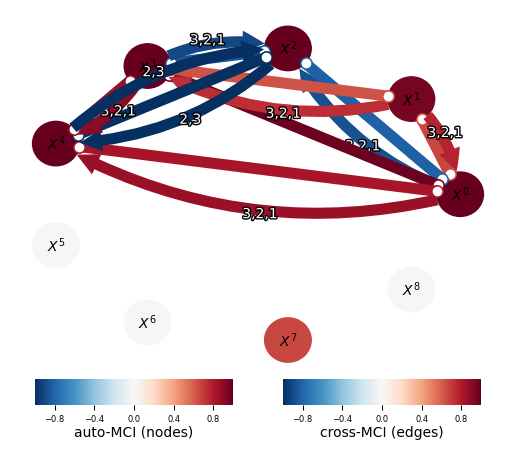

In [11]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI (edges)',
    node_colorbar_label='auto-MCI (nodes)',
    ); plt.show()

While the process graph is nicer to look at, the time series graph better represents the spatio-temporal dependency structure from which causal pathways can be read off.

In the **time series graph**, each entry in ``graph`` can be directly visualized. Directed lagged or contemporaneous links are drawn as arrows and unoriented or conflicting contemporaneous links as corresponding straight lines. In each case, the link color refers to the MCI value in ``val_matrix``. Also here, if ``val_matrix`` is not already symmetric for contemporaneous values, the maximum absolute value is shown.

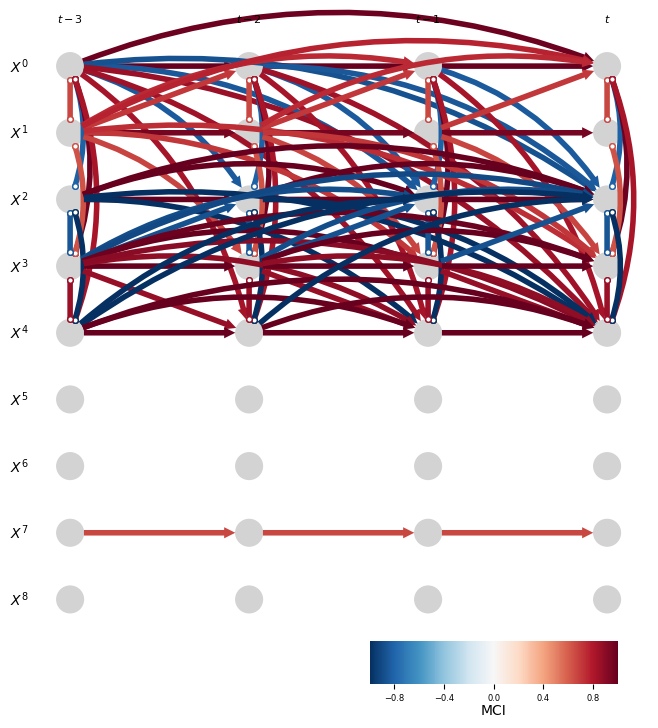

In [12]:
# Plot time series graph
tp.plot_time_series_graph(
    figsize=(8, 8),
    node_size=0.05,
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

Here PCMCIplus correctly estimates the underlying causal graph regarding both the lagged and contemporaneous links and the autodependencies.

The pair $(X^5,X^6)$ depicts a feedback cycle. These often occur in real data and the example shows that time series graphs allow to resolve feedbacks in time while other graph modeling approaches could not represent a cyclic dependency.

The contemporaneously coupled pair $(X^7,X^8)$ illustrates a case where autocorrelation helps to identify the orientation of the link. Without autocorrelation the output of PCMCIplus would be an unoriented link to indicate the Markov equivalence class.

## 4. Comparison with PCMCI and the PC algorithm

In the following we compare PCMCIplus to the standard PCMCI method that only addressed time-lagged causal discovery, and to the PC algorithm (adapted to time series).

Of course, the comparison with **standard PCMCI** on data that actually contains contemporaneous directed dependencies is unfair since this violates an assumption of PCMCI. Let's look at the same toy model example: For PCMCI, we need to construct ``graph`` based on the ``p_matrix`` (thresholded at some ``alpha_level``), which is symmetric for contemporaneous links and, hence, cannot indicate directionality.

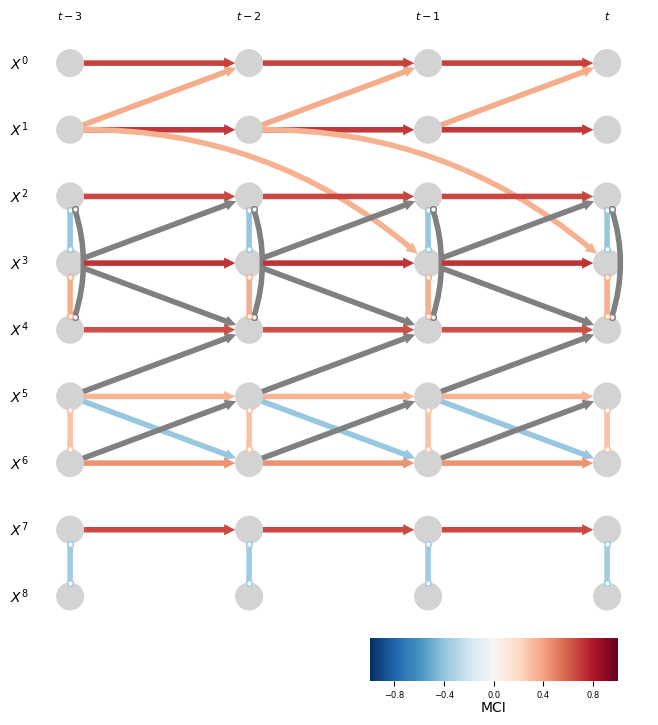

In [19]:
tau_max = 3
alpha_level = 0.001
pcmci.verbosity = 0

results = pcmci.run_pcmci(tau_min=0, tau_max=tau_max, pc_alpha=None, alpha_level=alpha_level)

# Mark false links as grey 
true_graph = toys.links_to_graph(links=links, tau_max=tau_max)
link_attribute = np.ones(results['val_matrix'].shape, dtype = 'object')
link_attribute[true_graph==""] = 'spurious'
link_attribute[true_graph!=""] = ''
# Symmetrize contemp. link attribute
for (i,j) in zip(*np.where(true_graph[:,:,0]!="")):
    link_attribute[i,j,0] = link_attribute[j,i,0] = ''

tp.plot_time_series_graph(
    figsize=(8, 8),
    node_size=0.05,
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    link_attribute=link_attribute,
    var_names=var_names,
    )
plt.show()

False positives (grey) here appear due to indirect paths through contemporaneous parents. For example, $X^3_{t-1} \to X^2_t$ appears due to the path $X^3_{t-1} \to X^3_t \to X^2_t$ because PCMCI only removes indirect links and common drivers that come through lagged parents, not those that come through contemporaneous parents. The same holds for the false contemporaneous link $X^2_{t} - X^4_t$ due to $X^2_{t} \leftarrow X^3_t \to X^4_t$. Further, all contemporaneous links remain undirected as indicated by the lines with circles.

The comparison to the **PC algorithm (adapted to time series)** is fair since the underlying assumptions are the same:

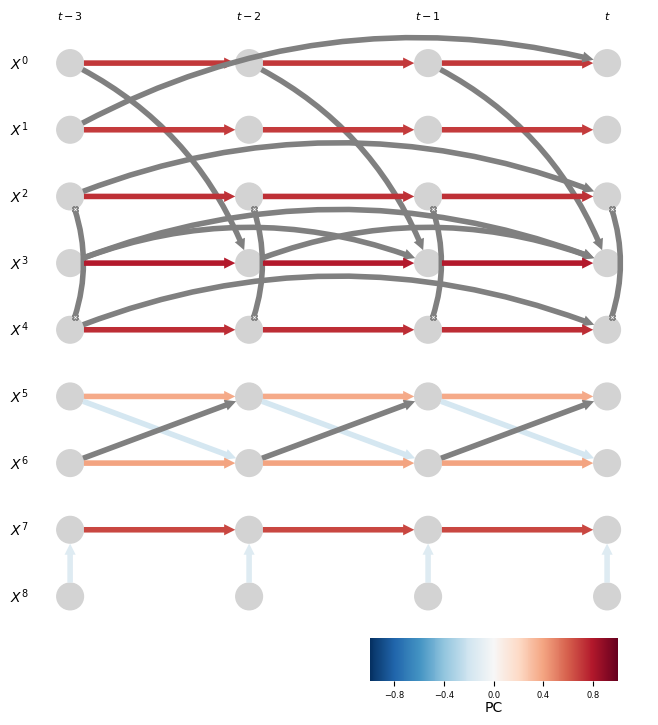

In [20]:
tau_max = 3
pcmci.verbosity = 0

results = pcmci.run_pcalg(tau_min=0, tau_max=tau_max, pc_alpha=0.01)

tp.plot_time_series_graph(
    figsize=(8, 8),
    node_size=0.05,
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    link_attribute=link_attribute,
    var_names=var_names,
    link_colorbar_label='PC')
plt.show()

Still the PC algorithm fails here in multiple ways: True links are not detected which then leads to false positives (link with conflicting orientation marked by `x-x` here) since the previously removed links are not available as conditioning sets anymore. In the paper, the low detection power is identified as the main culprit and this toy example is thoroughly discussed.

Even for very large sample sizes do we don't get the correct graph. Note the very small ``val_matrix`` since values of a link $X^i_{t-\tau} \to X^j_t$ are determined corresponding to the largest p-value across *any* condition set, and here PC runs through many.

In [ ]:
data_long, nonstationarity_indicator = toys.structural_causal_process(
    links=links, T=100000, noises=noises, seed=seed)
parcorr = ParCorr(significance='analytic')
pcmci_long = PCMCI(
    dataframe=pp.DataFrame(data_long, var_names=var_names), 
    cond_ind_test=parcorr,
    verbosity=1)
tau_max = 3
pcmci_long.verbosity = 0

results = pcmci_long.run_pcalg(tau_min=0, tau_max=tau_max, pc_alpha=0.001)

tp.plot_time_series_graph(    
    figsize=(8, 8),
    node_size=0.05,
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    link_attribute=link_attribute,
    var_names=var_names,
    link_colorbar_label='PC')
plt.show()